# **[MED] [3D] [GEN] CT GAN**

A GAN based framework for adding and removing medical evidence in 3D volumetric medical scans

[![GitHub watch](https://img.shields.io/github/watchers/LeonidAlekseev/CT-GAN.svg?style=social&label=Watch&maxAge=2592000)](https://github.com/LeonidAlekseev/CT-GAN/)

## Environment

Create conda env with yml file and activate

```
conda env create -f environment.yml
conda activate ct_gan
```

In [1]:
!conda info --envs

# conda environments:
#
base                     /home/natitov/miniforge
avtostrah                /home/natitov/miniforge/envs/avtostrah
ct_gan                *  /home/natitov/miniforge/envs/ct_gan
hack_lct                 /home/natitov/miniforge/envs/hack_lct



In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../')

## Data

### Load

In [6]:
!mkdir -p ~/.kaggle
!echo '{"username":"lifeadmin","key":"6f10a571b9c061cdbc37e224f50c42eb"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [33]:
!mkdir -p ../data

!kaggle datasets download -d ymirsky/medical-deepfakes-lung-cancer -p ../data
!unzip -qq ../data/medical-deepfakes-lung-cancer.zip -d ../data

!mv -v ../data/CT_Scans/EXP1_blind/* ../data/CT_Scans/
!mv -v ../data/CT_Scans/EXP2_open/* ../data/CT_Scans/

renamed '../data/CT_Scans/EXP1_blind/1003' -> '../data/CT_Scans/1003'
renamed '../data/CT_Scans/EXP1_blind/1005' -> '../data/CT_Scans/1005'
renamed '../data/CT_Scans/EXP1_blind/1009' -> '../data/CT_Scans/1009'
renamed '../data/CT_Scans/EXP1_blind/1045' -> '../data/CT_Scans/1045'
renamed '../data/CT_Scans/EXP1_blind/1067' -> '../data/CT_Scans/1067'
renamed '../data/CT_Scans/EXP1_blind/1201' -> '../data/CT_Scans/1201'
renamed '../data/CT_Scans/EXP1_blind/1219' -> '../data/CT_Scans/1219'
renamed '../data/CT_Scans/EXP1_blind/1280' -> '../data/CT_Scans/1280'
renamed '../data/CT_Scans/EXP1_blind/1356' -> '../data/CT_Scans/1356'
renamed '../data/CT_Scans/EXP1_blind/1402' -> '../data/CT_Scans/1402'
renamed '../data/CT_Scans/EXP1_blind/1411' -> '../data/CT_Scans/1411'
renamed '../data/CT_Scans/EXP1_blind/1438' -> '../data/CT_Scans/1438'
renamed '../data/CT_Scans/EXP1_blind/1452' -> '../data/CT_Scans/1452'
renamed '../data/CT_Scans/EXP1_blind/1531' -> '../data/CT_Scans/1531'
renamed '../data/CT_

In [3]:
import pandas as pd

labels_exp1 = pd.read_csv('../data/labels_exp1.csv')
labels_exp2 = pd.read_csv('../data/labels_exp2.csv')
labels = pd.concat((labels_exp1, labels_exp2), axis=0)
print(labels['type'].value_counts())
labels.head()

FB    72
FM    41
TM    35
TB    21
Name: type, dtype: int64


type  uuid  slice    x    y
0   FB  1280    100  323  381
1   FB  1009     76  354  288
2   FB  7794     79  163  191
3   FB  7794     94  338  243
4   FB  2997     45  156  135

Classes

* True-Benign, (TB): A location that actually has no cancer
* True-Malicious (TM): A location that has real cancer
* False-Benign (FB): A location that has real cancer, but it was removed.
* False-Malicious (FM): A location that does not have cancer, but fake cancer was injected there.

In [ ]:
import os

healthy_scans_dir = '../data/healthy_scans/'
unhealthy_scans_dir = '../data/unhealthy_scans/'

os.makedirs(healthy_scans_dir)
os.makedirs(unhealthy_scans_dir)

In [5]:
healthy_scans = labels[labels['type'] == 'TB']
unhealthy_scans = labels[labels['type'] == 'TM']

healthy_coords = healthy_scans[['uuid', 'x', 'y', 'slice']]
unhealthy_coords = unhealthy_scans[['uuid', 'x', 'y', 'slice']]
healthy_coords.columns = ['filename', 'x', 'y', 'z']
unhealthy_coords.columns = ['filename', 'x', 'y', 'z']

healthy_coords.to_csv('../data/healthy_coords.csv', index=False)
unhealthy_coords.to_csv('../data/unhealthy_coords.csv', index=False)

In [36]:
import shutil

for uuid in healthy_scans['uuid'].unique().astype(str):
  original = '../data/CT_Scans/' + uuid
  target = healthy_scans_dir + uuid
  shutil.copytree(original, target)

for uuid in unhealthy_scans['uuid'].unique().astype(str):
  original = '../data/CT_Scans/' + uuid
  target = unhealthy_scans_dir + uuid
  shutil.copytree(original, target)

### Check

In [6]:
labels[labels['type'] == 'TM'].iloc[0]

type       TM
uuid     1546
slice     159
x         183
y         243
Name: 110, dtype: object

In [38]:
!python ../utils/dicom_to_nifti.py -i ../data/CT_Scans/1546 -o ../data/1546.nii.gz

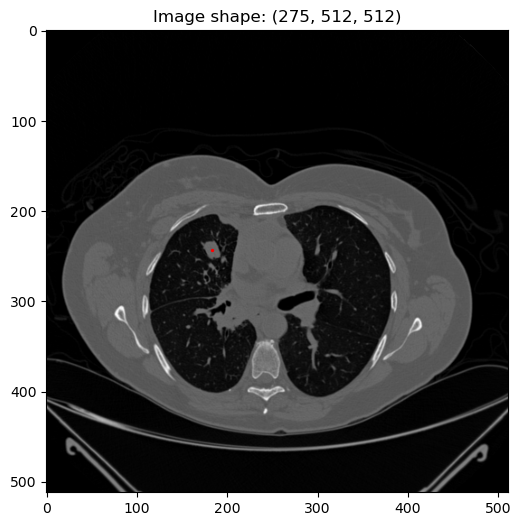

In [7]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img_path = '../data/1546.nii.gz'

test_image_nib = nib.load(img_path)
test_image = np.transpose(test_image_nib.get_fdata(), (2, 1, 0))[:, -1::-1, -1::-1]

fig = plt.figure(figsize=(12, 6))
plt.imshow(test_image[159], cmap='gray')
plt.scatter([183], [243], s=2, c='red')
plt.title(f'Image shape: {test_image.shape}')
plt.show()

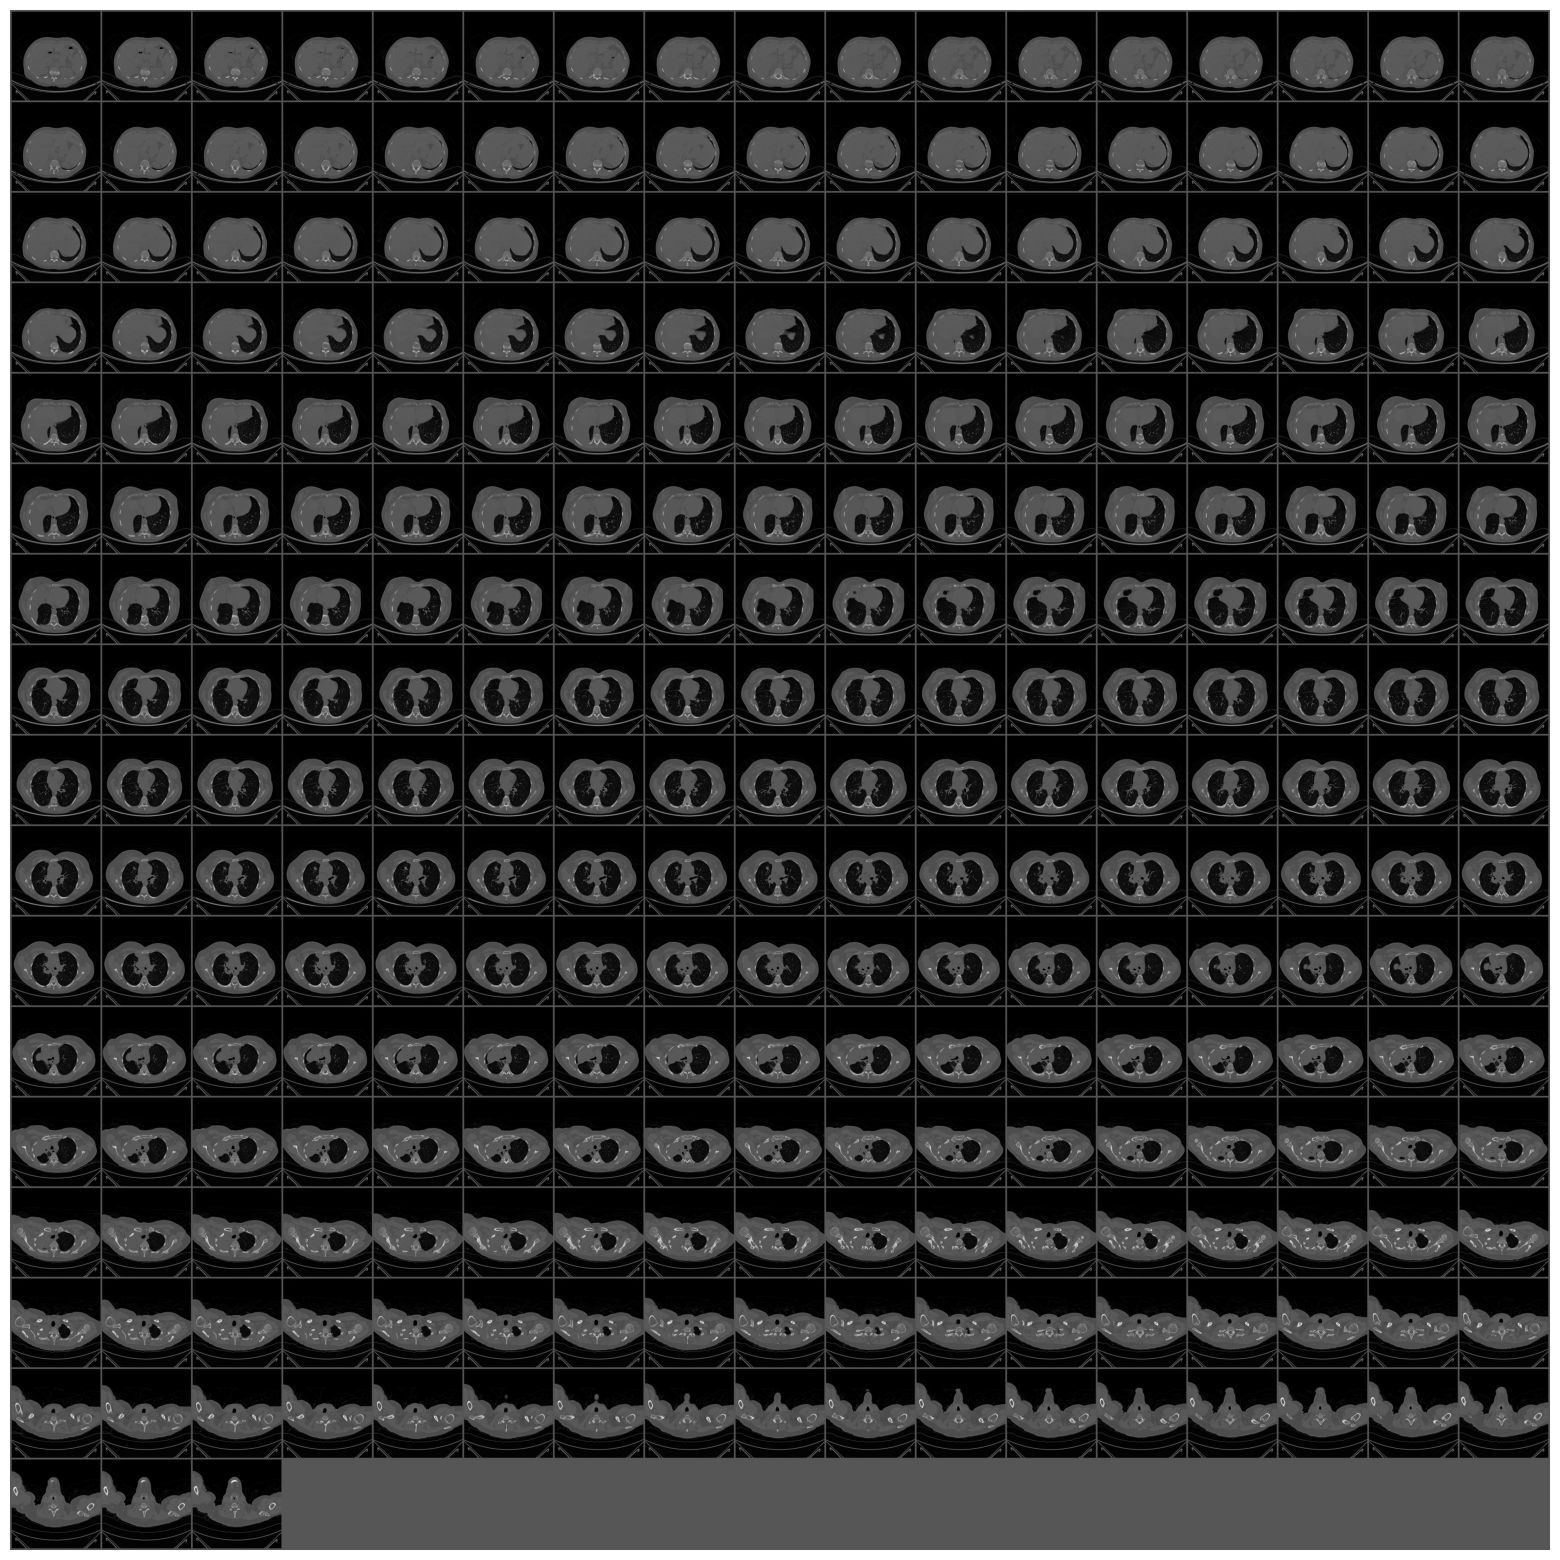

In [19]:
from skimage.util import montage

fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
ax1.imshow(montage(test_image, padding_width=10, fill=1), cmap='gray')
plt.axis('off')
plt.show()

### Dataset

preparing jobs...
extracting and augmenting samples...
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/1546   vox coord (zyx):  [159 243 183]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/1045   vox coord (zyx):  [103 258 117]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/2244   vox coord (zyx):  [ 65 360 294]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/2244   vox coord (zyx):  [ 66 315  67]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/2244   vox coord (zyx):  [ 97 403 192]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/2244   vox coord (zyx):  [108 380 102]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/6031   vox coord (zyx):  [ 51 315 119]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/6031   vox coord (zyx):  [ 64 290 240]
Working on job: /home/natitov/hack_lct/le

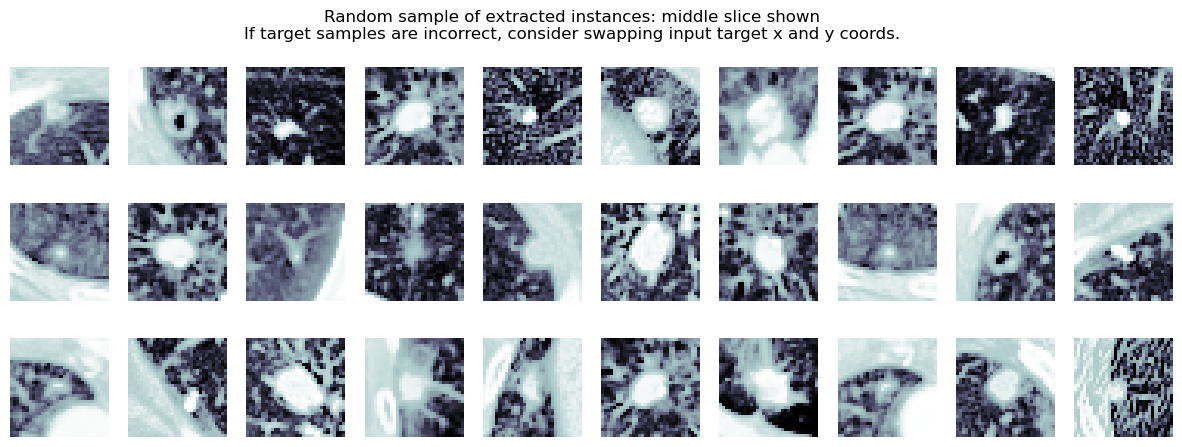

saving the dataset


In [11]:
from procedures.datasetBuilder import Extractor

builder = Extractor(is_healthy_dataset=False, parallelize=False)
builder.extract()

## Model

### Training

In [12]:
from procedures.trainer import Trainer

CTGAN_inj = Trainer(isInjector = True)
CTGAN_inj.train(epochs=200, batch_size=32, sample_interval=50)

2022-11-04 01:53:41.674912: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1512] Adding visible gpu devices: 0
2022-11-04 01:53:41.674988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:984] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-11-04 01:53:41.675006: I tensorflow/core/common_runtime/gpu/gpu_device.cc:990]      0 
2022-11-04 01:53:41.675017: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1003] 0:   N 
2022-11-04 01:53:41.675137: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30588 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)


loading preprocessed dataset...
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 32, 1 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 32, 32, 1 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 32, 32, 32, 2 0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv3

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

2022-11-04 01:53:48.090643: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-11-04 01:53:48.093091: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-11-04 01:53:48.121644: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-11-04 01:53:48.123979: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.


Instructions for updating:
Use tf.cast instead.
[Epoch 0/200] [Batch 0/73] [D loss: 0.741612, acc:  41%] [G loss: 53.653065] time: 0:00:24.885443
[Epoch 0/200] [Batch 1/73] [D loss: 0.738090, acc:  41%] [G loss: 61.437359] time: 0:00:26.726014
[Epoch 0/200] [Batch 2/73] [D loss: 0.870656, acc:  40%] [G loss: 41.339989] time: 0:00:27.784706
[Epoch 0/200] [Batch 3/73] [D loss: 0.675928, acc:  42%] [G loss: 31.791475] time: 0:00:28.845939
[Epoch 0/200] [Batch 4/73] [D loss: 0.631070, acc:  43%] [G loss: 30.371580] time: 0:00:29.925334
[Epoch 0/200] [Batch 5/73] [D loss: 0.644254, acc:  44%] [G loss: 28.631149] time: 0:00:30.985398
[Epoch 0/200] [Batch 6/73] [D loss: 0.554761, acc:  48%] [G loss: 25.148333] time: 0:00:32.040312
[Epoch 0/200] [Batch 7/73] [D loss: 0.497668, acc:  48%] [G loss: 22.264627] time: 0:00:33.092837
[Epoch 0/200] [Batch 8/73] [D loss: 0.484093, acc:  48%] [G loss: 19.958893] time: 0:00:34.146540
[Epoch 0/200] [Batch 9/73] [D loss: 0.462580, acc:  46%] [G loss: 19.4

0it [00:00, ?it/s]

[Epoch 1/200] [Batch 0/73] [D loss: 0.290918, acc:  59%] [G loss: 10.198996] time: 0:01:46.158729
[Epoch 1/200] [Batch 1/73] [D loss: 0.282801, acc:  61%] [G loss: 9.442617] time: 0:01:47.786506
[Epoch 1/200] [Batch 2/73] [D loss: 0.308744, acc:  57%] [G loss: 10.225376] time: 0:01:48.834231
[Epoch 1/200] [Batch 3/73] [D loss: 0.295609, acc:  59%] [G loss: 11.221242] time: 0:01:49.893625
[Epoch 1/200] [Batch 4/73] [D loss: 0.309181, acc:  56%] [G loss: 10.673661] time: 0:01:50.950480
[Epoch 1/200] [Batch 5/73] [D loss: 0.319394, acc:  56%] [G loss: 10.617497] time: 0:01:52.002809
[Epoch 1/200] [Batch 6/73] [D loss: 0.297719, acc:  57%] [G loss: 10.473649] time: 0:01:53.064720
[Epoch 1/200] [Batch 7/73] [D loss: 0.281192, acc:  62%] [G loss: 9.764536] time: 0:01:54.156795
[Epoch 1/200] [Batch 8/73] [D loss: 0.305300, acc:  58%] [G loss: 9.311779] time: 0:01:55.227308
[Epoch 1/200] [Batch 9/73] [D loss: 0.269284, acc:  59%] [G loss: 10.074819] time: 0:01:56.281505
[Epoch 1/200] [Batch 10

0it [00:00, ?it/s]

[Epoch 2/200] [Batch 0/73] [D loss: 0.278146, acc:  56%] [G loss: 9.330902] time: 0:03:05.558168
[Epoch 2/200] [Batch 1/73] [D loss: 0.231692, acc:  69%] [G loss: 8.694722] time: 0:03:06.875383
[Epoch 2/200] [Batch 2/73] [D loss: 0.305795, acc:  54%] [G loss: 9.112700] time: 0:03:07.920475
[Epoch 2/200] [Batch 3/73] [D loss: 0.289362, acc:  58%] [G loss: 9.931771] time: 0:03:08.964076
[Epoch 2/200] [Batch 4/73] [D loss: 0.275819, acc:  59%] [G loss: 9.654089] time: 0:03:10.009227
[Epoch 2/200] [Batch 5/73] [D loss: 0.236634, acc:  67%] [G loss: 9.564409] time: 0:03:11.071044
[Epoch 2/200] [Batch 6/73] [D loss: 0.237563, acc:  64%] [G loss: 9.356692] time: 0:03:12.116381
[Epoch 2/200] [Batch 7/73] [D loss: 0.234934, acc:  66%] [G loss: 8.687828] time: 0:03:13.159248
[Epoch 2/200] [Batch 8/73] [D loss: 0.262631, acc:  61%] [G loss: 8.228921] time: 0:03:14.205527
[Epoch 2/200] [Batch 9/73] [D loss: 0.241624, acc:  62%] [G loss: 8.965462] time: 0:03:15.254014
[Epoch 2/200] [Batch 10/73] [D

0it [00:00, ?it/s]

[Epoch 3/200] [Batch 0/73] [D loss: 0.221910, acc:  67%] [G loss: 8.339373] time: 0:04:25.157564
[Epoch 3/200] [Batch 1/73] [D loss: 0.260766, acc:  59%] [G loss: 7.619880] time: 0:04:26.562834
[Epoch 3/200] [Batch 2/73] [D loss: 0.268930, acc:  59%] [G loss: 8.392237] time: 0:04:27.611050
[Epoch 3/200] [Batch 3/73] [D loss: 0.253717, acc:  62%] [G loss: 9.377193] time: 0:04:28.660102
[Epoch 3/200] [Batch 4/73] [D loss: 0.257866, acc:  61%] [G loss: 9.035089] time: 0:04:29.708921
[Epoch 3/200] [Batch 5/73] [D loss: 0.269044, acc:  63%] [G loss: 9.059844] time: 0:04:30.753983
[Epoch 3/200] [Batch 6/73] [D loss: 0.254821, acc:  59%] [G loss: 8.738514] time: 0:04:31.804988
[Epoch 3/200] [Batch 7/73] [D loss: 0.228946, acc:  66%] [G loss: 8.030593] time: 0:04:32.866886
[Epoch 3/200] [Batch 8/73] [D loss: 0.240264, acc:  65%] [G loss: 7.675574] time: 0:04:33.922420
[Epoch 3/200] [Batch 9/73] [D loss: 0.228674, acc:  62%] [G loss: 8.424801] time: 0:04:34.980677
[Epoch 3/200] [Batch 10/73] [D

0it [00:00, ?it/s]

[Epoch 4/200] [Batch 0/73] [D loss: 0.215639, acc:  68%] [G loss: 8.354231] time: 0:05:44.824185
[Epoch 4/200] [Batch 1/73] [D loss: 0.203576, acc:  69%] [G loss: 7.193854] time: 0:05:46.200877
[Epoch 4/200] [Batch 2/73] [D loss: 0.192704, acc:  71%] [G loss: 7.763430] time: 0:05:47.249361
[Epoch 4/200] [Batch 3/73] [D loss: 0.206846, acc:  70%] [G loss: 8.444939] time: 0:05:48.305541
[Epoch 4/200] [Batch 4/73] [D loss: 0.211865, acc:  68%] [G loss: 8.279383] time: 0:05:49.360960
[Epoch 4/200] [Batch 5/73] [D loss: 0.206406, acc:  71%] [G loss: 8.281508] time: 0:05:50.416243
[Epoch 4/200] [Batch 6/73] [D loss: 0.217979, acc:  65%] [G loss: 8.237301] time: 0:05:51.470887
[Epoch 4/200] [Batch 7/73] [D loss: 0.217796, acc:  66%] [G loss: 7.650294] time: 0:05:52.526882
[Epoch 4/200] [Batch 8/73] [D loss: 0.189702, acc:  73%] [G loss: 7.373482] time: 0:05:53.582425
[Epoch 4/200] [Batch 9/73] [D loss: 0.200341, acc:  68%] [G loss: 7.894079] time: 0:05:54.630579
[Epoch 4/200] [Batch 10/73] [D

0it [00:00, ?it/s]

[Epoch 5/200] [Batch 0/73] [D loss: 0.209360, acc:  67%] [G loss: 7.666314] time: 0:07:04.498501
[Epoch 5/200] [Batch 1/73] [D loss: 0.206290, acc:  66%] [G loss: 7.003119] time: 0:07:05.906420
[Epoch 5/200] [Batch 2/73] [D loss: 0.192799, acc:  70%] [G loss: 7.609777] time: 0:07:06.959872
[Epoch 5/200] [Batch 3/73] [D loss: 0.206747, acc:  69%] [G loss: 8.455278] time: 0:07:08.027462
[Epoch 5/200] [Batch 4/73] [D loss: 0.176130, acc:  75%] [G loss: 8.007292] time: 0:07:09.075134
[Epoch 5/200] [Batch 5/73] [D loss: 0.212209, acc:  70%] [G loss: 7.941895] time: 0:07:10.130270
[Epoch 5/200] [Batch 6/73] [D loss: 0.193401, acc:  71%] [G loss: 7.829104] time: 0:07:11.183751
[Epoch 5/200] [Batch 7/73] [D loss: 0.200351, acc:  70%] [G loss: 7.197866] time: 0:07:12.238592
[Epoch 5/200] [Batch 8/73] [D loss: 0.216296, acc:  68%] [G loss: 6.857255] time: 0:07:13.294202
[Epoch 5/200] [Batch 9/73] [D loss: 0.173399, acc:  74%] [G loss: 7.558146] time: 0:07:14.342214
[Epoch 5/200] [Batch 10/73] [D

0it [00:00, ?it/s]

[Epoch 6/200] [Batch 0/73] [D loss: 0.201286, acc:  69%] [G loss: 7.645190] time: 0:08:24.148623
[Epoch 6/200] [Batch 1/73] [D loss: 0.158904, acc:  77%] [G loss: 7.033760] time: 0:08:25.524468
[Epoch 6/200] [Batch 2/73] [D loss: 0.211427, acc:  65%] [G loss: 7.610023] time: 0:08:26.569531
[Epoch 6/200] [Batch 3/73] [D loss: 0.161792, acc:  77%] [G loss: 8.251332] time: 0:08:27.622767
[Epoch 6/200] [Batch 4/73] [D loss: 0.176724, acc:  74%] [G loss: 7.868516] time: 0:08:28.675661
[Epoch 6/200] [Batch 5/73] [D loss: 0.221372, acc:  67%] [G loss: 7.867721] time: 0:08:29.722419
[Epoch 6/200] [Batch 6/73] [D loss: 0.177660, acc:  71%] [G loss: 7.714321] time: 0:08:30.771912
[Epoch 6/200] [Batch 7/73] [D loss: 0.180613, acc:  73%] [G loss: 7.105404] time: 0:08:31.827117
[Epoch 6/200] [Batch 8/73] [D loss: 0.198042, acc:  70%] [G loss: 6.769884] time: 0:08:32.882969
[Epoch 6/200] [Batch 9/73] [D loss: 0.151740, acc:  80%] [G loss: 7.522930] time: 0:08:33.931301
[Epoch 6/200] [Batch 10/73] [D

0it [00:00, ?it/s]

[Epoch 7/200] [Batch 0/73] [D loss: 0.198676, acc:  71%] [G loss: 7.791365] time: 0:09:43.759340
[Epoch 7/200] [Batch 1/73] [D loss: 0.139386, acc:  83%] [G loss: 7.325491] time: 0:09:45.123308
[Epoch 7/200] [Batch 2/73] [D loss: 0.151799, acc:  78%] [G loss: 7.415830] time: 0:09:46.173571
[Epoch 7/200] [Batch 3/73] [D loss: 0.152763, acc:  79%] [G loss: 8.189198] time: 0:09:47.230427
[Epoch 7/200] [Batch 4/73] [D loss: 0.157304, acc:  80%] [G loss: 7.650876] time: 0:09:48.283924
[Epoch 7/200] [Batch 5/73] [D loss: 0.167103, acc:  77%] [G loss: 7.632390] time: 0:09:49.332438
[Epoch 7/200] [Batch 6/73] [D loss: 0.133142, acc:  83%] [G loss: 7.646220] time: 0:09:50.396085
[Epoch 7/200] [Batch 7/73] [D loss: 0.162321, acc:  77%] [G loss: 7.063222] time: 0:09:51.448755
[Epoch 7/200] [Batch 8/73] [D loss: 0.157284, acc:  77%] [G loss: 6.648275] time: 0:09:52.493575
[Epoch 7/200] [Batch 9/73] [D loss: 0.173394, acc:  76%] [G loss: 7.288319] time: 0:09:53.546543
[Epoch 7/200] [Batch 10/73] [D

0it [00:00, ?it/s]

[Epoch 8/200] [Batch 0/73] [D loss: 0.181114, acc:  73%] [G loss: 7.094173] time: 0:11:03.549666
[Epoch 8/200] [Batch 1/73] [D loss: 0.149246, acc:  80%] [G loss: 6.568251] time: 0:11:05.251365
[Epoch 8/200] [Batch 2/73] [D loss: 0.152944, acc:  78%] [G loss: 7.262176] time: 0:11:06.297861
[Epoch 8/200] [Batch 3/73] [D loss: 0.143773, acc:  80%] [G loss: 7.817923] time: 0:11:07.349446
[Epoch 8/200] [Batch 4/73] [D loss: 0.119272, acc:  86%] [G loss: 7.623993] time: 0:11:08.422584
[Epoch 8/200] [Batch 5/73] [D loss: 0.170496, acc:  75%] [G loss: 7.686501] time: 0:11:09.472330
[Epoch 8/200] [Batch 6/73] [D loss: 0.135005, acc:  84%] [G loss: 7.526007] time: 0:11:10.526569
[Epoch 8/200] [Batch 7/73] [D loss: 0.156303, acc:  80%] [G loss: 6.845772] time: 0:11:11.580792
[Epoch 8/200] [Batch 8/73] [D loss: 0.188207, acc:  73%] [G loss: 6.786283] time: 0:11:12.627790
[Epoch 8/200] [Batch 9/73] [D loss: 0.117680, acc:  88%] [G loss: 7.452437] time: 0:11:13.675079
[Epoch 8/200] [Batch 10/73] [D

0it [00:00, ?it/s]

[Epoch 9/200] [Batch 0/73] [D loss: 0.122165, acc:  86%] [G loss: 7.069027] time: 0:12:23.474719
[Epoch 9/200] [Batch 1/73] [D loss: 0.141760, acc:  84%] [G loss: 6.634908] time: 0:12:24.871386
[Epoch 9/200] [Batch 2/73] [D loss: 0.127603, acc:  83%] [G loss: 7.044953] time: 0:12:25.922781
[Epoch 9/200] [Batch 3/73] [D loss: 0.114903, acc:  87%] [G loss: 7.650350] time: 0:12:26.983791
[Epoch 9/200] [Batch 4/73] [D loss: 0.097821, acc:  90%] [G loss: 7.554282] time: 0:12:28.036972
[Epoch 9/200] [Batch 5/73] [D loss: 0.138987, acc:  83%] [G loss: 7.462384] time: 0:12:29.086671
[Epoch 9/200] [Batch 6/73] [D loss: 0.123541, acc:  86%] [G loss: 7.353074] time: 0:12:30.134220
[Epoch 9/200] [Batch 7/73] [D loss: 0.143882, acc:  82%] [G loss: 6.677619] time: 0:12:31.187738
[Epoch 9/200] [Batch 8/73] [D loss: 0.161151, acc:  77%] [G loss: 6.615580] time: 0:12:32.238486
[Epoch 9/200] [Batch 9/73] [D loss: 0.116519, acc:  89%] [G loss: 7.268381] time: 0:12:33.294411
[Epoch 9/200] [Batch 10/73] [D

0it [00:00, ?it/s]

[Epoch 10/200] [Batch 0/73] [D loss: 0.111763, acc:  87%] [G loss: 7.127046] time: 0:13:43.119340
[Epoch 10/200] [Batch 1/73] [D loss: 0.126115, acc:  86%] [G loss: 6.368766] time: 0:13:44.480662
[Epoch 10/200] [Batch 2/73] [D loss: 0.099913, acc:  90%] [G loss: 7.168577] time: 0:13:45.529535
[Epoch 10/200] [Batch 3/73] [D loss: 0.116688, acc:  87%] [G loss: 7.456122] time: 0:13:46.580190
[Epoch 10/200] [Batch 4/73] [D loss: 0.108457, acc:  90%] [G loss: 7.244246] time: 0:13:47.657482
[Epoch 10/200] [Batch 5/73] [D loss: 0.085364, acc:  92%] [G loss: 7.273705] time: 0:13:48.710912
[Epoch 10/200] [Batch 6/73] [D loss: 0.108816, acc:  89%] [G loss: 7.234043] time: 0:13:49.760425
[Epoch 10/200] [Batch 7/73] [D loss: 0.179565, acc:  74%] [G loss: 6.646950] time: 0:13:50.835592
[Epoch 10/200] [Batch 8/73] [D loss: 0.138125, acc:  83%] [G loss: 6.477280] time: 0:13:51.881244
[Epoch 10/200] [Batch 9/73] [D loss: 0.083663, acc:  94%] [G loss: 7.209537] time: 0:13:52.939769
[Epoch 10/200] [Batc

0it [00:00, ?it/s]

[Epoch 11/200] [Batch 0/73] [D loss: 0.129676, acc:  83%] [G loss: 7.081933] time: 0:15:02.856737
[Epoch 11/200] [Batch 1/73] [D loss: 0.087307, acc:  94%] [G loss: 6.466437] time: 0:15:04.222035
[Epoch 11/200] [Batch 2/73] [D loss: 0.114735, acc:  88%] [G loss: 6.845384] time: 0:15:05.266571
[Epoch 11/200] [Batch 3/73] [D loss: 0.085713, acc:  92%] [G loss: 7.468700] time: 0:15:06.320297
[Epoch 11/200] [Batch 4/73] [D loss: 0.089924, acc:  93%] [G loss: 7.147121] time: 0:15:07.376727
[Epoch 11/200] [Batch 5/73] [D loss: 0.088833, acc:  92%] [G loss: 7.167063] time: 0:15:08.439321
[Epoch 11/200] [Batch 6/73] [D loss: 0.089990, acc:  94%] [G loss: 7.029319] time: 0:15:09.486943
[Epoch 11/200] [Batch 7/73] [D loss: 0.089150, acc:  93%] [G loss: 6.467773] time: 0:15:10.556343
[Epoch 11/200] [Batch 8/73] [D loss: 0.100366, acc:  89%] [G loss: 6.225284] time: 0:15:11.607418
[Epoch 11/200] [Batch 9/73] [D loss: 0.121782, acc:  85%] [G loss: 6.895105] time: 0:15:12.657190
[Epoch 11/200] [Batc

0it [00:00, ?it/s]

[Epoch 12/200] [Batch 0/73] [D loss: 0.081985, acc:  93%] [G loss: 6.887655] time: 0:16:22.355593
[Epoch 12/200] [Batch 1/73] [D loss: 0.131637, acc:  84%] [G loss: 6.549227] time: 0:16:23.717011
[Epoch 12/200] [Batch 2/73] [D loss: 0.094478, acc:  91%] [G loss: 7.000126] time: 0:16:24.772039
[Epoch 12/200] [Batch 3/73] [D loss: 0.058714, acc:  96%] [G loss: 7.521876] time: 0:16:25.832674
[Epoch 12/200] [Batch 4/73] [D loss: 0.061314, acc:  97%] [G loss: 7.128308] time: 0:16:26.879915
[Epoch 12/200] [Batch 5/73] [D loss: 0.061581, acc:  96%] [G loss: 7.134406] time: 0:16:27.928137
[Epoch 12/200] [Batch 6/73] [D loss: 0.095310, acc:  93%] [G loss: 6.996779] time: 0:16:28.978608
[Epoch 12/200] [Batch 7/73] [D loss: 0.098132, acc:  91%] [G loss: 6.550823] time: 0:16:30.025290
[Epoch 12/200] [Batch 8/73] [D loss: 0.083463, acc:  91%] [G loss: 6.450986] time: 0:16:31.086294
[Epoch 12/200] [Batch 9/73] [D loss: 0.095875, acc:  90%] [G loss: 6.940089] time: 0:16:32.146720
[Epoch 12/200] [Batc

0it [00:00, ?it/s]

[Epoch 13/200] [Batch 0/73] [D loss: 0.062346, acc:  95%] [G loss: 6.781112] time: 0:17:41.683842
[Epoch 13/200] [Batch 1/73] [D loss: 0.131627, acc:  84%] [G loss: 6.936944] time: 0:17:43.044559
[Epoch 13/200] [Batch 2/73] [D loss: 0.079072, acc:  93%] [G loss: 7.493881] time: 0:17:44.098859
[Epoch 13/200] [Batch 3/73] [D loss: 0.063591, acc:  95%] [G loss: 7.538603] time: 0:17:45.153334
[Epoch 13/200] [Batch 4/73] [D loss: 0.047749, acc:  98%] [G loss: 7.081345] time: 0:17:46.198145
[Epoch 13/200] [Batch 5/73] [D loss: 0.057820, acc:  96%] [G loss: 7.331251] time: 0:17:47.245492
[Epoch 13/200] [Batch 6/73] [D loss: 0.089927, acc:  91%] [G loss: 7.331215] time: 0:17:48.291142
[Epoch 13/200] [Batch 7/73] [D loss: 0.064195, acc:  98%] [G loss: 6.690325] time: 0:17:49.347798
[Epoch 13/200] [Batch 8/73] [D loss: 0.075704, acc:  91%] [G loss: 6.371806] time: 0:17:50.406310
[Epoch 13/200] [Batch 9/73] [D loss: 0.059460, acc:  96%] [G loss: 7.235520] time: 0:17:51.454172
[Epoch 13/200] [Batc

0it [00:00, ?it/s]

[Epoch 14/200] [Batch 0/73] [D loss: 0.050258, acc:  98%] [G loss: 6.886390] time: 0:19:00.968502
[Epoch 14/200] [Batch 1/73] [D loss: 0.082127, acc:  95%] [G loss: 6.726462] time: 0:19:02.364812
[Epoch 14/200] [Batch 2/73] [D loss: 0.049092, acc:  97%] [G loss: 7.136748] time: 0:19:03.409417
[Epoch 14/200] [Batch 3/73] [D loss: 0.042767, acc:  97%] [G loss: 7.293937] time: 0:19:04.454602
[Epoch 14/200] [Batch 4/73] [D loss: 0.052625, acc:  97%] [G loss: 7.202048] time: 0:19:05.510575
[Epoch 14/200] [Batch 5/73] [D loss: 0.047020, acc:  97%] [G loss: 7.092559] time: 0:19:06.556870
[Epoch 14/200] [Batch 6/73] [D loss: 0.042157, acc:  98%] [G loss: 6.895160] time: 0:19:07.619808
[Epoch 14/200] [Batch 7/73] [D loss: 0.060371, acc:  97%] [G loss: 6.334105] time: 0:19:08.673585
[Epoch 14/200] [Batch 8/73] [D loss: 0.064822, acc:  95%] [G loss: 6.105331] time: 0:19:09.720886
[Epoch 14/200] [Batch 9/73] [D loss: 0.052455, acc:  98%] [G loss: 6.724068] time: 0:19:10.770691
[Epoch 14/200] [Batc

0it [00:00, ?it/s]

[Epoch 15/200] [Batch 0/73] [D loss: 0.049110, acc:  99%] [G loss: 6.521649] time: 0:20:20.383050
[Epoch 15/200] [Batch 1/73] [D loss: 0.046933, acc:  98%] [G loss: 5.997703] time: 0:20:21.758696
[Epoch 15/200] [Batch 2/73] [D loss: 0.065662, acc:  96%] [G loss: 6.703180] time: 0:20:22.804019
[Epoch 15/200] [Batch 3/73] [D loss: 0.034956, acc:  99%] [G loss: 7.426678] time: 0:20:23.856285
[Epoch 15/200] [Batch 4/73] [D loss: 0.042367, acc:  99%] [G loss: 7.013846] time: 0:20:24.900841
[Epoch 15/200] [Batch 5/73] [D loss: 0.107464, acc:  87%] [G loss: 6.972668] time: 0:20:25.953899
[Epoch 15/200] [Batch 6/73] [D loss: 0.063933, acc:  97%] [G loss: 6.782538] time: 0:20:27.001761
[Epoch 15/200] [Batch 7/73] [D loss: 0.057983, acc:  98%] [G loss: 6.288133] time: 0:20:28.048452
[Epoch 15/200] [Batch 8/73] [D loss: 0.066146, acc:  94%] [G loss: 5.995603] time: 0:20:29.095989
[Epoch 15/200] [Batch 9/73] [D loss: 0.066385, acc:  96%] [G loss: 6.543077] time: 0:20:30.146267
[Epoch 15/200] [Batc

0it [00:00, ?it/s]

[Epoch 16/200] [Batch 0/73] [D loss: 0.073123, acc:  96%] [G loss: 6.385977] time: 0:21:39.972510
[Epoch 16/200] [Batch 1/73] [D loss: 0.053349, acc:  98%] [G loss: 5.802619] time: 0:21:41.820447
[Epoch 16/200] [Batch 2/73] [D loss: 0.044801, acc:  97%] [G loss: 6.368143] time: 0:21:42.869167
[Epoch 16/200] [Batch 3/73] [D loss: 0.055833, acc:  97%] [G loss: 6.998169] time: 0:21:43.919217
[Epoch 16/200] [Batch 4/73] [D loss: 0.039123, acc:  99%] [G loss: 6.772328] time: 0:21:44.981405
[Epoch 16/200] [Batch 5/73] [D loss: 0.035239, acc:  99%] [G loss: 6.910178] time: 0:21:46.031579
[Epoch 16/200] [Batch 6/73] [D loss: 0.043895, acc:  99%] [G loss: 6.723248] time: 0:21:47.091030
[Epoch 16/200] [Batch 7/73] [D loss: 0.042856, acc:  98%] [G loss: 6.229635] time: 0:21:48.143172
[Epoch 16/200] [Batch 8/73] [D loss: 0.058589, acc:  95%] [G loss: 6.010768] time: 0:21:49.193481
[Epoch 16/200] [Batch 9/73] [D loss: 0.035225, acc:  99%] [G loss: 6.568354] time: 0:21:50.236369
[Epoch 16/200] [Batc

0it [00:00, ?it/s]

[Epoch 17/200] [Batch 0/73] [D loss: 0.040858, acc:  99%] [G loss: 6.226188] time: 0:23:00.181844
[Epoch 17/200] [Batch 1/73] [D loss: 0.050335, acc:  99%] [G loss: 5.809890] time: 0:23:01.550918
[Epoch 17/200] [Batch 2/73] [D loss: 0.051344, acc:  98%] [G loss: 6.521851] time: 0:23:02.599161
[Epoch 17/200] [Batch 3/73] [D loss: 0.033465, acc:  99%] [G loss: 7.035964] time: 0:23:03.663605
[Epoch 17/200] [Batch 4/73] [D loss: 0.027627, acc:  99%] [G loss: 6.661514] time: 0:23:04.732838
[Epoch 17/200] [Batch 5/73] [D loss: 0.043278, acc:  98%] [G loss: 6.751018] time: 0:23:05.781361
[Epoch 17/200] [Batch 6/73] [D loss: 0.039090, acc:  99%] [G loss: 6.661985] time: 0:23:06.830758
[Epoch 17/200] [Batch 7/73] [D loss: 0.052862, acc:  99%] [G loss: 6.204199] time: 0:23:07.891645
[Epoch 17/200] [Batch 8/73] [D loss: 0.064257, acc:  95%] [G loss: 6.027502] time: 0:23:08.940678
[Epoch 17/200] [Batch 9/73] [D loss: 0.059507, acc:  97%] [G loss: 6.533888] time: 0:23:09.986629
[Epoch 17/200] [Batc

0it [00:00, ?it/s]

[Epoch 18/200] [Batch 0/73] [D loss: 0.038486, acc:  99%] [G loss: 6.640777] time: 0:24:19.779824
[Epoch 18/200] [Batch 1/73] [D loss: 0.033748, acc:  99%] [G loss: 5.801136] time: 0:24:21.134680
[Epoch 18/200] [Batch 2/73] [D loss: 0.034945, acc:  99%] [G loss: 6.384164] time: 0:24:22.184700
[Epoch 18/200] [Batch 3/73] [D loss: 0.063045, acc:  95%] [G loss: 6.978715] time: 0:24:23.242441
[Epoch 18/200] [Batch 4/73] [D loss: 0.039035, acc:  98%] [G loss: 6.614812] time: 0:24:24.305252
[Epoch 18/200] [Batch 5/73] [D loss: 0.029229, acc:  99%] [G loss: 6.654781] time: 0:24:25.356259
[Epoch 18/200] [Batch 6/73] [D loss: 0.035926, acc:  99%] [G loss: 6.573007] time: 0:24:26.418842
[Epoch 18/200] [Batch 7/73] [D loss: 0.051878, acc:  98%] [G loss: 6.105314] time: 0:24:27.469339
[Epoch 18/200] [Batch 8/73] [D loss: 0.053144, acc:  96%] [G loss: 5.905754] time: 0:24:28.534543
[Epoch 18/200] [Batch 9/73] [D loss: 0.038675, acc:  99%] [G loss: 6.392594] time: 0:24:29.582033
[Epoch 18/200] [Batc

0it [00:00, ?it/s]

[Epoch 19/200] [Batch 0/73] [D loss: 0.027655, acc:  99%] [G loss: 6.363145] time: 0:25:39.436734
[Epoch 19/200] [Batch 1/73] [D loss: 0.042751, acc:  99%] [G loss: 5.698153] time: 0:25:40.798331
[Epoch 19/200] [Batch 2/73] [D loss: 0.050517, acc:  99%] [G loss: 6.305524] time: 0:25:41.851614
[Epoch 19/200] [Batch 3/73] [D loss: 0.024130, acc: 100%] [G loss: 7.049348] time: 0:25:42.912308
[Epoch 19/200] [Batch 4/73] [D loss: 0.028935, acc: 100%] [G loss: 6.566765] time: 0:25:43.964465
[Epoch 19/200] [Batch 5/73] [D loss: 0.024644, acc:  99%] [G loss: 6.562873] time: 0:25:45.022428
[Epoch 19/200] [Batch 6/73] [D loss: 0.038622, acc:  99%] [G loss: 6.513159] time: 0:25:46.072292
[Epoch 19/200] [Batch 7/73] [D loss: 0.028341, acc: 100%] [G loss: 6.174160] time: 0:25:47.122510
[Epoch 19/200] [Batch 8/73] [D loss: 0.042467, acc:  98%] [G loss: 5.902599] time: 0:25:48.186993
[Epoch 19/200] [Batch 9/73] [D loss: 0.029298, acc:  99%] [G loss: 6.448159] time: 0:25:49.250199
[Epoch 19/200] [Batc

0it [00:00, ?it/s]

[Epoch 20/200] [Batch 0/73] [D loss: 0.025947, acc: 100%] [G loss: 6.370088] time: 0:26:59.094828
[Epoch 20/200] [Batch 1/73] [D loss: 0.051462, acc:  98%] [G loss: 5.964517] time: 0:27:00.479870
[Epoch 20/200] [Batch 2/73] [D loss: 0.031083, acc:  99%] [G loss: 6.419858] time: 0:27:01.526540
[Epoch 20/200] [Batch 3/73] [D loss: 0.030566, acc:  99%] [G loss: 6.778669] time: 0:27:02.582248
[Epoch 20/200] [Batch 4/73] [D loss: 0.021313, acc: 100%] [G loss: 6.540951] time: 0:27:03.632294
[Epoch 20/200] [Batch 5/73] [D loss: 0.024489, acc:  99%] [G loss: 6.607762] time: 0:27:04.698016
[Epoch 20/200] [Batch 6/73] [D loss: 0.021874, acc: 100%] [G loss: 6.611713] time: 0:27:05.756224
[Epoch 20/200] [Batch 7/73] [D loss: 0.051998, acc:  98%] [G loss: 6.032206] time: 0:27:06.809847
[Epoch 20/200] [Batch 8/73] [D loss: 0.035881, acc:  99%] [G loss: 5.769970] time: 0:27:07.861142
[Epoch 20/200] [Batch 9/73] [D loss: 0.025389, acc:  99%] [G loss: 6.306945] time: 0:27:08.912979
[Epoch 20/200] [Batc

0it [00:00, ?it/s]

[Epoch 21/200] [Batch 0/73] [D loss: 0.020251, acc: 100%] [G loss: 6.038882] time: 0:28:18.995424
[Epoch 21/200] [Batch 1/73] [D loss: 0.028139, acc: 100%] [G loss: 5.621710] time: 0:28:20.387803
[Epoch 21/200] [Batch 2/73] [D loss: 0.029884, acc:  99%] [G loss: 6.320193] time: 0:28:21.438199
[Epoch 21/200] [Batch 3/73] [D loss: 0.047576, acc:  98%] [G loss: 6.786879] time: 0:28:22.509780
[Epoch 21/200] [Batch 4/73] [D loss: 0.022904, acc: 100%] [G loss: 6.473891] time: 0:28:23.562580
[Epoch 21/200] [Batch 5/73] [D loss: 0.025081, acc: 100%] [G loss: 6.527206] time: 0:28:24.612498
[Epoch 21/200] [Batch 6/73] [D loss: 0.047131, acc:  99%] [G loss: 6.655608] time: 0:28:25.665829
[Epoch 21/200] [Batch 7/73] [D loss: 0.031340, acc: 100%] [G loss: 6.129518] time: 0:28:26.721673
[Epoch 21/200] [Batch 8/73] [D loss: 0.043200, acc:  98%] [G loss: 5.774313] time: 0:28:27.771218
[Epoch 21/200] [Batch 9/73] [D loss: 0.031233, acc:  99%] [G loss: 6.201854] time: 0:28:28.826771
[Epoch 21/200] [Batc

0it [00:00, ?it/s]

[Epoch 22/200] [Batch 0/73] [D loss: 0.038507, acc:  99%] [G loss: 6.354041] time: 0:29:38.514450
[Epoch 22/200] [Batch 1/73] [D loss: 0.024939, acc: 100%] [G loss: 5.720319] time: 0:29:39.858418
[Epoch 22/200] [Batch 2/73] [D loss: 0.023547, acc: 100%] [G loss: 6.281539] time: 0:29:40.907954
[Epoch 22/200] [Batch 3/73] [D loss: 0.024172, acc: 100%] [G loss: 6.827482] time: 0:29:41.956381
[Epoch 22/200] [Batch 4/73] [D loss: 0.019174, acc:  99%] [G loss: 6.415247] time: 0:29:43.003672
[Epoch 22/200] [Batch 5/73] [D loss: 0.024030, acc: 100%] [G loss: 6.490835] time: 0:29:44.049966
[Epoch 22/200] [Batch 6/73] [D loss: 0.024944, acc:  99%] [G loss: 6.407609] time: 0:29:45.096234
[Epoch 22/200] [Batch 7/73] [D loss: 0.038630, acc:  99%] [G loss: 5.904489] time: 0:29:46.144658
[Epoch 22/200] [Batch 8/73] [D loss: 0.033232, acc:  99%] [G loss: 5.671491] time: 0:29:47.192875
[Epoch 22/200] [Batch 9/73] [D loss: 0.055177, acc:  98%] [G loss: 6.231572] time: 0:29:48.242867
[Epoch 22/200] [Batc

0it [00:00, ?it/s]

[Epoch 23/200] [Batch 0/73] [D loss: 0.028102, acc: 100%] [G loss: 6.264769] time: 0:30:57.883242
[Epoch 23/200] [Batch 1/73] [D loss: 0.035481, acc:  99%] [G loss: 5.710437] time: 0:30:59.282144
[Epoch 23/200] [Batch 2/73] [D loss: 0.043097, acc:  98%] [G loss: 6.202486] time: 0:31:00.332428
[Epoch 23/200] [Batch 3/73] [D loss: 0.026853, acc:  99%] [G loss: 6.605378] time: 0:31:01.385824
[Epoch 23/200] [Batch 4/73] [D loss: 0.013840, acc: 100%] [G loss: 6.393235] time: 0:31:02.436909
[Epoch 23/200] [Batch 5/73] [D loss: 0.017687, acc: 100%] [G loss: 6.408177] time: 0:31:03.510476
[Epoch 23/200] [Batch 6/73] [D loss: 0.027612, acc:  99%] [G loss: 6.365838] time: 0:31:04.558148
[Epoch 23/200] [Batch 7/73] [D loss: 0.034539, acc: 100%] [G loss: 5.869893] time: 0:31:05.646561
[Epoch 23/200] [Batch 8/73] [D loss: 0.029288, acc:  99%] [G loss: 5.549766] time: 0:31:06.699388
[Epoch 23/200] [Batch 9/73] [D loss: 0.024007, acc:  99%] [G loss: 6.090868] time: 0:31:07.749917
[Epoch 23/200] [Batc

0it [00:00, ?it/s]

[Epoch 24/200] [Batch 0/73] [D loss: 0.035992, acc:  99%] [G loss: 6.179708] time: 0:32:17.382462
[Epoch 24/200] [Batch 1/73] [D loss: 0.021047, acc: 100%] [G loss: 5.711226] time: 0:32:18.766567
[Epoch 24/200] [Batch 2/73] [D loss: 0.046447, acc:  99%] [G loss: 6.159616] time: 0:32:19.815194
[Epoch 24/200] [Batch 3/73] [D loss: 0.015994, acc: 100%] [G loss: 6.735054] time: 0:32:20.889616
[Epoch 24/200] [Batch 4/73] [D loss: 0.020467, acc:  99%] [G loss: 6.428272] time: 0:32:21.937212
[Epoch 24/200] [Batch 5/73] [D loss: 0.020376, acc: 100%] [G loss: 6.362256] time: 0:32:22.989464
[Epoch 24/200] [Batch 6/73] [D loss: 0.018103, acc: 100%] [G loss: 6.287418] time: 0:32:24.036427
[Epoch 24/200] [Batch 7/73] [D loss: 0.059195, acc:  98%] [G loss: 5.794371] time: 0:32:25.086202
[Epoch 24/200] [Batch 8/73] [D loss: 0.039795, acc:  99%] [G loss: 5.578127] time: 0:32:26.150013
[Epoch 24/200] [Batch 9/73] [D loss: 0.020103, acc:  99%] [G loss: 6.331543] time: 0:32:27.199080
[Epoch 24/200] [Batc

0it [00:00, ?it/s]

[Epoch 25/200] [Batch 0/73] [D loss: 0.030011, acc:  99%] [G loss: 6.502089] time: 0:33:36.921915
[Epoch 25/200] [Batch 1/73] [D loss: 0.034465, acc:  99%] [G loss: 5.956052] time: 0:33:38.337672
[Epoch 25/200] [Batch 2/73] [D loss: 0.025881, acc:  99%] [G loss: 6.432067] time: 0:33:39.387482
[Epoch 25/200] [Batch 3/73] [D loss: 0.019410, acc: 100%] [G loss: 6.906143] time: 0:33:40.441564
[Epoch 25/200] [Batch 4/73] [D loss: 0.015680, acc: 100%] [G loss: 6.637478] time: 0:33:41.505283
[Epoch 25/200] [Batch 5/73] [D loss: 0.033284, acc:  99%] [G loss: 6.707468] time: 0:33:42.551966
[Epoch 25/200] [Batch 6/73] [D loss: 0.016927, acc: 100%] [G loss: 6.562659] time: 0:33:43.598093
[Epoch 25/200] [Batch 7/73] [D loss: 0.019817, acc: 100%] [G loss: 6.014353] time: 0:33:44.654272
[Epoch 25/200] [Batch 8/73] [D loss: 0.022830, acc: 100%] [G loss: 5.808983] time: 0:33:45.703536
[Epoch 25/200] [Batch 9/73] [D loss: 0.016504, acc:  99%] [G loss: 6.354742] time: 0:33:46.750011
[Epoch 25/200] [Batc

0it [00:00, ?it/s]

[Epoch 26/200] [Batch 0/73] [D loss: 0.018850, acc: 100%] [G loss: 6.166608] time: 0:34:56.497513
[Epoch 26/200] [Batch 1/73] [D loss: 0.046650, acc:  98%] [G loss: 5.554849] time: 0:34:58.591439
[Epoch 26/200] [Batch 2/73] [D loss: 0.031120, acc: 100%] [G loss: 5.924500] time: 0:34:59.631875
[Epoch 26/200] [Batch 3/73] [D loss: 0.011782, acc: 100%] [G loss: 6.688566] time: 0:35:00.680347
[Epoch 26/200] [Batch 4/73] [D loss: 0.013831, acc: 100%] [G loss: 6.592374] time: 0:35:01.723742
[Epoch 26/200] [Batch 5/73] [D loss: 0.012249, acc: 100%] [G loss: 6.398924] time: 0:35:02.781659
[Epoch 26/200] [Batch 6/73] [D loss: 0.033075, acc:  99%] [G loss: 6.424960] time: 0:35:03.825258
[Epoch 26/200] [Batch 7/73] [D loss: 0.024225, acc: 100%] [G loss: 5.998949] time: 0:35:04.875136
[Epoch 26/200] [Batch 8/73] [D loss: 0.025145, acc: 100%] [G loss: 5.799628] time: 0:35:05.929920
[Epoch 26/200] [Batch 9/73] [D loss: 0.014865, acc: 100%] [G loss: 6.109897] time: 0:35:06.977326
[Epoch 26/200] [Batc

0it [00:00, ?it/s]

[Epoch 27/200] [Batch 0/73] [D loss: 0.024095, acc: 100%] [G loss: 5.921195] time: 0:36:16.792564
[Epoch 27/200] [Batch 1/73] [D loss: 0.022288, acc: 100%] [G loss: 5.471169] time: 0:36:18.211890
[Epoch 27/200] [Batch 2/73] [D loss: 0.031135, acc: 100%] [G loss: 6.138232] time: 0:36:19.263957
[Epoch 27/200] [Batch 3/73] [D loss: 0.033284, acc:  99%] [G loss: 6.548099] time: 0:36:20.320495
[Epoch 27/200] [Batch 4/73] [D loss: 0.017715, acc: 100%] [G loss: 6.290696] time: 0:36:21.383630
[Epoch 27/200] [Batch 5/73] [D loss: 0.014965, acc: 100%] [G loss: 6.354896] time: 0:36:22.434384
[Epoch 27/200] [Batch 6/73] [D loss: 0.017354, acc: 100%] [G loss: 6.258042] time: 0:36:23.485054
[Epoch 27/200] [Batch 7/73] [D loss: 0.032516, acc: 100%] [G loss: 5.734918] time: 0:36:24.541785
[Epoch 27/200] [Batch 8/73] [D loss: 0.027374, acc: 100%] [G loss: 5.472009] time: 0:36:25.597622
[Epoch 27/200] [Batch 9/73] [D loss: 0.015910, acc: 100%] [G loss: 6.040998] time: 0:36:26.646507
[Epoch 27/200] [Batc

0it [00:00, ?it/s]

[Epoch 28/200] [Batch 0/73] [D loss: 0.010867, acc: 100%] [G loss: 5.867797] time: 0:37:36.507790
[Epoch 28/200] [Batch 1/73] [D loss: 0.015544, acc: 100%] [G loss: 5.269253] time: 0:37:37.909658
[Epoch 28/200] [Batch 2/73] [D loss: 0.021154, acc: 100%] [G loss: 5.771808] time: 0:37:38.961436
[Epoch 28/200] [Batch 3/73] [D loss: 0.021303, acc: 100%] [G loss: 6.488992] time: 0:37:40.010492
[Epoch 28/200] [Batch 4/73] [D loss: 0.014502, acc: 100%] [G loss: 6.210008] time: 0:37:41.070393
[Epoch 28/200] [Batch 5/73] [D loss: 0.010056, acc: 100%] [G loss: 6.389311] time: 0:37:42.139380
[Epoch 28/200] [Batch 6/73] [D loss: 0.025906, acc: 100%] [G loss: 6.520219] time: 0:37:43.206433
[Epoch 28/200] [Batch 7/73] [D loss: 0.015200, acc: 100%] [G loss: 5.805881] time: 0:37:44.268496
[Epoch 28/200] [Batch 8/73] [D loss: 0.030899, acc: 100%] [G loss: 5.554279] time: 0:37:45.317395
[Epoch 28/200] [Batch 9/73] [D loss: 0.039304, acc:  99%] [G loss: 6.137106] time: 0:37:46.369800
[Epoch 28/200] [Batc

0it [00:00, ?it/s]

[Epoch 29/200] [Batch 0/73] [D loss: 0.011830, acc: 100%] [G loss: 5.786898] time: 0:38:56.320613
[Epoch 29/200] [Batch 1/73] [D loss: 0.021178, acc: 100%] [G loss: 5.261218] time: 0:38:57.738775
[Epoch 29/200] [Batch 2/73] [D loss: 0.015311, acc: 100%] [G loss: 5.772366] time: 0:38:58.797911
[Epoch 29/200] [Batch 3/73] [D loss: 0.029070, acc: 100%] [G loss: 6.392662] time: 0:38:59.854721
[Epoch 29/200] [Batch 4/73] [D loss: 0.009656, acc: 100%] [G loss: 6.300884] time: 0:39:00.905257
[Epoch 29/200] [Batch 5/73] [D loss: 0.008776, acc: 100%] [G loss: 6.260117] time: 0:39:01.958853
[Epoch 29/200] [Batch 6/73] [D loss: 0.014584, acc:  99%] [G loss: 6.286408] time: 0:39:03.005750
[Epoch 29/200] [Batch 7/73] [D loss: 0.053534, acc:  99%] [G loss: 5.777541] time: 0:39:04.054732
[Epoch 29/200] [Batch 8/73] [D loss: 0.022534, acc: 100%] [G loss: 5.645190] time: 0:39:05.123923
[Epoch 29/200] [Batch 9/73] [D loss: 0.012842, acc: 100%] [G loss: 6.106372] time: 0:39:06.176411
[Epoch 29/200] [Batc

0it [00:00, ?it/s]

[Epoch 30/200] [Batch 0/73] [D loss: 0.012249, acc:  99%] [G loss: 5.717824] time: 0:40:15.966381
[Epoch 30/200] [Batch 1/73] [D loss: 0.013952, acc: 100%] [G loss: 5.247718] time: 0:40:17.361026
[Epoch 30/200] [Batch 2/73] [D loss: 0.011661, acc: 100%] [G loss: 5.711430] time: 0:40:18.416375
[Epoch 30/200] [Batch 3/73] [D loss: 0.017103, acc: 100%] [G loss: 6.429672] time: 0:40:19.502929
[Epoch 30/200] [Batch 4/73] [D loss: 0.018546, acc: 100%] [G loss: 6.227876] time: 0:40:20.558641
[Epoch 30/200] [Batch 5/73] [D loss: 0.011681, acc: 100%] [G loss: 6.236153] time: 0:40:21.613886
[Epoch 30/200] [Batch 6/73] [D loss: 0.023028, acc: 100%] [G loss: 6.149286] time: 0:40:22.664984
[Epoch 30/200] [Batch 7/73] [D loss: 0.029796, acc: 100%] [G loss: 5.740430] time: 0:40:23.715815
[Epoch 30/200] [Batch 8/73] [D loss: 0.029084, acc: 100%] [G loss: 5.639474] time: 0:40:24.768580
[Epoch 30/200] [Batch 9/73] [D loss: 0.033118, acc:  99%] [G loss: 5.875012] time: 0:40:25.820234
[Epoch 30/200] [Batc

0it [00:00, ?it/s]

[Epoch 31/200] [Batch 0/73] [D loss: 0.014891, acc: 100%] [G loss: 5.891627] time: 0:41:35.638428
[Epoch 31/200] [Batch 1/73] [D loss: 0.016034, acc: 100%] [G loss: 5.324861] time: 0:41:37.031395
[Epoch 31/200] [Batch 2/73] [D loss: 0.015968, acc: 100%] [G loss: 5.936111] time: 0:41:38.095301
[Epoch 31/200] [Batch 3/73] [D loss: 0.021494, acc: 100%] [G loss: 6.406591] time: 0:41:39.146301
[Epoch 31/200] [Batch 4/73] [D loss: 0.007957, acc: 100%] [G loss: 6.140921] time: 0:41:40.203986
[Epoch 31/200] [Batch 5/73] [D loss: 0.013087, acc: 100%] [G loss: 6.134275] time: 0:41:41.249968
[Epoch 31/200] [Batch 6/73] [D loss: 0.011361, acc: 100%] [G loss: 6.086750] time: 0:41:42.333230
[Epoch 31/200] [Batch 7/73] [D loss: 0.016684, acc: 100%] [G loss: 5.651806] time: 0:41:43.384074
[Epoch 31/200] [Batch 8/73] [D loss: 0.014536, acc: 100%] [G loss: 5.351680] time: 0:41:44.435267
[Epoch 31/200] [Batch 9/73] [D loss: 0.018950, acc: 100%] [G loss: 5.858401] time: 0:41:45.484975
[Epoch 31/200] [Batc

0it [00:00, ?it/s]

[Epoch 32/200] [Batch 0/73] [D loss: 0.011187, acc: 100%] [G loss: 5.820091] time: 0:42:55.328555
[Epoch 32/200] [Batch 1/73] [D loss: 0.025773, acc:  99%] [G loss: 5.255553] time: 0:42:56.728201
[Epoch 32/200] [Batch 2/73] [D loss: 0.014940, acc: 100%] [G loss: 5.692864] time: 0:42:57.775389
[Epoch 32/200] [Batch 3/73] [D loss: 0.009472, acc: 100%] [G loss: 6.352536] time: 0:42:58.829237
[Epoch 32/200] [Batch 4/73] [D loss: 0.007810, acc: 100%] [G loss: 6.118682] time: 0:42:59.878981
[Epoch 32/200] [Batch 5/73] [D loss: 0.008687, acc: 100%] [G loss: 6.196837] time: 0:43:00.946684
[Epoch 32/200] [Batch 6/73] [D loss: 0.011850, acc: 100%] [G loss: 6.166690] time: 0:43:02.004505
[Epoch 32/200] [Batch 7/73] [D loss: 0.017990, acc: 100%] [G loss: 5.637053] time: 0:43:03.064203
[Epoch 32/200] [Batch 8/73] [D loss: 0.012974, acc: 100%] [G loss: 5.343887] time: 0:43:04.115660
[Epoch 32/200] [Batch 9/73] [D loss: 0.028617, acc: 100%] [G loss: 5.849744] time: 0:43:05.172333
[Epoch 32/200] [Batc

0it [00:00, ?it/s]

[Epoch 33/200] [Batch 0/73] [D loss: 0.021340, acc: 100%] [G loss: 5.671597] time: 0:44:14.950391
[Epoch 33/200] [Batch 1/73] [D loss: 0.024433, acc: 100%] [G loss: 5.405015] time: 0:44:16.336824
[Epoch 33/200] [Batch 2/73] [D loss: 0.026642, acc: 100%] [G loss: 6.259424] time: 0:44:17.384486
[Epoch 33/200] [Batch 3/73] [D loss: 0.012066, acc: 100%] [G loss: 6.580534] time: 0:44:18.439248
[Epoch 33/200] [Batch 4/73] [D loss: 0.016427, acc: 100%] [G loss: 6.200265] time: 0:44:19.487445
[Epoch 33/200] [Batch 5/73] [D loss: 0.018660, acc: 100%] [G loss: 6.380256] time: 0:44:20.546709
[Epoch 33/200] [Batch 6/73] [D loss: 0.027002, acc:  99%] [G loss: 6.073784] time: 0:44:21.603541
[Epoch 33/200] [Batch 7/73] [D loss: 0.015124, acc: 100%] [G loss: 5.608368] time: 0:44:22.653972
[Epoch 33/200] [Batch 8/73] [D loss: 0.010741, acc: 100%] [G loss: 5.326561] time: 0:44:23.702688
[Epoch 33/200] [Batch 9/73] [D loss: 0.044784, acc:  99%] [G loss: 5.835241] time: 0:44:24.756372
[Epoch 33/200] [Batc

0it [00:00, ?it/s]

[Epoch 34/200] [Batch 0/73] [D loss: 0.010226, acc: 100%] [G loss: 5.662471] time: 0:45:34.660948
[Epoch 34/200] [Batch 1/73] [D loss: 0.014203, acc: 100%] [G loss: 5.099068] time: 0:45:36.055472
[Epoch 34/200] [Batch 2/73] [D loss: 0.017768, acc:  99%] [G loss: 5.613874] time: 0:45:37.105139
[Epoch 34/200] [Batch 3/73] [D loss: 0.024259, acc: 100%] [G loss: 6.225119] time: 0:45:38.154768
[Epoch 34/200] [Batch 4/73] [D loss: 0.029395, acc: 100%] [G loss: 6.083023] time: 0:45:39.216558
[Epoch 34/200] [Batch 5/73] [D loss: 0.020686, acc: 100%] [G loss: 6.079340] time: 0:45:40.262623
[Epoch 34/200] [Batch 6/73] [D loss: 0.010969, acc: 100%] [G loss: 6.211831] time: 0:45:41.327051
[Epoch 34/200] [Batch 7/73] [D loss: 0.020880, acc: 100%] [G loss: 5.706057] time: 0:45:42.375937
[Epoch 34/200] [Batch 8/73] [D loss: 0.014009, acc: 100%] [G loss: 5.418618] time: 0:45:43.422612
[Epoch 34/200] [Batch 9/73] [D loss: 0.009307, acc: 100%] [G loss: 5.892352] time: 0:45:44.480438
[Epoch 34/200] [Batc

0it [00:00, ?it/s]

[Epoch 35/200] [Batch 0/73] [D loss: 0.007168, acc: 100%] [G loss: 5.749320] time: 0:46:54.155306
[Epoch 35/200] [Batch 1/73] [D loss: 0.024662, acc: 100%] [G loss: 5.179906] time: 0:46:55.561486
[Epoch 35/200] [Batch 2/73] [D loss: 0.023402, acc: 100%] [G loss: 5.827024] time: 0:46:56.603679
[Epoch 35/200] [Batch 3/73] [D loss: 0.017774, acc: 100%] [G loss: 6.263297] time: 0:46:57.654295
[Epoch 35/200] [Batch 4/73] [D loss: 0.009356, acc: 100%] [G loss: 6.035382] time: 0:46:58.704295
[Epoch 35/200] [Batch 5/73] [D loss: 0.009295, acc: 100%] [G loss: 6.048192] time: 0:46:59.755163
[Epoch 35/200] [Batch 6/73] [D loss: 0.026061, acc: 100%] [G loss: 6.033919] time: 0:47:00.806365
[Epoch 35/200] [Batch 7/73] [D loss: 0.029735, acc:  99%] [G loss: 5.695308] time: 0:47:01.850335
[Epoch 35/200] [Batch 8/73] [D loss: 0.022185, acc: 100%] [G loss: 5.526800] time: 0:47:02.901439
[Epoch 35/200] [Batch 9/73] [D loss: 0.020523, acc: 100%] [G loss: 5.779308] time: 0:47:03.954520
[Epoch 35/200] [Batc

0it [00:00, ?it/s]

[Epoch 36/200] [Batch 0/73] [D loss: 0.008524, acc: 100%] [G loss: 5.640441] time: 0:48:13.623886
[Epoch 36/200] [Batch 1/73] [D loss: 0.029350, acc: 100%] [G loss: 5.112056] time: 0:48:15.043484
[Epoch 36/200] [Batch 2/73] [D loss: 0.011736, acc: 100%] [G loss: 5.542902] time: 0:48:16.094638
[Epoch 36/200] [Batch 3/73] [D loss: 0.021746, acc: 100%] [G loss: 6.266160] time: 0:48:17.149798
[Epoch 36/200] [Batch 4/73] [D loss: 0.011028, acc: 100%] [G loss: 6.192133] time: 0:48:18.208679
[Epoch 36/200] [Batch 5/73] [D loss: 0.009337, acc: 100%] [G loss: 6.024393] time: 0:48:19.258630
[Epoch 36/200] [Batch 6/73] [D loss: 0.026728, acc:  99%] [G loss: 5.991269] time: 0:48:20.306374
[Epoch 36/200] [Batch 7/73] [D loss: 0.026656, acc:  98%] [G loss: 5.512839] time: 0:48:21.381672
[Epoch 36/200] [Batch 8/73] [D loss: 0.026995, acc: 100%] [G loss: 5.311328] time: 0:48:22.436989
[Epoch 36/200] [Batch 9/73] [D loss: 0.012354, acc: 100%] [G loss: 5.801387] time: 0:48:23.484538
[Epoch 36/200] [Batc

0it [00:00, ?it/s]

[Epoch 37/200] [Batch 0/73] [D loss: 0.006758, acc: 100%] [G loss: 5.608519] time: 0:49:33.230670
[Epoch 37/200] [Batch 1/73] [D loss: 0.011019, acc: 100%] [G loss: 5.111889] time: 0:49:34.606222
[Epoch 37/200] [Batch 2/73] [D loss: 0.009222, acc: 100%] [G loss: 5.718050] time: 0:49:35.652263
[Epoch 37/200] [Batch 3/73] [D loss: 0.079399, acc:  93%] [G loss: 6.348945] time: 0:49:36.701942
[Epoch 37/200] [Batch 4/73] [D loss: 0.102684, acc:  86%] [G loss: 6.363708] time: 0:49:37.754419
[Epoch 37/200] [Batch 5/73] [D loss: 0.019144, acc: 100%] [G loss: 6.460738] time: 0:49:38.802932
[Epoch 37/200] [Batch 6/73] [D loss: 0.022112, acc: 100%] [G loss: 6.025633] time: 0:49:39.856458
[Epoch 37/200] [Batch 7/73] [D loss: 0.037546, acc:  99%] [G loss: 5.613325] time: 0:49:40.908320
[Epoch 37/200] [Batch 8/73] [D loss: 0.027414, acc: 100%] [G loss: 5.538351] time: 0:49:41.956231
[Epoch 37/200] [Batch 9/73] [D loss: 0.068272, acc:  95%] [G loss: 6.183673] time: 0:49:43.033431
[Epoch 37/200] [Batc

0it [00:00, ?it/s]

[Epoch 38/200] [Batch 0/73] [D loss: 0.006226, acc: 100%] [G loss: 5.722533] time: 0:50:53.026641
[Epoch 38/200] [Batch 1/73] [D loss: 0.019984, acc: 100%] [G loss: 5.188386] time: 0:50:54.407959
[Epoch 38/200] [Batch 2/73] [D loss: 0.012327, acc: 100%] [G loss: 5.628374] time: 0:50:55.456105
[Epoch 38/200] [Batch 3/73] [D loss: 0.042201, acc:  99%] [G loss: 6.236943] time: 0:50:56.523568
[Epoch 38/200] [Batch 4/73] [D loss: 0.008148, acc: 100%] [G loss: 5.921620] time: 0:50:57.576118
[Epoch 38/200] [Batch 5/73] [D loss: 0.014522, acc: 100%] [G loss: 6.008222] time: 0:50:58.625664
[Epoch 38/200] [Batch 6/73] [D loss: 0.011898, acc: 100%] [G loss: 5.948284] time: 0:50:59.674968
[Epoch 38/200] [Batch 7/73] [D loss: 0.016736, acc: 100%] [G loss: 5.501473] time: 0:51:00.726900
[Epoch 38/200] [Batch 8/73] [D loss: 0.020161, acc: 100%] [G loss: 5.224597] time: 0:51:01.787505
[Epoch 38/200] [Batch 9/73] [D loss: 0.027512, acc: 100%] [G loss: 5.821655] time: 0:51:02.847836
[Epoch 38/200] [Batc

0it [00:00, ?it/s]

[Epoch 39/200] [Batch 0/73] [D loss: 0.007712, acc: 100%] [G loss: 5.705580] time: 0:52:12.823744
[Epoch 39/200] [Batch 1/73] [D loss: 0.010962, acc: 100%] [G loss: 5.090476] time: 0:52:15.135060
[Epoch 39/200] [Batch 2/73] [D loss: 0.007645, acc: 100%] [G loss: 5.611194] time: 0:52:16.186016
[Epoch 39/200] [Batch 3/73] [D loss: 0.020644, acc: 100%] [G loss: 6.277626] time: 0:52:17.248972
[Epoch 39/200] [Batch 4/73] [D loss: 0.039044, acc:  99%] [G loss: 6.174287] time: 0:52:18.328310
[Epoch 39/200] [Batch 5/73] [D loss: 0.011255, acc: 100%] [G loss: 6.084350] time: 0:52:19.374786
[Epoch 39/200] [Batch 6/73] [D loss: 0.032068, acc: 100%] [G loss: 6.583422] time: 0:52:20.421526
[Epoch 39/200] [Batch 7/73] [D loss: 0.034995, acc:  99%] [G loss: 5.450740] time: 0:52:21.478641
[Epoch 39/200] [Batch 8/73] [D loss: 0.024271, acc: 100%] [G loss: 5.229135] time: 0:52:22.525864
[Epoch 39/200] [Batch 9/73] [D loss: 0.008315, acc: 100%] [G loss: 5.729745] time: 0:52:23.571942
[Epoch 39/200] [Batc

0it [00:00, ?it/s]

[Epoch 40/200] [Batch 0/73] [D loss: 0.018996, acc: 100%] [G loss: 5.647144] time: 0:53:33.326783
[Epoch 40/200] [Batch 1/73] [D loss: 0.013508, acc: 100%] [G loss: 5.320637] time: 0:53:34.738953
[Epoch 40/200] [Batch 2/73] [D loss: 0.014624, acc: 100%] [G loss: 5.792527] time: 0:53:35.794329
[Epoch 40/200] [Batch 3/73] [D loss: 0.015998, acc: 100%] [G loss: 6.283707] time: 0:53:36.853024
[Epoch 40/200] [Batch 4/73] [D loss: 0.006752, acc: 100%] [G loss: 5.964227] time: 0:53:37.905317
[Epoch 40/200] [Batch 5/73] [D loss: 0.029207, acc: 100%] [G loss: 6.138122] time: 0:53:38.956373
[Epoch 40/200] [Batch 6/73] [D loss: 0.071823, acc:  95%] [G loss: 6.012568] time: 0:53:40.010984
[Epoch 40/200] [Batch 7/73] [D loss: 0.032004, acc: 100%] [G loss: 5.643227] time: 0:53:41.060598
[Epoch 40/200] [Batch 8/73] [D loss: 0.022164, acc: 100%] [G loss: 5.253381] time: 0:53:42.118979
[Epoch 40/200] [Batch 9/73] [D loss: 0.012153, acc: 100%] [G loss: 5.652481] time: 0:53:43.167055
[Epoch 40/200] [Batc

0it [00:00, ?it/s]

[Epoch 41/200] [Batch 0/73] [D loss: 0.031300, acc:  99%] [G loss: 5.744247] time: 0:54:52.929479
[Epoch 41/200] [Batch 1/73] [D loss: 0.024773, acc: 100%] [G loss: 5.240089] time: 0:54:54.324727
[Epoch 41/200] [Batch 2/73] [D loss: 0.022838, acc: 100%] [G loss: 5.586082] time: 0:54:55.374441
[Epoch 41/200] [Batch 3/73] [D loss: 0.022252, acc: 100%] [G loss: 6.265090] time: 0:54:56.421753
[Epoch 41/200] [Batch 4/73] [D loss: 0.023515, acc:  99%] [G loss: 5.971680] time: 0:54:57.470649
[Epoch 41/200] [Batch 5/73] [D loss: 0.051152, acc:  98%] [G loss: 6.060009] time: 0:54:58.520497
[Epoch 41/200] [Batch 6/73] [D loss: 0.014216, acc: 100%] [G loss: 6.010525] time: 0:54:59.572387
[Epoch 41/200] [Batch 7/73] [D loss: 0.017575, acc: 100%] [G loss: 5.446518] time: 0:55:00.621585
[Epoch 41/200] [Batch 8/73] [D loss: 0.013049, acc: 100%] [G loss: 5.519739] time: 0:55:01.685922
[Epoch 41/200] [Batch 9/73] [D loss: 0.008468, acc: 100%] [G loss: 5.923126] time: 0:55:02.737364
[Epoch 41/200] [Batc

0it [00:00, ?it/s]

[Epoch 42/200] [Batch 0/73] [D loss: 0.024257, acc: 100%] [G loss: 5.633074] time: 0:56:12.580303
[Epoch 42/200] [Batch 1/73] [D loss: 0.046191, acc:  99%] [G loss: 5.679960] time: 0:56:13.979904
[Epoch 42/200] [Batch 2/73] [D loss: 0.033076, acc:  99%] [G loss: 6.357929] time: 0:56:15.031790
[Epoch 42/200] [Batch 3/73] [D loss: 0.009107, acc: 100%] [G loss: 6.263895] time: 0:56:16.105196
[Epoch 42/200] [Batch 4/73] [D loss: 0.015313, acc: 100%] [G loss: 6.078873] time: 0:56:17.169092
[Epoch 42/200] [Batch 5/73] [D loss: 0.007891, acc: 100%] [G loss: 5.978286] time: 0:56:18.218759
[Epoch 42/200] [Batch 6/73] [D loss: 0.009673, acc: 100%] [G loss: 5.920063] time: 0:56:19.273034
[Epoch 42/200] [Batch 7/73] [D loss: 0.007130, acc: 100%] [G loss: 5.452353] time: 0:56:20.318821
[Epoch 42/200] [Batch 8/73] [D loss: 0.019016, acc: 100%] [G loss: 5.193068] time: 0:56:21.376283
[Epoch 42/200] [Batch 9/73] [D loss: 0.027044, acc: 100%] [G loss: 5.805966] time: 0:56:22.429099
[Epoch 42/200] [Batc

0it [00:00, ?it/s]

[Epoch 43/200] [Batch 0/73] [D loss: 0.039591, acc:  99%] [G loss: 5.571193] time: 0:57:32.174672
[Epoch 43/200] [Batch 1/73] [D loss: 0.018706, acc: 100%] [G loss: 5.045196] time: 0:57:33.538683
[Epoch 43/200] [Batch 2/73] [D loss: 0.013432, acc: 100%] [G loss: 5.491974] time: 0:57:34.587845
[Epoch 43/200] [Batch 3/73] [D loss: 0.013139, acc: 100%] [G loss: 6.260067] time: 0:57:35.667748
[Epoch 43/200] [Batch 4/73] [D loss: 0.008429, acc: 100%] [G loss: 5.966680] time: 0:57:36.731001
[Epoch 43/200] [Batch 5/73] [D loss: 0.018021, acc: 100%] [G loss: 6.000523] time: 0:57:37.796918
[Epoch 43/200] [Batch 6/73] [D loss: 0.009889, acc: 100%] [G loss: 5.924393] time: 0:57:38.849228
[Epoch 43/200] [Batch 7/73] [D loss: 0.014955, acc:  99%] [G loss: 5.364472] time: 0:57:39.903804
[Epoch 43/200] [Batch 8/73] [D loss: 0.009215, acc: 100%] [G loss: 5.560602] time: 0:57:40.952845
[Epoch 43/200] [Batch 9/73] [D loss: 0.008372, acc: 100%] [G loss: 5.992255] time: 0:57:42.001946
[Epoch 43/200] [Batc

0it [00:00, ?it/s]

[Epoch 44/200] [Batch 0/73] [D loss: 0.195594, acc:  78%] [G loss: 22.122181] time: 0:58:51.967131
[Epoch 44/200] [Batch 1/73] [D loss: 0.061127, acc:  94%] [G loss: 27.573189] time: 0:58:53.368990
[Epoch 44/200] [Batch 2/73] [D loss: 0.133774, acc:  80%] [G loss: 17.091953] time: 0:58:54.417660
[Epoch 44/200] [Batch 3/73] [D loss: 0.147878, acc:  81%] [G loss: 19.924006] time: 0:58:55.467289
[Epoch 44/200] [Batch 4/73] [D loss: 0.158429, acc:  78%] [G loss: 20.747206] time: 0:58:56.515980
[Epoch 44/200] [Batch 5/73] [D loss: 0.097217, acc:  89%] [G loss: 15.978254] time: 0:58:57.564885
[Epoch 44/200] [Batch 6/73] [D loss: 0.095672, acc:  90%] [G loss: 16.910881] time: 0:58:58.612683
[Epoch 44/200] [Batch 7/73] [D loss: 0.051715, acc:  98%] [G loss: 17.562250] time: 0:58:59.663122
[Epoch 44/200] [Batch 8/73] [D loss: 0.088924, acc:  92%] [G loss: 15.481656] time: 0:59:00.714879
[Epoch 44/200] [Batch 9/73] [D loss: 0.077346, acc:  95%] [G loss: 14.852023] time: 0:59:01.765399
[Epoch 44/

0it [00:00, ?it/s]

[Epoch 45/200] [Batch 0/73] [D loss: 0.022675, acc: 100%] [G loss: 7.662944] time: 1:00:11.674220
[Epoch 45/200] [Batch 1/73] [D loss: 0.018549, acc: 100%] [G loss: 7.140402] time: 1:00:13.061356
[Epoch 45/200] [Batch 2/73] [D loss: 0.020881, acc:  99%] [G loss: 7.847900] time: 1:00:14.109173
[Epoch 45/200] [Batch 3/73] [D loss: 0.045319, acc:  96%] [G loss: 8.765238] time: 1:00:15.160508
[Epoch 45/200] [Batch 4/73] [D loss: 0.027653, acc:  99%] [G loss: 8.539763] time: 1:00:16.209198
[Epoch 45/200] [Batch 5/73] [D loss: 0.026291, acc:  99%] [G loss: 8.191946] time: 1:00:17.265133
[Epoch 45/200] [Batch 6/73] [D loss: 0.021757, acc:  99%] [G loss: 8.245301] time: 1:00:18.313993
[Epoch 45/200] [Batch 7/73] [D loss: 0.024484, acc:  99%] [G loss: 7.590153] time: 1:00:19.370955
[Epoch 45/200] [Batch 8/73] [D loss: 0.020116, acc:  99%] [G loss: 7.143887] time: 1:00:20.426360
[Epoch 45/200] [Batch 9/73] [D loss: 0.013474, acc: 100%] [G loss: 8.141417] time: 1:00:21.474155
[Epoch 45/200] [Batc

0it [00:00, ?it/s]

[Epoch 46/200] [Batch 0/73] [D loss: 0.019708, acc: 100%] [G loss: 6.933312] time: 1:01:31.294754
[Epoch 46/200] [Batch 1/73] [D loss: 0.026653, acc:  99%] [G loss: 6.499156] time: 1:01:32.687211
[Epoch 46/200] [Batch 2/73] [D loss: 0.016922, acc:  99%] [G loss: 7.036203] time: 1:01:33.742234
[Epoch 46/200] [Batch 3/73] [D loss: 0.012276, acc: 100%] [G loss: 7.853046] time: 1:01:34.794053
[Epoch 46/200] [Batch 4/73] [D loss: 0.019455, acc:  99%] [G loss: 7.427899] time: 1:01:35.840522
[Epoch 46/200] [Batch 5/73] [D loss: 0.016933, acc:  99%] [G loss: 7.260261] time: 1:01:36.891218
[Epoch 46/200] [Batch 6/73] [D loss: 0.019604, acc:  99%] [G loss: 7.198011] time: 1:01:37.932542
[Epoch 46/200] [Batch 7/73] [D loss: 0.012819, acc: 100%] [G loss: 6.747181] time: 1:01:38.982405
[Epoch 46/200] [Batch 8/73] [D loss: 0.012988, acc: 100%] [G loss: 6.600983] time: 1:01:40.043148
[Epoch 46/200] [Batch 9/73] [D loss: 0.014928, acc: 100%] [G loss: 7.346141] time: 1:01:41.090404
[Epoch 46/200] [Batc

0it [00:00, ?it/s]

[Epoch 47/200] [Batch 0/73] [D loss: 0.009778, acc: 100%] [G loss: 6.628317] time: 1:02:51.018753
[Epoch 47/200] [Batch 1/73] [D loss: 0.012313, acc: 100%] [G loss: 6.222559] time: 1:02:52.422884
[Epoch 47/200] [Batch 2/73] [D loss: 0.009493, acc: 100%] [G loss: 7.007473] time: 1:02:53.474246
[Epoch 47/200] [Batch 3/73] [D loss: 0.010385, acc: 100%] [G loss: 7.301525] time: 1:02:54.540997
[Epoch 47/200] [Batch 4/73] [D loss: 0.011124, acc: 100%] [G loss: 7.016688] time: 1:02:55.590322
[Epoch 47/200] [Batch 5/73] [D loss: 0.019130, acc: 100%] [G loss: 7.035692] time: 1:02:56.670205
[Epoch 47/200] [Batch 6/73] [D loss: 0.009101, acc: 100%] [G loss: 6.858310] time: 1:02:57.724086
[Epoch 47/200] [Batch 7/73] [D loss: 0.012571, acc: 100%] [G loss: 6.357679] time: 1:02:58.774544
[Epoch 47/200] [Batch 8/73] [D loss: 0.010264, acc: 100%] [G loss: 5.997669] time: 1:02:59.829020
[Epoch 47/200] [Batch 9/73] [D loss: 0.014417, acc: 100%] [G loss: 6.708184] time: 1:03:00.882226
[Epoch 47/200] [Batc

0it [00:00, ?it/s]

[Epoch 48/200] [Batch 0/73] [D loss: 0.014024, acc: 100%] [G loss: 6.752397] time: 1:04:10.758355
[Epoch 48/200] [Batch 1/73] [D loss: 0.025280, acc:  99%] [G loss: 6.000661] time: 1:04:12.112722
[Epoch 48/200] [Batch 2/73] [D loss: 0.031787, acc:  99%] [G loss: 6.345248] time: 1:04:13.161128
[Epoch 48/200] [Batch 3/73] [D loss: 0.016090, acc: 100%] [G loss: 7.209028] time: 1:04:14.214461
[Epoch 48/200] [Batch 4/73] [D loss: 0.014791, acc:  99%] [G loss: 7.134120] time: 1:04:15.263936
[Epoch 48/200] [Batch 5/73] [D loss: 0.020337, acc:  99%] [G loss: 6.949812] time: 1:04:16.330058
[Epoch 48/200] [Batch 6/73] [D loss: 0.015254, acc:  99%] [G loss: 6.914946] time: 1:04:17.382006
[Epoch 48/200] [Batch 7/73] [D loss: 0.011779, acc: 100%] [G loss: 6.460701] time: 1:04:18.431436
[Epoch 48/200] [Batch 8/73] [D loss: 0.010119, acc: 100%] [G loss: 6.033317] time: 1:04:19.483956
[Epoch 48/200] [Batch 9/73] [D loss: 0.009955, acc: 100%] [G loss: 6.695873] time: 1:04:20.531620
[Epoch 48/200] [Batc

0it [00:00, ?it/s]

[Epoch 49/200] [Batch 0/73] [D loss: 0.012179, acc: 100%] [G loss: 6.410184] time: 1:05:30.333712
[Epoch 49/200] [Batch 1/73] [D loss: 0.007112, acc: 100%] [G loss: 5.784910] time: 1:05:31.788980
[Epoch 49/200] [Batch 2/73] [D loss: 0.013255, acc: 100%] [G loss: 6.574522] time: 1:05:32.836754
[Epoch 49/200] [Batch 3/73] [D loss: 0.010157, acc: 100%] [G loss: 7.096831] time: 1:05:33.889734
[Epoch 49/200] [Batch 4/73] [D loss: 0.007557, acc: 100%] [G loss: 6.664406] time: 1:05:34.941737
[Epoch 49/200] [Batch 5/73] [D loss: 0.008399, acc: 100%] [G loss: 6.731762] time: 1:05:35.988297
[Epoch 49/200] [Batch 6/73] [D loss: 0.007080, acc: 100%] [G loss: 6.634779] time: 1:05:37.038239
[Epoch 49/200] [Batch 7/73] [D loss: 0.007821, acc: 100%] [G loss: 6.151561] time: 1:05:38.087015
[Epoch 49/200] [Batch 8/73] [D loss: 0.006786, acc: 100%] [G loss: 5.776835] time: 1:05:39.137372
[Epoch 49/200] [Batch 9/73] [D loss: 0.008884, acc: 100%] [G loss: 6.440728] time: 1:05:40.186183
[Epoch 49/200] [Batc

0it [00:00, ?it/s]

[Epoch 50/200] [Batch 0/73] [D loss: 0.009551, acc: 100%] [G loss: 6.339064] time: 1:06:49.907777
[Epoch 50/200] [Batch 1/73] [D loss: 0.008745, acc: 100%] [G loss: 5.991974] time: 1:06:51.309219
[Epoch 50/200] [Batch 2/73] [D loss: 0.006765, acc: 100%] [G loss: 6.600005] time: 1:06:52.362298
[Epoch 50/200] [Batch 3/73] [D loss: 0.006933, acc: 100%] [G loss: 6.830192] time: 1:06:53.429357
[Epoch 50/200] [Batch 4/73] [D loss: 0.007992, acc: 100%] [G loss: 6.786395] time: 1:06:54.475252
[Epoch 50/200] [Batch 5/73] [D loss: 0.008997, acc: 100%] [G loss: 6.617717] time: 1:06:55.523140
[Epoch 50/200] [Batch 6/73] [D loss: 0.006969, acc: 100%] [G loss: 6.584115] time: 1:06:56.583052
[Epoch 50/200] [Batch 7/73] [D loss: 0.011239, acc: 100%] [G loss: 5.988799] time: 1:06:57.636659
[Epoch 50/200] [Batch 8/73] [D loss: 0.007934, acc: 100%] [G loss: 5.795878] time: 1:06:58.688735
[Epoch 50/200] [Batch 9/73] [D loss: 0.008766, acc: 100%] [G loss: 6.200762] time: 1:06:59.745307
[Epoch 50/200] [Batc

0it [00:00, ?it/s]

[Epoch 51/200] [Batch 0/73] [D loss: 0.012464, acc: 100%] [G loss: 6.072293] time: 1:08:09.495628
[Epoch 51/200] [Batch 1/73] [D loss: 0.013969, acc: 100%] [G loss: 5.495400] time: 1:08:10.823829
[Epoch 51/200] [Batch 2/73] [D loss: 0.008692, acc: 100%] [G loss: 6.038990] time: 1:08:11.875617
[Epoch 51/200] [Batch 3/73] [D loss: 0.005889, acc: 100%] [G loss: 6.675123] time: 1:08:12.926411
[Epoch 51/200] [Batch 4/73] [D loss: 0.005502, acc: 100%] [G loss: 6.386762] time: 1:08:13.974093
[Epoch 51/200] [Batch 5/73] [D loss: 0.006605, acc: 100%] [G loss: 6.377877] time: 1:08:15.026177
[Epoch 51/200] [Batch 6/73] [D loss: 0.006334, acc: 100%] [G loss: 6.276256] time: 1:08:16.075959
[Epoch 51/200] [Batch 7/73] [D loss: 0.005874, acc: 100%] [G loss: 5.802530] time: 1:08:17.129654
[Epoch 51/200] [Batch 8/73] [D loss: 0.005478, acc: 100%] [G loss: 5.469334] time: 1:08:18.184097
[Epoch 51/200] [Batch 9/73] [D loss: 0.008359, acc: 100%] [G loss: 6.050120] time: 1:08:19.233909
[Epoch 51/200] [Batc

0it [00:00, ?it/s]

[Epoch 52/200] [Batch 0/73] [D loss: 0.005766, acc: 100%] [G loss: 5.827392] time: 1:09:29.033838
[Epoch 52/200] [Batch 1/73] [D loss: 0.022487, acc: 100%] [G loss: 5.540771] time: 1:09:30.408896
[Epoch 52/200] [Batch 2/73] [D loss: 0.017807, acc: 100%] [G loss: 5.979773] time: 1:09:31.473289
[Epoch 52/200] [Batch 3/73] [D loss: 0.008544, acc: 100%] [G loss: 6.666563] time: 1:09:32.538465
[Epoch 52/200] [Batch 4/73] [D loss: 0.006866, acc: 100%] [G loss: 6.272607] time: 1:09:33.584498
[Epoch 52/200] [Batch 5/73] [D loss: 0.005530, acc: 100%] [G loss: 6.350856] time: 1:09:34.647548
[Epoch 52/200] [Batch 6/73] [D loss: 0.005083, acc: 100%] [G loss: 6.259847] time: 1:09:35.698328
[Epoch 52/200] [Batch 7/73] [D loss: 0.007615, acc: 100%] [G loss: 5.730964] time: 1:09:36.753368
[Epoch 52/200] [Batch 8/73] [D loss: 0.004921, acc: 100%] [G loss: 5.415190] time: 1:09:37.815836
[Epoch 52/200] [Batch 9/73] [D loss: 0.004840, acc: 100%] [G loss: 6.091375] time: 1:09:38.863775
[Epoch 52/200] [Batc

0it [00:00, ?it/s]

[Epoch 53/200] [Batch 0/73] [D loss: 0.013106, acc: 100%] [G loss: 5.786405] time: 1:10:48.640347
[Epoch 53/200] [Batch 1/73] [D loss: 0.014338, acc: 100%] [G loss: 5.312926] time: 1:10:50.022158
[Epoch 53/200] [Batch 2/73] [D loss: 0.008099, acc: 100%] [G loss: 6.085009] time: 1:10:51.069837
[Epoch 53/200] [Batch 3/73] [D loss: 0.017615, acc: 100%] [G loss: 6.431612] time: 1:10:52.136142
[Epoch 53/200] [Batch 4/73] [D loss: 0.006302, acc: 100%] [G loss: 6.251565] time: 1:10:53.187352
[Epoch 53/200] [Batch 5/73] [D loss: 0.036272, acc: 100%] [G loss: 6.261011] time: 1:10:54.234524
[Epoch 53/200] [Batch 6/73] [D loss: 0.006387, acc: 100%] [G loss: 6.139731] time: 1:10:55.281072
[Epoch 53/200] [Batch 7/73] [D loss: 0.006859, acc: 100%] [G loss: 5.660697] time: 1:10:56.336342
[Epoch 53/200] [Batch 8/73] [D loss: 0.005002, acc: 100%] [G loss: 5.494095] time: 1:10:57.385202
[Epoch 53/200] [Batch 9/73] [D loss: 0.010102, acc: 100%] [G loss: 5.932490] time: 1:10:58.431889
[Epoch 53/200] [Batc

0it [00:00, ?it/s]

[Epoch 54/200] [Batch 0/73] [D loss: 0.008914, acc: 100%] [G loss: 6.563784] time: 1:12:08.075914
[Epoch 54/200] [Batch 1/73] [D loss: 0.010536, acc: 100%] [G loss: 6.176264] time: 1:12:09.479326
[Epoch 54/200] [Batch 2/73] [D loss: 0.013003, acc: 100%] [G loss: 6.613344] time: 1:12:10.530697
[Epoch 54/200] [Batch 3/73] [D loss: 0.013767, acc: 100%] [G loss: 7.363879] time: 1:12:11.592684
[Epoch 54/200] [Batch 4/73] [D loss: 0.009797, acc: 100%] [G loss: 6.953191] time: 1:12:12.640413
[Epoch 54/200] [Batch 5/73] [D loss: 0.011167, acc: 100%] [G loss: 6.862104] time: 1:12:13.685626
[Epoch 54/200] [Batch 6/73] [D loss: 0.011482, acc: 100%] [G loss: 6.907803] time: 1:12:14.732588
[Epoch 54/200] [Batch 7/73] [D loss: 0.009214, acc: 100%] [G loss: 6.606976] time: 1:12:15.794935
[Epoch 54/200] [Batch 8/73] [D loss: 0.009653, acc: 100%] [G loss: 6.178262] time: 1:12:16.840362
[Epoch 54/200] [Batch 9/73] [D loss: 0.008013, acc: 100%] [G loss: 6.728889] time: 1:12:17.903022
[Epoch 54/200] [Batc

0it [00:00, ?it/s]

[Epoch 55/200] [Batch 0/73] [D loss: 0.007540, acc: 100%] [G loss: 6.176454] time: 1:13:27.644837
[Epoch 55/200] [Batch 1/73] [D loss: 0.007570, acc: 100%] [G loss: 5.747779] time: 1:13:30.277405
[Epoch 55/200] [Batch 2/73] [D loss: 0.011321, acc: 100%] [G loss: 6.312173] time: 1:13:31.319626
[Epoch 55/200] [Batch 3/73] [D loss: 0.007413, acc: 100%] [G loss: 7.078286] time: 1:13:32.372708
[Epoch 55/200] [Batch 4/73] [D loss: 0.008607, acc: 100%] [G loss: 6.725069] time: 1:13:33.425497
[Epoch 55/200] [Batch 5/73] [D loss: 0.006132, acc: 100%] [G loss: 6.716672] time: 1:13:34.487536
[Epoch 55/200] [Batch 6/73] [D loss: 0.006972, acc: 100%] [G loss: 6.558301] time: 1:13:35.545439
[Epoch 55/200] [Batch 7/73] [D loss: 0.010035, acc: 100%] [G loss: 6.172533] time: 1:13:36.595872
[Epoch 55/200] [Batch 8/73] [D loss: 0.005792, acc: 100%] [G loss: 5.769069] time: 1:13:37.658094
[Epoch 55/200] [Batch 9/73] [D loss: 0.006099, acc: 100%] [G loss: 6.549071] time: 1:13:38.711769
[Epoch 55/200] [Batc

0it [00:00, ?it/s]

[Epoch 56/200] [Batch 0/73] [D loss: 0.012571, acc: 100%] [G loss: 6.196773] time: 1:14:48.549822
[Epoch 56/200] [Batch 1/73] [D loss: 0.011883, acc: 100%] [G loss: 5.741027] time: 1:14:49.941356
[Epoch 56/200] [Batch 2/73] [D loss: 0.017540, acc: 100%] [G loss: 6.153954] time: 1:14:50.988908
[Epoch 56/200] [Batch 3/73] [D loss: 0.007447, acc: 100%] [G loss: 6.690043] time: 1:14:52.043484
[Epoch 56/200] [Batch 4/73] [D loss: 0.006142, acc: 100%] [G loss: 6.378526] time: 1:14:53.090850
[Epoch 56/200] [Batch 5/73] [D loss: 0.005957, acc: 100%] [G loss: 6.437243] time: 1:14:54.144859
[Epoch 56/200] [Batch 6/73] [D loss: 0.005034, acc: 100%] [G loss: 6.341476] time: 1:14:55.208802
[Epoch 56/200] [Batch 7/73] [D loss: 0.006427, acc: 100%] [G loss: 5.911114] time: 1:14:56.259433
[Epoch 56/200] [Batch 8/73] [D loss: 0.012307, acc: 100%] [G loss: 5.646482] time: 1:14:57.307739
[Epoch 56/200] [Batch 9/73] [D loss: 0.008601, acc: 100%] [G loss: 6.153049] time: 1:14:58.370312
[Epoch 56/200] [Batc

0it [00:00, ?it/s]

[Epoch 57/200] [Batch 0/73] [D loss: 0.005476, acc: 100%] [G loss: 5.803858] time: 1:16:08.190213
[Epoch 57/200] [Batch 1/73] [D loss: 0.012484, acc: 100%] [G loss: 5.745432] time: 1:16:09.558587
[Epoch 57/200] [Batch 2/73] [D loss: 0.017031, acc: 100%] [G loss: 6.404836] time: 1:16:10.607756
[Epoch 57/200] [Batch 3/73] [D loss: 0.004886, acc: 100%] [G loss: 6.521507] time: 1:16:11.668082
[Epoch 57/200] [Batch 4/73] [D loss: 0.010802, acc: 100%] [G loss: 6.466630] time: 1:16:12.720303
[Epoch 57/200] [Batch 5/73] [D loss: 0.010240, acc: 100%] [G loss: 6.271032] time: 1:16:13.767868
[Epoch 57/200] [Batch 6/73] [D loss: 0.007547, acc: 100%] [G loss: 6.331004] time: 1:16:14.819430
[Epoch 57/200] [Batch 7/73] [D loss: 0.004084, acc: 100%] [G loss: 5.828747] time: 1:16:15.869417
[Epoch 57/200] [Batch 8/73] [D loss: 0.006544, acc: 100%] [G loss: 5.529042] time: 1:16:16.931750
[Epoch 57/200] [Batch 9/73] [D loss: 0.003836, acc: 100%] [G loss: 6.133526] time: 1:16:17.978970
[Epoch 57/200] [Batc

0it [00:00, ?it/s]

[Epoch 58/200] [Batch 0/73] [D loss: 0.005657, acc: 100%] [G loss: 5.831894] time: 1:17:27.702604
[Epoch 58/200] [Batch 1/73] [D loss: 0.005760, acc: 100%] [G loss: 5.251457] time: 1:17:29.106352
[Epoch 58/200] [Batch 2/73] [D loss: 0.012527, acc: 100%] [G loss: 5.768019] time: 1:17:30.154568
[Epoch 58/200] [Batch 3/73] [D loss: 0.006102, acc: 100%] [G loss: 6.461797] time: 1:17:31.218332
[Epoch 58/200] [Batch 4/73] [D loss: 0.007347, acc: 100%] [G loss: 6.225627] time: 1:17:32.272096
[Epoch 58/200] [Batch 5/73] [D loss: 0.007010, acc: 100%] [G loss: 6.188728] time: 1:17:33.324775
[Epoch 58/200] [Batch 6/73] [D loss: 0.003983, acc: 100%] [G loss: 6.095957] time: 1:17:34.373691
[Epoch 58/200] [Batch 7/73] [D loss: 0.008461, acc: 100%] [G loss: 5.585371] time: 1:17:35.434711
[Epoch 58/200] [Batch 8/73] [D loss: 0.003369, acc: 100%] [G loss: 5.451705] time: 1:17:36.481624
[Epoch 58/200] [Batch 9/73] [D loss: 0.003267, acc: 100%] [G loss: 5.907151] time: 1:17:37.530547
[Epoch 58/200] [Batc

0it [00:00, ?it/s]

[Epoch 59/200] [Batch 0/73] [D loss: 0.004489, acc: 100%] [G loss: 5.765284] time: 1:18:47.311523
[Epoch 59/200] [Batch 1/73] [D loss: 0.011061, acc: 100%] [G loss: 5.265546] time: 1:18:48.644757
[Epoch 59/200] [Batch 2/73] [D loss: 0.013631, acc: 100%] [G loss: 5.731112] time: 1:18:49.702611
[Epoch 59/200] [Batch 3/73] [D loss: 0.024654, acc: 100%] [G loss: 6.567959] time: 1:18:50.760383
[Epoch 59/200] [Batch 4/73] [D loss: 0.015800, acc: 100%] [G loss: 6.463088] time: 1:18:51.813769
[Epoch 59/200] [Batch 5/73] [D loss: 0.004636, acc: 100%] [G loss: 6.285955] time: 1:18:52.878935
[Epoch 59/200] [Batch 6/73] [D loss: 0.021231, acc: 100%] [G loss: 6.253282] time: 1:18:53.932441
[Epoch 59/200] [Batch 7/73] [D loss: 0.010460, acc: 100%] [G loss: 5.691037] time: 1:18:54.979885
[Epoch 59/200] [Batch 8/73] [D loss: 0.007965, acc: 100%] [G loss: 5.404881] time: 1:18:56.047158
[Epoch 59/200] [Batch 9/73] [D loss: 0.003747, acc: 100%] [G loss: 5.891255] time: 1:18:57.113845
[Epoch 59/200] [Batc

0it [00:00, ?it/s]

[Epoch 60/200] [Batch 0/73] [D loss: 0.032051, acc:  99%] [G loss: 5.803735] time: 1:20:06.778949
[Epoch 60/200] [Batch 1/73] [D loss: 0.017902, acc: 100%] [G loss: 5.641748] time: 1:20:08.147562
[Epoch 60/200] [Batch 2/73] [D loss: 0.012273, acc: 100%] [G loss: 6.116672] time: 1:20:09.194722
[Epoch 60/200] [Batch 3/73] [D loss: 0.009881, acc:  99%] [G loss: 6.394370] time: 1:20:10.255270
[Epoch 60/200] [Batch 4/73] [D loss: 0.006097, acc: 100%] [G loss: 6.234669] time: 1:20:11.303278
[Epoch 60/200] [Batch 5/73] [D loss: 0.004987, acc: 100%] [G loss: 6.150064] time: 1:20:12.358173
[Epoch 60/200] [Batch 6/73] [D loss: 0.005909, acc: 100%] [G loss: 6.046797] time: 1:20:13.406851
[Epoch 60/200] [Batch 7/73] [D loss: 0.007201, acc:  99%] [G loss: 5.556650] time: 1:20:14.480872
[Epoch 60/200] [Batch 8/73] [D loss: 0.003253, acc: 100%] [G loss: 5.396799] time: 1:20:15.535037
[Epoch 60/200] [Batch 9/73] [D loss: 0.003752, acc: 100%] [G loss: 5.921368] time: 1:20:16.584263
[Epoch 60/200] [Batc

0it [00:00, ?it/s]

[Epoch 61/200] [Batch 0/73] [D loss: 0.014155, acc: 100%] [G loss: 5.806215] time: 1:21:26.377940
[Epoch 61/200] [Batch 1/73] [D loss: 0.028160, acc: 100%] [G loss: 5.275272] time: 1:21:27.708414
[Epoch 61/200] [Batch 2/73] [D loss: 0.021894, acc: 100%] [G loss: 5.713232] time: 1:21:28.758951
[Epoch 61/200] [Batch 3/73] [D loss: 0.008330, acc: 100%] [G loss: 6.318452] time: 1:21:29.828044
[Epoch 61/200] [Batch 4/73] [D loss: 0.005344, acc: 100%] [G loss: 6.071662] time: 1:21:30.883030
[Epoch 61/200] [Batch 5/73] [D loss: 0.004447, acc: 100%] [G loss: 6.026062] time: 1:21:31.933690
[Epoch 61/200] [Batch 6/73] [D loss: 0.005071, acc: 100%] [G loss: 5.997528] time: 1:21:32.981163
[Epoch 61/200] [Batch 7/73] [D loss: 0.010843, acc: 100%] [G loss: 5.537227] time: 1:21:34.032898
[Epoch 61/200] [Batch 8/73] [D loss: 0.003353, acc: 100%] [G loss: 5.170175] time: 1:21:35.083469
[Epoch 61/200] [Batch 9/73] [D loss: 0.016421, acc: 100%] [G loss: 5.839264] time: 1:21:36.134931
[Epoch 61/200] [Batc

0it [00:00, ?it/s]

[Epoch 62/200] [Batch 0/73] [D loss: 0.007718, acc: 100%] [G loss: 5.567190] time: 1:22:45.896409
[Epoch 62/200] [Batch 1/73] [D loss: 0.013610, acc: 100%] [G loss: 5.119672] time: 1:22:47.279031
[Epoch 62/200] [Batch 2/73] [D loss: 0.015281, acc: 100%] [G loss: 5.683300] time: 1:22:48.327322
[Epoch 62/200] [Batch 3/73] [D loss: 0.005478, acc: 100%] [G loss: 6.337705] time: 1:22:49.376293
[Epoch 62/200] [Batch 4/73] [D loss: 0.009812, acc: 100%] [G loss: 6.013864] time: 1:22:50.418617
[Epoch 62/200] [Batch 5/73] [D loss: 0.005071, acc: 100%] [G loss: 6.089615] time: 1:22:51.473596
[Epoch 62/200] [Batch 6/73] [D loss: 0.009120, acc: 100%] [G loss: 5.946010] time: 1:22:52.519193
[Epoch 62/200] [Batch 7/73] [D loss: 0.005341, acc: 100%] [G loss: 5.510411] time: 1:22:53.568528
[Epoch 62/200] [Batch 8/73] [D loss: 0.002977, acc: 100%] [G loss: 5.373388] time: 1:22:54.616394
[Epoch 62/200] [Batch 9/73] [D loss: 0.003214, acc: 100%] [G loss: 5.775758] time: 1:22:55.665523
[Epoch 62/200] [Batc

0it [00:00, ?it/s]

[Epoch 63/200] [Batch 0/73] [D loss: 0.003576, acc: 100%] [G loss: 5.597815] time: 1:24:05.239282
[Epoch 63/200] [Batch 1/73] [D loss: 0.007297, acc:  99%] [G loss: 5.035843] time: 1:24:06.614864
[Epoch 63/200] [Batch 2/73] [D loss: 0.006806, acc: 100%] [G loss: 5.741081] time: 1:24:07.663898
[Epoch 63/200] [Batch 3/73] [D loss: 0.006069, acc: 100%] [G loss: 6.360322] time: 1:24:08.709975
[Epoch 63/200] [Batch 4/73] [D loss: 0.004323, acc: 100%] [G loss: 6.068167] time: 1:24:09.753620
[Epoch 63/200] [Batch 5/73] [D loss: 0.006776, acc: 100%] [G loss: 6.074861] time: 1:24:10.809463
[Epoch 63/200] [Batch 6/73] [D loss: 0.011361, acc: 100%] [G loss: 5.986775] time: 1:24:11.856209
[Epoch 63/200] [Batch 7/73] [D loss: 0.006781, acc: 100%] [G loss: 5.459993] time: 1:24:12.904394
[Epoch 63/200] [Batch 8/73] [D loss: 0.006302, acc: 100%] [G loss: 5.200383] time: 1:24:13.949518
[Epoch 63/200] [Batch 9/73] [D loss: 0.004165, acc: 100%] [G loss: 5.880794] time: 1:24:14.998417
[Epoch 63/200] [Batc

0it [00:00, ?it/s]

[Epoch 64/200] [Batch 0/73] [D loss: 0.006716, acc: 100%] [G loss: 5.619084] time: 1:25:24.665331
[Epoch 64/200] [Batch 1/73] [D loss: 0.005157, acc: 100%] [G loss: 5.059456] time: 1:25:26.068612
[Epoch 64/200] [Batch 2/73] [D loss: 0.004351, acc: 100%] [G loss: 5.533026] time: 1:25:27.116414
[Epoch 64/200] [Batch 3/73] [D loss: 0.006773, acc: 100%] [G loss: 6.305102] time: 1:25:28.179434
[Epoch 64/200] [Batch 4/73] [D loss: 0.007329, acc: 100%] [G loss: 6.076210] time: 1:25:29.228123
[Epoch 64/200] [Batch 5/73] [D loss: 0.006809, acc: 100%] [G loss: 6.009415] time: 1:25:30.274442
[Epoch 64/200] [Batch 6/73] [D loss: 0.008399, acc:  99%] [G loss: 5.936980] time: 1:25:31.338736
[Epoch 64/200] [Batch 7/73] [D loss: 0.016264, acc:  99%] [G loss: 5.471447] time: 1:25:32.388462
[Epoch 64/200] [Batch 8/73] [D loss: 0.020874, acc: 100%] [G loss: 5.198709] time: 1:25:33.440206
[Epoch 64/200] [Batch 9/73] [D loss: 0.003780, acc: 100%] [G loss: 5.915034] time: 1:25:34.491705
[Epoch 64/200] [Batc

0it [00:00, ?it/s]

[Epoch 65/200] [Batch 0/73] [D loss: 0.018606, acc: 100%] [G loss: 5.693156] time: 1:26:44.274431
[Epoch 65/200] [Batch 1/73] [D loss: 0.005695, acc: 100%] [G loss: 5.149714] time: 1:26:45.655984
[Epoch 65/200] [Batch 2/73] [D loss: 0.009894, acc: 100%] [G loss: 5.814406] time: 1:26:46.708711
[Epoch 65/200] [Batch 3/73] [D loss: 0.004283, acc: 100%] [G loss: 6.233766] time: 1:26:47.775722
[Epoch 65/200] [Batch 4/73] [D loss: 0.003756, acc: 100%] [G loss: 5.975234] time: 1:26:48.823563
[Epoch 65/200] [Batch 5/73] [D loss: 0.004345, acc: 100%] [G loss: 5.930455] time: 1:26:49.874100
[Epoch 65/200] [Batch 6/73] [D loss: 0.004669, acc: 100%] [G loss: 6.023417] time: 1:26:50.923418
[Epoch 65/200] [Batch 7/73] [D loss: 0.008902, acc: 100%] [G loss: 5.429499] time: 1:26:51.977923
[Epoch 65/200] [Batch 8/73] [D loss: 0.008884, acc: 100%] [G loss: 5.167709] time: 1:26:53.026850
[Epoch 65/200] [Batch 9/73] [D loss: 0.003473, acc: 100%] [G loss: 5.773172] time: 1:26:54.075869
[Epoch 65/200] [Batc

0it [00:00, ?it/s]

[Epoch 66/200] [Batch 0/73] [D loss: 0.006757, acc: 100%] [G loss: 5.618513] time: 1:28:03.834756
[Epoch 66/200] [Batch 1/73] [D loss: 0.005389, acc: 100%] [G loss: 5.052463] time: 1:28:05.214802
[Epoch 66/200] [Batch 2/73] [D loss: 0.004277, acc: 100%] [G loss: 5.625466] time: 1:28:06.264555
[Epoch 66/200] [Batch 3/73] [D loss: 0.016220, acc: 100%] [G loss: 6.167284] time: 1:28:07.328724
[Epoch 66/200] [Batch 4/73] [D loss: 0.003573, acc: 100%] [G loss: 5.881466] time: 1:28:08.377624
[Epoch 66/200] [Batch 5/73] [D loss: 0.006606, acc: 100%] [G loss: 5.977157] time: 1:28:09.431038
[Epoch 66/200] [Batch 6/73] [D loss: 0.008722, acc: 100%] [G loss: 5.854459] time: 1:28:10.476532
[Epoch 66/200] [Batch 7/73] [D loss: 0.010949, acc: 100%] [G loss: 5.407822] time: 1:28:11.531946
[Epoch 66/200] [Batch 8/73] [D loss: 0.008885, acc: 100%] [G loss: 5.151923] time: 1:28:12.581401
[Epoch 66/200] [Batch 9/73] [D loss: 0.007358, acc: 100%] [G loss: 5.663269] time: 1:28:13.647977
[Epoch 66/200] [Batc

0it [00:00, ?it/s]

[Epoch 67/200] [Batch 0/73] [D loss: 0.004225, acc: 100%] [G loss: 5.711386] time: 1:29:23.301137
[Epoch 67/200] [Batch 1/73] [D loss: 0.004952, acc: 100%] [G loss: 5.110441] time: 1:29:24.683357
[Epoch 67/200] [Batch 2/73] [D loss: 0.004184, acc: 100%] [G loss: 5.499965] time: 1:29:25.729667
[Epoch 67/200] [Batch 3/73] [D loss: 0.003722, acc: 100%] [G loss: 6.131318] time: 1:29:26.797190
[Epoch 67/200] [Batch 4/73] [D loss: 0.005545, acc: 100%] [G loss: 5.867863] time: 1:29:27.841988
[Epoch 67/200] [Batch 5/73] [D loss: 0.003880, acc: 100%] [G loss: 5.908735] time: 1:29:28.899811
[Epoch 67/200] [Batch 6/73] [D loss: 0.004159, acc: 100%] [G loss: 5.859277] time: 1:29:29.947189
[Epoch 67/200] [Batch 7/73] [D loss: 0.006292, acc: 100%] [G loss: 5.375383] time: 1:29:30.995392
[Epoch 67/200] [Batch 8/73] [D loss: 0.008141, acc: 100%] [G loss: 5.078255] time: 1:29:32.065056
[Epoch 67/200] [Batch 9/73] [D loss: 0.012278, acc: 100%] [G loss: 5.675161] time: 1:29:33.112536
[Epoch 67/200] [Batc

0it [00:00, ?it/s]

[Epoch 68/200] [Batch 0/73] [D loss: 0.006886, acc: 100%] [G loss: 5.476991] time: 1:30:42.931616
[Epoch 68/200] [Batch 1/73] [D loss: 0.007346, acc: 100%] [G loss: 4.975879] time: 1:30:44.358075
[Epoch 68/200] [Batch 2/73] [D loss: 0.007923, acc: 100%] [G loss: 5.387567] time: 1:30:45.410909
[Epoch 68/200] [Batch 3/73] [D loss: 0.010822, acc: 100%] [G loss: 6.084040] time: 1:30:46.478577
[Epoch 68/200] [Batch 4/73] [D loss: 0.002859, acc: 100%] [G loss: 5.877439] time: 1:30:47.527426
[Epoch 68/200] [Batch 5/73] [D loss: 0.002682, acc: 100%] [G loss: 5.983413] time: 1:30:48.593349
[Epoch 68/200] [Batch 6/73] [D loss: 0.003147, acc: 100%] [G loss: 5.851321] time: 1:30:49.648663
[Epoch 68/200] [Batch 7/73] [D loss: 0.003629, acc: 100%] [G loss: 5.368563] time: 1:30:50.695259
[Epoch 68/200] [Batch 8/73] [D loss: 0.003135, acc: 100%] [G loss: 5.110383] time: 1:30:51.744300
[Epoch 68/200] [Batch 9/73] [D loss: 0.008682, acc: 100%] [G loss: 5.759341] time: 1:30:52.793496
[Epoch 68/200] [Batc

0it [00:00, ?it/s]

[Epoch 69/200] [Batch 0/73] [D loss: 0.016535, acc: 100%] [G loss: 5.533127] time: 1:32:02.453022
[Epoch 69/200] [Batch 1/73] [D loss: 0.010056, acc: 100%] [G loss: 5.137173] time: 1:32:03.823151
[Epoch 69/200] [Batch 2/73] [D loss: 0.008763, acc: 100%] [G loss: 5.714585] time: 1:32:04.872105
[Epoch 69/200] [Batch 3/73] [D loss: 0.006228, acc: 100%] [G loss: 6.162530] time: 1:32:05.920944
[Epoch 69/200] [Batch 4/73] [D loss: 0.004142, acc: 100%] [G loss: 5.893495] time: 1:32:06.966147
[Epoch 69/200] [Batch 5/73] [D loss: 0.004102, acc: 100%] [G loss: 5.865530] time: 1:32:08.033769
[Epoch 69/200] [Batch 6/73] [D loss: 0.007845, acc: 100%] [G loss: 5.793982] time: 1:32:09.082468
[Epoch 69/200] [Batch 7/73] [D loss: 0.012677, acc: 100%] [G loss: 5.407883] time: 1:32:10.126274
[Epoch 69/200] [Batch 8/73] [D loss: 0.005446, acc: 100%] [G loss: 5.060685] time: 1:32:11.173369
[Epoch 69/200] [Batch 9/73] [D loss: 0.009759, acc: 100%] [G loss: 5.679393] time: 1:32:12.220313
[Epoch 69/200] [Batc

0it [00:00, ?it/s]

[Epoch 70/200] [Batch 0/73] [D loss: 0.008381, acc: 100%] [G loss: 5.582330] time: 1:33:21.835991
[Epoch 70/200] [Batch 1/73] [D loss: 0.004047, acc: 100%] [G loss: 4.999111] time: 1:33:23.214349
[Epoch 70/200] [Batch 2/73] [D loss: 0.005930, acc: 100%] [G loss: 5.433498] time: 1:33:24.263844
[Epoch 70/200] [Batch 3/73] [D loss: 0.017938, acc: 100%] [G loss: 6.210397] time: 1:33:25.310027
[Epoch 70/200] [Batch 4/73] [D loss: 0.003039, acc: 100%] [G loss: 5.921173] time: 1:33:26.357249
[Epoch 70/200] [Batch 5/73] [D loss: 0.005650, acc: 100%] [G loss: 5.975935] time: 1:33:27.413445
[Epoch 70/200] [Batch 6/73] [D loss: 0.021785, acc: 100%] [G loss: 5.861845] time: 1:33:28.464968
[Epoch 70/200] [Batch 7/73] [D loss: 0.016375, acc: 100%] [G loss: 5.466071] time: 1:33:29.515823
[Epoch 70/200] [Batch 8/73] [D loss: 0.006779, acc: 100%] [G loss: 5.115443] time: 1:33:30.563292
[Epoch 70/200] [Batch 9/73] [D loss: 0.013930, acc: 100%] [G loss: 5.620483] time: 1:33:31.618967
[Epoch 70/200] [Batc

0it [00:00, ?it/s]

[Epoch 71/200] [Batch 0/73] [D loss: 0.004487, acc: 100%] [G loss: 5.776556] time: 1:34:41.426017
[Epoch 71/200] [Batch 1/73] [D loss: 0.022362, acc: 100%] [G loss: 5.144033] time: 1:34:42.796572
[Epoch 71/200] [Batch 2/73] [D loss: 0.017599, acc: 100%] [G loss: 5.586346] time: 1:34:43.845646
[Epoch 71/200] [Batch 3/73] [D loss: 0.012482, acc: 100%] [G loss: 6.106157] time: 1:34:44.899370
[Epoch 71/200] [Batch 4/73] [D loss: 0.004360, acc: 100%] [G loss: 5.813712] time: 1:34:45.952544
[Epoch 71/200] [Batch 5/73] [D loss: 0.003097, acc: 100%] [G loss: 5.809971] time: 1:34:47.006636
[Epoch 71/200] [Batch 6/73] [D loss: 0.002691, acc: 100%] [G loss: 5.758221] time: 1:34:48.055261
[Epoch 71/200] [Batch 7/73] [D loss: 0.004822, acc: 100%] [G loss: 5.375812] time: 1:34:49.122450
[Epoch 71/200] [Batch 8/73] [D loss: 0.003358, acc: 100%] [G loss: 5.076052] time: 1:34:50.166808
[Epoch 71/200] [Batch 9/73] [D loss: 0.012179, acc: 100%] [G loss: 5.649552] time: 1:34:51.226533
[Epoch 71/200] [Batc

0it [00:00, ?it/s]

[Epoch 72/200] [Batch 0/73] [D loss: 0.003025, acc: 100%] [G loss: 5.422427] time: 1:36:00.982260
[Epoch 72/200] [Batch 1/73] [D loss: 0.003356, acc: 100%] [G loss: 4.883684] time: 1:36:02.366852
[Epoch 72/200] [Batch 2/73] [D loss: 0.003128, acc: 100%] [G loss: 5.313247] time: 1:36:03.425916
[Epoch 72/200] [Batch 3/73] [D loss: 0.006601, acc: 100%] [G loss: 6.048915] time: 1:36:04.501136
[Epoch 72/200] [Batch 4/73] [D loss: 0.003064, acc: 100%] [G loss: 5.817673] time: 1:36:05.565294
[Epoch 72/200] [Batch 5/73] [D loss: 0.003582, acc: 100%] [G loss: 5.890420] time: 1:36:06.617791
[Epoch 72/200] [Batch 6/73] [D loss: 0.003057, acc: 100%] [G loss: 5.754656] time: 1:36:07.691041
[Epoch 72/200] [Batch 7/73] [D loss: 0.004383, acc: 100%] [G loss: 5.261333] time: 1:36:08.744927
[Epoch 72/200] [Batch 8/73] [D loss: 0.003259, acc: 100%] [G loss: 5.055527] time: 1:36:09.793678
[Epoch 72/200] [Batch 9/73] [D loss: 0.002601, acc: 100%] [G loss: 5.771002] time: 1:36:10.861434
[Epoch 72/200] [Batc

0it [00:00, ?it/s]

[Epoch 73/200] [Batch 0/73] [D loss: 0.006874, acc: 100%] [G loss: 5.376274] time: 1:37:20.579081
[Epoch 73/200] [Batch 1/73] [D loss: 0.004538, acc: 100%] [G loss: 4.934814] time: 1:37:22.003858
[Epoch 73/200] [Batch 2/73] [D loss: 0.004622, acc: 100%] [G loss: 5.497622] time: 1:37:23.049950
[Epoch 73/200] [Batch 3/73] [D loss: 0.003515, acc: 100%] [G loss: 6.109221] time: 1:37:24.105467
[Epoch 73/200] [Batch 4/73] [D loss: 0.002404, acc: 100%] [G loss: 5.781912] time: 1:37:25.159068
[Epoch 73/200] [Batch 5/73] [D loss: 0.002732, acc: 100%] [G loss: 5.797876] time: 1:37:26.209759
[Epoch 73/200] [Batch 6/73] [D loss: 0.006225, acc: 100%] [G loss: 5.744846] time: 1:37:27.256798
[Epoch 73/200] [Batch 7/73] [D loss: 0.007437, acc: 100%] [G loss: 5.300031] time: 1:37:28.323761
[Epoch 73/200] [Batch 8/73] [D loss: 0.016624, acc: 100%] [G loss: 5.008405] time: 1:37:29.385823
[Epoch 73/200] [Batch 9/73] [D loss: 0.002555, acc: 100%] [G loss: 5.526281] time: 1:37:30.435720
[Epoch 73/200] [Batc

0it [00:00, ?it/s]

[Epoch 74/200] [Batch 0/73] [D loss: 0.003640, acc: 100%] [G loss: 5.392292] time: 1:38:40.187721
[Epoch 74/200] [Batch 1/73] [D loss: 0.019043, acc: 100%] [G loss: 4.900995] time: 1:38:41.576505
[Epoch 74/200] [Batch 2/73] [D loss: 0.012555, acc: 100%] [G loss: 5.438804] time: 1:38:42.622679
[Epoch 74/200] [Batch 3/73] [D loss: 0.007034, acc: 100%] [G loss: 6.020252] time: 1:38:43.672689
[Epoch 74/200] [Batch 4/73] [D loss: 0.012486, acc: 100%] [G loss: 5.772952] time: 1:38:44.721914
[Epoch 74/200] [Batch 5/73] [D loss: 0.003867, acc: 100%] [G loss: 5.815746] time: 1:38:45.772530
[Epoch 74/200] [Batch 6/73] [D loss: 0.010717, acc: 100%] [G loss: 5.804119] time: 1:38:46.820852
[Epoch 74/200] [Batch 7/73] [D loss: 0.007763, acc: 100%] [G loss: 5.295753] time: 1:38:47.872505
[Epoch 74/200] [Batch 8/73] [D loss: 0.002801, acc: 100%] [G loss: 5.038676] time: 1:38:48.919378
[Epoch 74/200] [Batch 9/73] [D loss: 0.004242, acc: 100%] [G loss: 5.511949] time: 1:38:49.971511
[Epoch 74/200] [Batc

0it [00:00, ?it/s]

[Epoch 75/200] [Batch 0/73] [D loss: 0.012833, acc: 100%] [G loss: 5.432821] time: 1:40:01.331318
[Epoch 75/200] [Batch 1/73] [D loss: 0.006387, acc: 100%] [G loss: 4.939295] time: 1:40:02.746863
[Epoch 75/200] [Batch 2/73] [D loss: 0.005878, acc: 100%] [G loss: 5.383811] time: 1:40:03.795578
[Epoch 75/200] [Batch 3/73] [D loss: 0.019904, acc: 100%] [G loss: 6.054594] time: 1:40:04.850662
[Epoch 75/200] [Batch 4/73] [D loss: 0.009429, acc: 100%] [G loss: 5.782628] time: 1:40:05.898069
[Epoch 75/200] [Batch 5/73] [D loss: 0.005541, acc: 100%] [G loss: 5.745458] time: 1:40:06.948938
[Epoch 75/200] [Batch 6/73] [D loss: 0.015948, acc: 100%] [G loss: 5.638688] time: 1:40:07.996650
[Epoch 75/200] [Batch 7/73] [D loss: 0.003764, acc: 100%] [G loss: 5.182732] time: 1:40:09.046910
[Epoch 75/200] [Batch 8/73] [D loss: 0.005113, acc: 100%] [G loss: 4.935638] time: 1:40:10.097165
[Epoch 75/200] [Batch 9/73] [D loss: 0.013327, acc: 100%] [G loss: 5.541664] time: 1:40:11.150115
[Epoch 75/200] [Batc

0it [00:00, ?it/s]

[Epoch 76/200] [Batch 0/73] [D loss: 0.004234, acc: 100%] [G loss: 5.320680] time: 1:41:20.904141
[Epoch 76/200] [Batch 1/73] [D loss: 0.009501, acc: 100%] [G loss: 4.845577] time: 1:41:22.273372
[Epoch 76/200] [Batch 2/73] [D loss: 0.004540, acc: 100%] [G loss: 5.296745] time: 1:41:23.324282
[Epoch 76/200] [Batch 3/73] [D loss: 0.004835, acc: 100%] [G loss: 6.103460] time: 1:41:24.378378
[Epoch 76/200] [Batch 4/73] [D loss: 0.033990, acc: 100%] [G loss: 5.809604] time: 1:41:25.428003
[Epoch 76/200] [Batch 5/73] [D loss: 0.003038, acc: 100%] [G loss: 5.769155] time: 1:41:26.492329
[Epoch 76/200] [Batch 6/73] [D loss: 0.005060, acc: 100%] [G loss: 5.679765] time: 1:41:27.541027
[Epoch 76/200] [Batch 7/73] [D loss: 0.010114, acc: 100%] [G loss: 5.333581] time: 1:41:28.587074
[Epoch 76/200] [Batch 8/73] [D loss: 0.012851, acc: 100%] [G loss: 4.938449] time: 1:41:29.637997
[Epoch 76/200] [Batch 9/73] [D loss: 0.002586, acc: 100%] [G loss: 5.525461] time: 1:41:30.686399
[Epoch 76/200] [Batc

0it [00:00, ?it/s]

[Epoch 77/200] [Batch 0/73] [D loss: 0.013948, acc: 100%] [G loss: 5.442600] time: 1:42:40.520217
[Epoch 77/200] [Batch 1/73] [D loss: 0.002536, acc: 100%] [G loss: 4.858679] time: 1:42:41.920553
[Epoch 77/200] [Batch 2/73] [D loss: 0.004191, acc: 100%] [G loss: 5.358946] time: 1:42:42.962482
[Epoch 77/200] [Batch 3/73] [D loss: 0.018576, acc: 100%] [G loss: 6.023591] time: 1:42:44.011077
[Epoch 77/200] [Batch 4/73] [D loss: 0.014843, acc: 100%] [G loss: 5.713475] time: 1:42:45.056950
[Epoch 77/200] [Batch 5/73] [D loss: 0.005915, acc: 100%] [G loss: 5.786259] time: 1:42:46.105066
[Epoch 77/200] [Batch 6/73] [D loss: 0.011758, acc: 100%] [G loss: 5.666997] time: 1:42:47.154244
[Epoch 77/200] [Batch 7/73] [D loss: 0.010646, acc: 100%] [G loss: 5.325497] time: 1:42:48.214469
[Epoch 77/200] [Batch 8/73] [D loss: 0.002756, acc: 100%] [G loss: 4.949806] time: 1:42:49.260447
[Epoch 77/200] [Batch 9/73] [D loss: 0.002818, acc: 100%] [G loss: 5.444296] time: 1:42:50.307066
[Epoch 77/200] [Batc

0it [00:00, ?it/s]

[Epoch 78/200] [Batch 0/73] [D loss: 0.010264, acc: 100%] [G loss: 5.466813] time: 1:44:00.000966
[Epoch 78/200] [Batch 1/73] [D loss: 0.012993, acc: 100%] [G loss: 4.923243] time: 1:44:01.418465
[Epoch 78/200] [Batch 2/73] [D loss: 0.007466, acc: 100%] [G loss: 5.270213] time: 1:44:02.465401
[Epoch 78/200] [Batch 3/73] [D loss: 0.005511, acc: 100%] [G loss: 6.023910] time: 1:44:03.540460
[Epoch 78/200] [Batch 4/73] [D loss: 0.031360, acc: 100%] [G loss: 5.872639] time: 1:44:04.589067
[Epoch 78/200] [Batch 5/73] [D loss: 0.003808, acc: 100%] [G loss: 5.757509] time: 1:44:05.635695
[Epoch 78/200] [Batch 6/73] [D loss: 0.004836, acc: 100%] [G loss: 5.757585] time: 1:44:06.683409
[Epoch 78/200] [Batch 7/73] [D loss: 0.012997, acc: 100%] [G loss: 5.328526] time: 1:44:07.733103
[Epoch 78/200] [Batch 8/73] [D loss: 0.005086, acc: 100%] [G loss: 5.059248] time: 1:44:08.808750
[Epoch 78/200] [Batch 9/73] [D loss: 0.012985, acc: 100%] [G loss: 5.473900] time: 1:44:09.854371
[Epoch 78/200] [Batc

0it [00:00, ?it/s]

[Epoch 79/200] [Batch 0/73] [D loss: 0.016694, acc: 100%] [G loss: 5.389505] time: 1:45:19.472824
[Epoch 79/200] [Batch 1/73] [D loss: 0.003796, acc: 100%] [G loss: 4.908625] time: 1:45:20.868646
[Epoch 79/200] [Batch 2/73] [D loss: 0.008138, acc: 100%] [G loss: 5.458617] time: 1:45:21.918503
[Epoch 79/200] [Batch 3/73] [D loss: 0.011982, acc: 100%] [G loss: 6.004493] time: 1:45:22.970968
[Epoch 79/200] [Batch 4/73] [D loss: 0.007980, acc: 100%] [G loss: 5.863504] time: 1:45:24.014899
[Epoch 79/200] [Batch 5/73] [D loss: 0.003243, acc: 100%] [G loss: 5.771615] time: 1:45:25.073889
[Epoch 79/200] [Batch 6/73] [D loss: 0.013857, acc: 100%] [G loss: 5.634761] time: 1:45:26.119975
[Epoch 79/200] [Batch 7/73] [D loss: 0.003013, acc: 100%] [G loss: 5.174292] time: 1:45:27.167675
[Epoch 79/200] [Batch 8/73] [D loss: 0.016246, acc: 100%] [G loss: 5.184197] time: 1:45:28.223153
[Epoch 79/200] [Batch 9/73] [D loss: 0.022203, acc:  98%] [G loss: 6.506347] time: 1:45:29.287868
[Epoch 79/200] [Batc

0it [00:00, ?it/s]

[Epoch 80/200] [Batch 0/73] [D loss: 0.005238, acc: 100%] [G loss: 5.648203] time: 1:46:38.943698
[Epoch 80/200] [Batch 1/73] [D loss: 0.012065, acc: 100%] [G loss: 4.944712] time: 1:46:40.342324
[Epoch 80/200] [Batch 2/73] [D loss: 0.019648, acc: 100%] [G loss: 5.477221] time: 1:46:41.391332
[Epoch 80/200] [Batch 3/73] [D loss: 0.011650, acc: 100%] [G loss: 6.082736] time: 1:46:42.449221
[Epoch 80/200] [Batch 4/73] [D loss: 0.010284, acc: 100%] [G loss: 5.802466] time: 1:46:43.494009
[Epoch 80/200] [Batch 5/73] [D loss: 0.024556, acc: 100%] [G loss: 5.800373] time: 1:46:44.549356
[Epoch 80/200] [Batch 6/73] [D loss: 0.005996, acc: 100%] [G loss: 5.784779] time: 1:46:45.597074
[Epoch 80/200] [Batch 7/73] [D loss: 0.004562, acc: 100%] [G loss: 5.279016] time: 1:46:46.645875
[Epoch 80/200] [Batch 8/73] [D loss: 0.020741, acc:  99%] [G loss: 5.039015] time: 1:46:47.696549
[Epoch 80/200] [Batch 9/73] [D loss: 0.010565, acc: 100%] [G loss: 5.495525] time: 1:46:48.750071
[Epoch 80/200] [Batc

0it [00:00, ?it/s]

[Epoch 81/200] [Batch 0/73] [D loss: 0.017869, acc: 100%] [G loss: 5.497529] time: 1:47:58.472825
[Epoch 81/200] [Batch 1/73] [D loss: 0.002485, acc: 100%] [G loss: 4.998107] time: 1:47:59.846272
[Epoch 81/200] [Batch 2/73] [D loss: 0.005304, acc: 100%] [G loss: 5.287005] time: 1:48:00.896769
[Epoch 81/200] [Batch 3/73] [D loss: 0.031405, acc: 100%] [G loss: 5.962527] time: 1:48:01.945140
[Epoch 81/200] [Batch 4/73] [D loss: 0.012967, acc: 100%] [G loss: 5.856187] time: 1:48:02.990278
[Epoch 81/200] [Batch 5/73] [D loss: 0.010270, acc: 100%] [G loss: 5.763661] time: 1:48:04.041821
[Epoch 81/200] [Batch 6/73] [D loss: 0.005421, acc: 100%] [G loss: 5.779428] time: 1:48:05.088053
[Epoch 81/200] [Batch 7/73] [D loss: 0.024254, acc: 100%] [G loss: 5.261161] time: 1:48:06.140218
[Epoch 81/200] [Batch 8/73] [D loss: 0.010611, acc: 100%] [G loss: 5.125871] time: 1:48:07.186953
[Epoch 81/200] [Batch 9/73] [D loss: 0.010034, acc: 100%] [G loss: 5.518387] time: 1:48:08.247349
[Epoch 81/200] [Batc

0it [00:00, ?it/s]

[Epoch 82/200] [Batch 0/73] [D loss: 0.036659, acc:  99%] [G loss: 5.547044] time: 1:49:17.853206
[Epoch 82/200] [Batch 1/73] [D loss: 0.012301, acc: 100%] [G loss: 5.142947] time: 1:49:19.250039
[Epoch 82/200] [Batch 2/73] [D loss: 0.034958, acc: 100%] [G loss: 5.638891] time: 1:49:20.301092
[Epoch 82/200] [Batch 3/73] [D loss: 0.018629, acc: 100%] [G loss: 6.090255] time: 1:49:21.351846
[Epoch 82/200] [Batch 4/73] [D loss: 0.008823, acc: 100%] [G loss: 5.791562] time: 1:49:22.397375
[Epoch 82/200] [Batch 5/73] [D loss: 0.014534, acc: 100%] [G loss: 5.797123] time: 1:49:23.468662
[Epoch 82/200] [Batch 6/73] [D loss: 0.025994, acc: 100%] [G loss: 5.906054] time: 1:49:24.519802
[Epoch 82/200] [Batch 7/73] [D loss: 0.010649, acc: 100%] [G loss: 5.328720] time: 1:49:25.566287
[Epoch 82/200] [Batch 8/73] [D loss: 0.009122, acc: 100%] [G loss: 5.091259] time: 1:49:26.613065
[Epoch 82/200] [Batch 9/73] [D loss: 0.018523, acc: 100%] [G loss: 5.538176] time: 1:49:27.659326
[Epoch 82/200] [Batc

0it [00:00, ?it/s]

[Epoch 83/200] [Batch 0/73] [D loss: 0.055286, acc:  99%] [G loss: 5.739038] time: 1:50:37.437398
[Epoch 83/200] [Batch 1/73] [D loss: 0.040021, acc: 100%] [G loss: 5.404801] time: 1:50:38.815842
[Epoch 83/200] [Batch 2/73] [D loss: 0.031370, acc: 100%] [G loss: 5.872489] time: 1:50:39.864665
[Epoch 83/200] [Batch 3/73] [D loss: 0.015997, acc: 100%] [G loss: 6.282663] time: 1:50:40.939202
[Epoch 83/200] [Batch 4/73] [D loss: 0.011296, acc: 100%] [G loss: 5.918500] time: 1:50:41.985854
[Epoch 83/200] [Batch 5/73] [D loss: 0.011953, acc: 100%] [G loss: 6.033530] time: 1:50:43.051995
[Epoch 83/200] [Batch 6/73] [D loss: 0.009410, acc: 100%] [G loss: 6.124300] time: 1:50:44.100683
[Epoch 83/200] [Batch 7/73] [D loss: 0.007447, acc: 100%] [G loss: 5.360252] time: 1:50:45.155716
[Epoch 83/200] [Batch 8/73] [D loss: 0.010004, acc: 100%] [G loss: 5.079789] time: 1:50:46.202298
[Epoch 83/200] [Batch 9/73] [D loss: 0.004032, acc: 100%] [G loss: 5.711278] time: 1:50:47.254571
[Epoch 83/200] [Batc

0it [00:00, ?it/s]

[Epoch 84/200] [Batch 0/73] [D loss: 0.014081, acc: 100%] [G loss: 5.394939] time: 1:51:57.049351
[Epoch 84/200] [Batch 1/73] [D loss: 0.007632, acc: 100%] [G loss: 5.292058] time: 1:51:58.437135
[Epoch 84/200] [Batch 2/73] [D loss: 0.005539, acc: 100%] [G loss: 5.808068] time: 1:51:59.484876
[Epoch 84/200] [Batch 3/73] [D loss: 0.017164, acc: 100%] [G loss: 5.980208] time: 1:52:00.555740
[Epoch 84/200] [Batch 4/73] [D loss: 0.004121, acc: 100%] [G loss: 5.932130] time: 1:52:01.605254
[Epoch 84/200] [Batch 5/73] [D loss: 0.003068, acc: 100%] [G loss: 5.745412] time: 1:52:02.655477
[Epoch 84/200] [Batch 6/73] [D loss: 0.003904, acc: 100%] [G loss: 5.824227] time: 1:52:03.709799
[Epoch 84/200] [Batch 7/73] [D loss: 0.002634, acc: 100%] [G loss: 5.205432] time: 1:52:04.758426
[Epoch 84/200] [Batch 8/73] [D loss: 0.001925, acc: 100%] [G loss: 4.894976] time: 1:52:05.817087
[Epoch 84/200] [Batch 9/73] [D loss: 0.002881, acc: 100%] [G loss: 5.527840] time: 1:52:06.864554
[Epoch 84/200] [Batc

0it [00:00, ?it/s]

[Epoch 85/200] [Batch 0/73] [D loss: 0.006764, acc: 100%] [G loss: 5.323463] time: 1:53:16.657047
[Epoch 85/200] [Batch 1/73] [D loss: 0.004598, acc: 100%] [G loss: 4.839761] time: 1:53:18.072482
[Epoch 85/200] [Batch 2/73] [D loss: 0.019411, acc: 100%] [G loss: 5.330846] time: 1:53:19.123420
[Epoch 85/200] [Batch 3/73] [D loss: 0.012687, acc: 100%] [G loss: 6.005149] time: 1:53:20.174670
[Epoch 85/200] [Batch 4/73] [D loss: 0.023232, acc: 100%] [G loss: 5.733568] time: 1:53:21.224232
[Epoch 85/200] [Batch 5/73] [D loss: 0.056371, acc:  99%] [G loss: 5.850911] time: 1:53:22.283119
[Epoch 85/200] [Batch 6/73] [D loss: 0.006907, acc: 100%] [G loss: 5.647365] time: 1:53:23.330866
[Epoch 85/200] [Batch 7/73] [D loss: 0.013426, acc: 100%] [G loss: 5.206105] time: 1:53:24.379927
[Epoch 85/200] [Batch 8/73] [D loss: 0.007184, acc: 100%] [G loss: 4.937458] time: 1:53:25.429152
[Epoch 85/200] [Batch 9/73] [D loss: 0.005985, acc: 100%] [G loss: 5.480904] time: 1:53:26.488864
[Epoch 85/200] [Batc

0it [00:00, ?it/s]

[Epoch 86/200] [Batch 0/73] [D loss: 0.002351, acc: 100%] [G loss: 5.229738] time: 1:54:36.329331
[Epoch 86/200] [Batch 1/73] [D loss: 0.006019, acc: 100%] [G loss: 4.753376] time: 1:54:37.728898
[Epoch 86/200] [Batch 2/73] [D loss: 0.005314, acc: 100%] [G loss: 5.191740] time: 1:54:38.776710
[Epoch 86/200] [Batch 3/73] [D loss: 0.010345, acc: 100%] [G loss: 5.872495] time: 1:54:39.827184
[Epoch 86/200] [Batch 4/73] [D loss: 0.012327, acc: 100%] [G loss: 5.641139] time: 1:54:40.876161
[Epoch 86/200] [Batch 5/73] [D loss: 0.009923, acc: 100%] [G loss: 5.677441] time: 1:54:41.944520
[Epoch 86/200] [Batch 6/73] [D loss: 0.006225, acc: 100%] [G loss: 5.688912] time: 1:54:43.006657
[Epoch 86/200] [Batch 7/73] [D loss: 0.004383, acc: 100%] [G loss: 5.161110] time: 1:54:44.054605
[Epoch 86/200] [Batch 8/73] [D loss: 0.007793, acc: 100%] [G loss: 5.004282] time: 1:54:45.099969
[Epoch 86/200] [Batch 9/73] [D loss: 0.001965, acc: 100%] [G loss: 5.421091] time: 1:54:46.144236
[Epoch 86/200] [Batc

0it [00:00, ?it/s]

[Epoch 87/200] [Batch 0/73] [D loss: 0.006769, acc: 100%] [G loss: 5.216037] time: 1:55:55.907253
[Epoch 87/200] [Batch 1/73] [D loss: 0.004774, acc: 100%] [G loss: 4.770937] time: 1:55:57.312218
[Epoch 87/200] [Batch 2/73] [D loss: 0.002447, acc: 100%] [G loss: 5.155719] time: 1:55:58.357901
[Epoch 87/200] [Batch 3/73] [D loss: 0.008919, acc: 100%] [G loss: 5.869602] time: 1:55:59.425679
[Epoch 87/200] [Batch 4/73] [D loss: 0.002447, acc: 100%] [G loss: 5.615054] time: 1:56:00.470675
[Epoch 87/200] [Batch 5/73] [D loss: 0.002279, acc: 100%] [G loss: 5.661597] time: 1:56:01.531143
[Epoch 87/200] [Batch 6/73] [D loss: 0.003131, acc: 100%] [G loss: 5.564302] time: 1:56:02.581418
[Epoch 87/200] [Batch 7/73] [D loss: 0.010008, acc: 100%] [G loss: 5.281584] time: 1:56:03.640987
[Epoch 87/200] [Batch 8/73] [D loss: 0.004195, acc: 100%] [G loss: 4.878378] time: 1:56:04.689008
[Epoch 87/200] [Batch 9/73] [D loss: 0.011867, acc: 100%] [G loss: 5.426192] time: 1:56:05.748627
[Epoch 87/200] [Batc

0it [00:00, ?it/s]

[Epoch 88/200] [Batch 0/73] [D loss: 0.002767, acc: 100%] [G loss: 5.230908] time: 1:57:15.476223
[Epoch 88/200] [Batch 1/73] [D loss: 0.002752, acc: 100%] [G loss: 4.825147] time: 1:57:16.865536
[Epoch 88/200] [Batch 2/73] [D loss: 0.010089, acc: 100%] [G loss: 5.512256] time: 1:57:17.917796
[Epoch 88/200] [Batch 3/73] [D loss: 0.023804, acc: 100%] [G loss: 6.221717] time: 1:57:18.968143
[Epoch 88/200] [Batch 4/73] [D loss: 0.008409, acc: 100%] [G loss: 5.620859] time: 1:57:20.018149
[Epoch 88/200] [Batch 5/73] [D loss: 0.028287, acc: 100%] [G loss: 5.758087] time: 1:57:21.072821
[Epoch 88/200] [Batch 6/73] [D loss: 0.024808, acc: 100%] [G loss: 5.828213] time: 1:57:22.125388
[Epoch 88/200] [Batch 7/73] [D loss: 0.012104, acc: 100%] [G loss: 5.231243] time: 1:57:23.177486
[Epoch 88/200] [Batch 8/73] [D loss: 0.006374, acc: 100%] [G loss: 4.947920] time: 1:57:24.225942
[Epoch 88/200] [Batch 9/73] [D loss: 0.005075, acc: 100%] [G loss: 5.570756] time: 1:57:25.295670
[Epoch 88/200] [Batc

0it [00:00, ?it/s]

[Epoch 89/200] [Batch 0/73] [D loss: 0.003414, acc: 100%] [G loss: 5.190856] time: 1:58:34.893961
[Epoch 89/200] [Batch 1/73] [D loss: 0.002989, acc: 100%] [G loss: 4.703686] time: 1:58:36.281600
[Epoch 89/200] [Batch 2/73] [D loss: 0.005260, acc: 100%] [G loss: 5.260057] time: 1:58:37.334093
[Epoch 89/200] [Batch 3/73] [D loss: 0.011548, acc: 100%] [G loss: 5.867760] time: 1:58:38.385906
[Epoch 89/200] [Batch 4/73] [D loss: 0.007623, acc: 100%] [G loss: 5.592086] time: 1:58:39.434834
[Epoch 89/200] [Batch 5/73] [D loss: 0.003001, acc: 100%] [G loss: 5.602829] time: 1:58:40.494154
[Epoch 89/200] [Batch 6/73] [D loss: 0.006176, acc: 100%] [G loss: 5.576478] time: 1:58:41.542270
[Epoch 89/200] [Batch 7/73] [D loss: 0.010612, acc: 100%] [G loss: 5.075834] time: 1:58:42.608232
[Epoch 89/200] [Batch 8/73] [D loss: 0.004005, acc: 100%] [G loss: 4.956723] time: 1:58:43.658881
[Epoch 89/200] [Batch 9/73] [D loss: 0.002485, acc: 100%] [G loss: 5.421845] time: 1:58:44.707442
[Epoch 89/200] [Batc

0it [00:00, ?it/s]

[Epoch 90/200] [Batch 0/73] [D loss: 0.005959, acc: 100%] [G loss: 5.189800] time: 1:59:54.451295
[Epoch 90/200] [Batch 1/73] [D loss: 0.009711, acc: 100%] [G loss: 4.914107] time: 1:59:55.844332
[Epoch 90/200] [Batch 2/73] [D loss: 0.008472, acc: 100%] [G loss: 5.345336] time: 1:59:56.897985
[Epoch 90/200] [Batch 3/73] [D loss: 0.003598, acc: 100%] [G loss: 5.890281] time: 1:59:57.946211
[Epoch 90/200] [Batch 4/73] [D loss: 0.002581, acc: 100%] [G loss: 5.622024] time: 1:59:58.996767
[Epoch 90/200] [Batch 5/73] [D loss: 0.001962, acc: 100%] [G loss: 5.641473] time: 2:00:00.053654
[Epoch 90/200] [Batch 6/73] [D loss: 0.006575, acc: 100%] [G loss: 5.493202] time: 2:00:01.100707
[Epoch 90/200] [Batch 7/73] [D loss: 0.002601, acc: 100%] [G loss: 5.039339] time: 2:00:02.148572
[Epoch 90/200] [Batch 8/73] [D loss: 0.004935, acc: 100%] [G loss: 4.758504] time: 2:00:03.199808
[Epoch 90/200] [Batch 9/73] [D loss: 0.010530, acc: 100%] [G loss: 5.351703] time: 2:00:04.251572
[Epoch 90/200] [Batc

0it [00:00, ?it/s]

[Epoch 91/200] [Batch 0/73] [D loss: 0.004124, acc: 100%] [G loss: 5.147656] time: 2:01:13.974117
[Epoch 91/200] [Batch 1/73] [D loss: 0.004619, acc: 100%] [G loss: 4.782141] time: 2:01:15.380593
[Epoch 91/200] [Batch 2/73] [D loss: 0.015746, acc: 100%] [G loss: 5.460312] time: 2:01:16.429071
[Epoch 91/200] [Batch 3/73] [D loss: 0.006293, acc: 100%] [G loss: 5.836082] time: 2:01:17.491798
[Epoch 91/200] [Batch 4/73] [D loss: 0.003411, acc: 100%] [G loss: 5.705354] time: 2:01:18.561735
[Epoch 91/200] [Batch 5/73] [D loss: 0.006196, acc: 100%] [G loss: 5.640954] time: 2:01:19.612073
[Epoch 91/200] [Batch 6/73] [D loss: 0.002447, acc: 100%] [G loss: 5.523121] time: 2:01:20.670470
[Epoch 91/200] [Batch 7/73] [D loss: 0.003015, acc: 100%] [G loss: 5.074887] time: 2:01:21.718471
[Epoch 91/200] [Batch 8/73] [D loss: 0.003510, acc: 100%] [G loss: 4.907161] time: 2:01:22.762339
[Epoch 91/200] [Batch 9/73] [D loss: 0.002984, acc: 100%] [G loss: 5.316420] time: 2:01:23.807030
[Epoch 91/200] [Batc

0it [00:00, ?it/s]

[Epoch 92/200] [Batch 0/73] [D loss: 0.005209, acc: 100%] [G loss: 5.156946] time: 2:02:33.527254
[Epoch 92/200] [Batch 1/73] [D loss: 0.008208, acc: 100%] [G loss: 4.734630] time: 2:02:34.937537
[Epoch 92/200] [Batch 2/73] [D loss: 0.003922, acc: 100%] [G loss: 5.098904] time: 2:02:35.994980
[Epoch 92/200] [Batch 3/73] [D loss: 0.002969, acc: 100%] [G loss: 5.747161] time: 2:02:37.043794
[Epoch 92/200] [Batch 4/73] [D loss: 0.005388, acc: 100%] [G loss: 5.507244] time: 2:02:38.093821
[Epoch 92/200] [Batch 5/73] [D loss: 0.010964, acc: 100%] [G loss: 5.537209] time: 2:02:39.149257
[Epoch 92/200] [Batch 6/73] [D loss: 0.004529, acc: 100%] [G loss: 5.477129] time: 2:02:40.201814
[Epoch 92/200] [Batch 7/73] [D loss: 0.006621, acc: 100%] [G loss: 5.074831] time: 2:02:41.252012
[Epoch 92/200] [Batch 8/73] [D loss: 0.005298, acc: 100%] [G loss: 4.918962] time: 2:02:42.307796
[Epoch 92/200] [Batch 9/73] [D loss: 0.002586, acc: 100%] [G loss: 5.398708] time: 2:02:43.359277
[Epoch 92/200] [Batc

0it [00:00, ?it/s]

[Epoch 93/200] [Batch 0/73] [D loss: 0.005904, acc: 100%] [G loss: 5.214959] time: 2:03:53.328275
[Epoch 93/200] [Batch 1/73] [D loss: 0.010388, acc: 100%] [G loss: 4.718256] time: 2:03:54.696266
[Epoch 93/200] [Batch 2/73] [D loss: 0.002668, acc: 100%] [G loss: 5.230326] time: 2:03:55.747441
[Epoch 93/200] [Batch 3/73] [D loss: 0.002757, acc: 100%] [G loss: 5.776611] time: 2:03:56.807351
[Epoch 93/200] [Batch 4/73] [D loss: 0.011873, acc: 100%] [G loss: 5.608262] time: 2:03:57.858577
[Epoch 93/200] [Batch 5/73] [D loss: 0.014033, acc: 100%] [G loss: 5.575708] time: 2:03:58.922012
[Epoch 93/200] [Batch 6/73] [D loss: 0.002114, acc: 100%] [G loss: 5.566040] time: 2:03:59.973788
[Epoch 93/200] [Batch 7/73] [D loss: 0.010153, acc: 100%] [G loss: 5.078059] time: 2:04:01.020118
[Epoch 93/200] [Batch 8/73] [D loss: 0.002634, acc: 100%] [G loss: 4.821610] time: 2:04:02.070332
[Epoch 93/200] [Batch 9/73] [D loss: 0.002023, acc: 100%] [G loss: 5.408240] time: 2:04:03.120077
[Epoch 93/200] [Batc

0it [00:00, ?it/s]

[Epoch 94/200] [Batch 0/73] [D loss: 0.003881, acc: 100%] [G loss: 5.313648] time: 2:05:12.941175
[Epoch 94/200] [Batch 1/73] [D loss: 0.007520, acc: 100%] [G loss: 5.002797] time: 2:05:14.316552
[Epoch 94/200] [Batch 2/73] [D loss: 0.002976, acc: 100%] [G loss: 5.457847] time: 2:05:15.366060
[Epoch 94/200] [Batch 3/73] [D loss: 0.004740, acc: 100%] [G loss: 5.865458] time: 2:05:16.429871
[Epoch 94/200] [Batch 4/73] [D loss: 0.002436, acc: 100%] [G loss: 5.672571] time: 2:05:17.478467
[Epoch 94/200] [Batch 5/73] [D loss: 0.003112, acc: 100%] [G loss: 5.526892] time: 2:05:18.534573
[Epoch 94/200] [Batch 6/73] [D loss: 0.002048, acc: 100%] [G loss: 5.460712] time: 2:05:19.583785
[Epoch 94/200] [Batch 7/73] [D loss: 0.004840, acc: 100%] [G loss: 5.041807] time: 2:05:20.648423
[Epoch 94/200] [Batch 8/73] [D loss: 0.002441, acc: 100%] [G loss: 4.862614] time: 2:05:21.698807
[Epoch 94/200] [Batch 9/73] [D loss: 0.012630, acc:  99%] [G loss: 5.449007] time: 2:05:22.773556
[Epoch 94/200] [Batc

0it [00:00, ?it/s]

[Epoch 95/200] [Batch 0/73] [D loss: 0.001663, acc: 100%] [G loss: 5.073347] time: 2:06:32.716217
[Epoch 95/200] [Batch 1/73] [D loss: 0.005176, acc: 100%] [G loss: 4.661089] time: 2:06:34.095904
[Epoch 95/200] [Batch 2/73] [D loss: 0.003548, acc: 100%] [G loss: 5.174673] time: 2:06:35.144323
[Epoch 95/200] [Batch 3/73] [D loss: 0.004842, acc: 100%] [G loss: 5.884895] time: 2:06:36.198058
[Epoch 95/200] [Batch 4/73] [D loss: 0.003388, acc: 100%] [G loss: 5.664652] time: 2:06:37.245538
[Epoch 95/200] [Batch 5/73] [D loss: 0.004571, acc: 100%] [G loss: 5.533386] time: 2:06:38.298173
[Epoch 95/200] [Batch 6/73] [D loss: 0.007577, acc: 100%] [G loss: 5.677803] time: 2:06:39.349994
[Epoch 95/200] [Batch 7/73] [D loss: 0.005113, acc: 100%] [G loss: 4.986830] time: 2:06:40.401538
[Epoch 95/200] [Batch 8/73] [D loss: 0.002363, acc: 100%] [G loss: 4.716748] time: 2:06:41.449383
[Epoch 95/200] [Batch 9/73] [D loss: 0.003899, acc: 100%] [G loss: 5.272190] time: 2:06:42.498650
[Epoch 95/200] [Batc

0it [00:00, ?it/s]

[Epoch 96/200] [Batch 0/73] [D loss: 0.004741, acc: 100%] [G loss: 5.194064] time: 2:07:52.292713
[Epoch 96/200] [Batch 1/73] [D loss: 0.002134, acc: 100%] [G loss: 4.728439] time: 2:07:53.695752
[Epoch 96/200] [Batch 2/73] [D loss: 0.003127, acc: 100%] [G loss: 5.265995] time: 2:07:54.745686
[Epoch 96/200] [Batch 3/73] [D loss: 0.001858, acc: 100%] [G loss: 5.702846] time: 2:07:55.796630
[Epoch 96/200] [Batch 4/73] [D loss: 0.005596, acc: 100%] [G loss: 5.512538] time: 2:07:56.840957
[Epoch 96/200] [Batch 5/73] [D loss: 0.005267, acc: 100%] [G loss: 5.525168] time: 2:07:57.899864
[Epoch 96/200] [Batch 6/73] [D loss: 0.006770, acc: 100%] [G loss: 5.530941] time: 2:07:58.947055
[Epoch 96/200] [Batch 7/73] [D loss: 0.006387, acc: 100%] [G loss: 5.043947] time: 2:08:00.012333
[Epoch 96/200] [Batch 8/73] [D loss: 0.005130, acc: 100%] [G loss: 4.777637] time: 2:08:01.063720
[Epoch 96/200] [Batch 9/73] [D loss: 0.003439, acc: 100%] [G loss: 5.352712] time: 2:08:02.114910
[Epoch 96/200] [Batc

0it [00:00, ?it/s]

[Epoch 97/200] [Batch 0/73] [D loss: 0.005242, acc: 100%] [G loss: 5.209617] time: 2:09:11.780876
[Epoch 97/200] [Batch 1/73] [D loss: 0.001331, acc: 100%] [G loss: 4.686549] time: 2:09:13.164053
[Epoch 97/200] [Batch 2/73] [D loss: 0.002121, acc: 100%] [G loss: 5.105158] time: 2:09:14.212524
[Epoch 97/200] [Batch 3/73] [D loss: 0.008998, acc: 100%] [G loss: 5.757736] time: 2:09:15.264837
[Epoch 97/200] [Batch 4/73] [D loss: 0.005984, acc: 100%] [G loss: 5.504356] time: 2:09:16.311863
[Epoch 97/200] [Batch 5/73] [D loss: 0.002503, acc: 100%] [G loss: 5.640469] time: 2:09:17.371815
[Epoch 97/200] [Batch 6/73] [D loss: 0.001297, acc: 100%] [G loss: 5.434235] time: 2:09:18.423626
[Epoch 97/200] [Batch 7/73] [D loss: 0.001478, acc: 100%] [G loss: 4.965887] time: 2:09:19.507573
[Epoch 97/200] [Batch 8/73] [D loss: 0.002161, acc: 100%] [G loss: 4.770835] time: 2:09:20.574522
[Epoch 97/200] [Batch 9/73] [D loss: 0.011606, acc: 100%] [G loss: 5.358037] time: 2:09:21.620085
[Epoch 97/200] [Batc

0it [00:00, ?it/s]

[Epoch 98/200] [Batch 0/73] [D loss: 0.004273, acc: 100%] [G loss: 5.118442] time: 2:10:31.351501
[Epoch 98/200] [Batch 1/73] [D loss: 0.002851, acc: 100%] [G loss: 4.682492] time: 2:10:32.738767
[Epoch 98/200] [Batch 2/73] [D loss: 0.003664, acc: 100%] [G loss: 5.148231] time: 2:10:33.790250
[Epoch 98/200] [Batch 3/73] [D loss: 0.003859, acc: 100%] [G loss: 5.833367] time: 2:10:34.835999
[Epoch 98/200] [Batch 4/73] [D loss: 0.008678, acc: 100%] [G loss: 5.583206] time: 2:10:35.887385
[Epoch 98/200] [Batch 5/73] [D loss: 0.002613, acc: 100%] [G loss: 5.521993] time: 2:10:36.937911
[Epoch 98/200] [Batch 6/73] [D loss: 0.002189, acc: 100%] [G loss: 5.495679] time: 2:10:37.987464
[Epoch 98/200] [Batch 7/73] [D loss: 0.004843, acc: 100%] [G loss: 5.087437] time: 2:10:39.059035
[Epoch 98/200] [Batch 8/73] [D loss: 0.004498, acc: 100%] [G loss: 4.779826] time: 2:10:40.111268
[Epoch 98/200] [Batch 9/73] [D loss: 0.004351, acc: 100%] [G loss: 5.315503] time: 2:10:41.171976
[Epoch 98/200] [Batc

0it [00:00, ?it/s]

[Epoch 99/200] [Batch 0/73] [D loss: 0.002917, acc: 100%] [G loss: 5.182797] time: 2:11:50.945439
[Epoch 99/200] [Batch 1/73] [D loss: 0.009323, acc: 100%] [G loss: 4.649522] time: 2:11:54.411408
[Epoch 99/200] [Batch 2/73] [D loss: 0.006004, acc: 100%] [G loss: 5.145818] time: 2:11:55.465287
[Epoch 99/200] [Batch 3/73] [D loss: 0.004454, acc: 100%] [G loss: 5.787455] time: 2:11:56.527940
[Epoch 99/200] [Batch 4/73] [D loss: 0.006224, acc: 100%] [G loss: 5.512642] time: 2:11:57.576175
[Epoch 99/200] [Batch 5/73] [D loss: 0.002158, acc: 100%] [G loss: 5.508095] time: 2:11:58.631958
[Epoch 99/200] [Batch 6/73] [D loss: 0.002628, acc: 100%] [G loss: 5.445973] time: 2:11:59.682016
[Epoch 99/200] [Batch 7/73] [D loss: 0.002653, acc: 100%] [G loss: 5.075171] time: 2:12:00.745048
[Epoch 99/200] [Batch 8/73] [D loss: 0.003163, acc: 100%] [G loss: 4.819022] time: 2:12:01.795430
[Epoch 99/200] [Batch 9/73] [D loss: 0.003389, acc: 100%] [G loss: 5.401483] time: 2:12:02.844983
[Epoch 99/200] [Batc

0it [00:00, ?it/s]

[Epoch 100/200] [Batch 0/73] [D loss: 0.005887, acc: 100%] [G loss: 5.241438] time: 2:13:12.548239
[Epoch 100/200] [Batch 1/73] [D loss: 0.006983, acc: 100%] [G loss: 4.771495] time: 2:13:13.949511
[Epoch 100/200] [Batch 2/73] [D loss: 0.004478, acc: 100%] [G loss: 5.188869] time: 2:13:14.995996
[Epoch 100/200] [Batch 3/73] [D loss: 0.003896, acc: 100%] [G loss: 5.889951] time: 2:13:16.048794
[Epoch 100/200] [Batch 4/73] [D loss: 0.004205, acc: 100%] [G loss: 5.678621] time: 2:13:17.097858
[Epoch 100/200] [Batch 5/73] [D loss: 0.003763, acc: 100%] [G loss: 5.610410] time: 2:13:18.153835
[Epoch 100/200] [Batch 6/73] [D loss: 0.004744, acc: 100%] [G loss: 5.567847] time: 2:13:19.201763
[Epoch 100/200] [Batch 7/73] [D loss: 0.006966, acc: 100%] [G loss: 5.086983] time: 2:13:20.275884
[Epoch 100/200] [Batch 8/73] [D loss: 0.006270, acc: 100%] [G loss: 4.936656] time: 2:13:21.321652
[Epoch 100/200] [Batch 9/73] [D loss: 0.004067, acc: 100%] [G loss: 5.518734] time: 2:13:22.376901
[Epoch 100

0it [00:00, ?it/s]

[Epoch 101/200] [Batch 0/73] [D loss: 0.004237, acc: 100%] [G loss: 5.152171] time: 2:14:32.112431
[Epoch 101/200] [Batch 1/73] [D loss: 0.003364, acc: 100%] [G loss: 4.788834] time: 2:14:33.496856
[Epoch 101/200] [Batch 2/73] [D loss: 0.001727, acc: 100%] [G loss: 5.138401] time: 2:14:34.560636
[Epoch 101/200] [Batch 3/73] [D loss: 0.014321, acc: 100%] [G loss: 5.810922] time: 2:14:35.619680
[Epoch 101/200] [Batch 4/73] [D loss: 0.004889, acc: 100%] [G loss: 5.451488] time: 2:14:36.667519
[Epoch 101/200] [Batch 5/73] [D loss: 0.012076, acc: 100%] [G loss: 5.507749] time: 2:14:37.736513
[Epoch 101/200] [Batch 6/73] [D loss: 0.005256, acc: 100%] [G loss: 5.426021] time: 2:14:38.781257
[Epoch 101/200] [Batch 7/73] [D loss: 0.004327, acc: 100%] [G loss: 5.012343] time: 2:14:39.838674
[Epoch 101/200] [Batch 8/73] [D loss: 0.003786, acc: 100%] [G loss: 4.739841] time: 2:14:40.886250
[Epoch 101/200] [Batch 9/73] [D loss: 0.006779, acc: 100%] [G loss: 5.357062] time: 2:14:41.941961
[Epoch 101

0it [00:00, ?it/s]

[Epoch 102/200] [Batch 0/73] [D loss: 0.002094, acc: 100%] [G loss: 5.309143] time: 2:15:51.573999
[Epoch 102/200] [Batch 1/73] [D loss: 0.008103, acc: 100%] [G loss: 4.833653] time: 2:15:52.944530
[Epoch 102/200] [Batch 2/73] [D loss: 0.001664, acc: 100%] [G loss: 5.078423] time: 2:15:53.993532
[Epoch 102/200] [Batch 3/73] [D loss: 0.002884, acc: 100%] [G loss: 5.722911] time: 2:15:55.039953
[Epoch 102/200] [Batch 4/73] [D loss: 0.001461, acc: 100%] [G loss: 5.441478] time: 2:15:56.085287
[Epoch 102/200] [Batch 5/73] [D loss: 0.002616, acc: 100%] [G loss: 5.527510] time: 2:15:57.138769
[Epoch 102/200] [Batch 6/73] [D loss: 0.003444, acc: 100%] [G loss: 5.418381] time: 2:15:58.185789
[Epoch 102/200] [Batch 7/73] [D loss: 0.004470, acc: 100%] [G loss: 4.991663] time: 2:15:59.232046
[Epoch 102/200] [Batch 8/73] [D loss: 0.001956, acc: 100%] [G loss: 4.902937] time: 2:16:00.281827
[Epoch 102/200] [Batch 9/73] [D loss: 0.001415, acc: 100%] [G loss: 5.291070] time: 2:16:01.342956
[Epoch 102

0it [00:00, ?it/s]

[Epoch 103/200] [Batch 0/73] [D loss: 0.001223, acc: 100%] [G loss: 5.014461] time: 2:17:10.823052
[Epoch 103/200] [Batch 1/73] [D loss: 0.005853, acc: 100%] [G loss: 4.622181] time: 2:17:12.208600
[Epoch 103/200] [Batch 2/73] [D loss: 0.004229, acc: 100%] [G loss: 5.265336] time: 2:17:13.261136
[Epoch 103/200] [Batch 3/73] [D loss: 0.002793, acc: 100%] [G loss: 5.647474] time: 2:17:14.323147
[Epoch 103/200] [Batch 4/73] [D loss: 0.002905, acc: 100%] [G loss: 5.474360] time: 2:17:15.369589
[Epoch 103/200] [Batch 5/73] [D loss: 0.009653, acc: 100%] [G loss: 5.471349] time: 2:17:16.430325
[Epoch 103/200] [Batch 6/73] [D loss: 0.001653, acc: 100%] [G loss: 5.363552] time: 2:17:17.474876
[Epoch 103/200] [Batch 7/73] [D loss: 0.009600, acc: 100%] [G loss: 4.911058] time: 2:17:18.536080
[Epoch 103/200] [Batch 8/73] [D loss: 0.006863, acc: 100%] [G loss: 4.707659] time: 2:17:19.583758
[Epoch 103/200] [Batch 9/73] [D loss: 0.004629, acc: 100%] [G loss: 5.237106] time: 2:17:20.635684
[Epoch 103

0it [00:00, ?it/s]

[Epoch 104/200] [Batch 0/73] [D loss: 0.001637, acc: 100%] [G loss: 5.196709] time: 2:18:30.228269
[Epoch 104/200] [Batch 1/73] [D loss: 0.002915, acc: 100%] [G loss: 4.668568] time: 2:18:31.619873
[Epoch 104/200] [Batch 2/73] [D loss: 0.001706, acc: 100%] [G loss: 5.138296] time: 2:18:32.671600
[Epoch 104/200] [Batch 3/73] [D loss: 0.001650, acc: 100%] [G loss: 5.717442] time: 2:18:33.716954
[Epoch 104/200] [Batch 4/73] [D loss: 0.001621, acc: 100%] [G loss: 5.414608] time: 2:18:34.761710
[Epoch 104/200] [Batch 5/73] [D loss: 0.006412, acc: 100%] [G loss: 5.467731] time: 2:18:35.811075
[Epoch 104/200] [Batch 6/73] [D loss: 0.002062, acc: 100%] [G loss: 5.380537] time: 2:18:36.855539
[Epoch 104/200] [Batch 7/73] [D loss: 0.004417, acc:  99%] [G loss: 4.970916] time: 2:18:37.919325
[Epoch 104/200] [Batch 8/73] [D loss: 0.002278, acc: 100%] [G loss: 4.804042] time: 2:18:38.967679
[Epoch 104/200] [Batch 9/73] [D loss: 0.001304, acc: 100%] [G loss: 5.229300] time: 2:18:40.035972
[Epoch 104

0it [00:00, ?it/s]

[Epoch 105/200] [Batch 0/73] [D loss: 0.002453, acc: 100%] [G loss: 5.039194] time: 2:19:49.728255
[Epoch 105/200] [Batch 1/73] [D loss: 0.002812, acc: 100%] [G loss: 4.686852] time: 2:19:51.107134
[Epoch 105/200] [Batch 2/73] [D loss: 0.002113, acc: 100%] [G loss: 5.116311] time: 2:19:52.156735
[Epoch 105/200] [Batch 3/73] [D loss: 0.004790, acc: 100%] [G loss: 5.632536] time: 2:19:53.210099
[Epoch 105/200] [Batch 4/73] [D loss: 0.001632, acc: 100%] [G loss: 5.604480] time: 2:19:54.257369
[Epoch 105/200] [Batch 5/73] [D loss: 0.001988, acc: 100%] [G loss: 5.826269] time: 2:19:55.310490
[Epoch 105/200] [Batch 6/73] [D loss: 0.001811, acc: 100%] [G loss: 5.494669] time: 2:19:56.358608
[Epoch 105/200] [Batch 7/73] [D loss: 0.002287, acc: 100%] [G loss: 4.906553] time: 2:19:57.411730
[Epoch 105/200] [Batch 8/73] [D loss: 0.002396, acc: 100%] [G loss: 4.624923] time: 2:19:58.463946
[Epoch 105/200] [Batch 9/73] [D loss: 0.002580, acc: 100%] [G loss: 5.147910] time: 2:19:59.518368
[Epoch 105

0it [00:00, ?it/s]

[Epoch 106/200] [Batch 0/73] [D loss: 0.002351, acc: 100%] [G loss: 5.031604] time: 2:21:09.214505
[Epoch 106/200] [Batch 1/73] [D loss: 0.001925, acc: 100%] [G loss: 4.569451] time: 2:21:10.618142
[Epoch 106/200] [Batch 2/73] [D loss: 0.003877, acc: 100%] [G loss: 5.035655] time: 2:21:11.664029
[Epoch 106/200] [Batch 3/73] [D loss: 0.005976, acc: 100%] [G loss: 5.684967] time: 2:21:12.730800
[Epoch 106/200] [Batch 4/73] [D loss: 0.006364, acc: 100%] [G loss: 5.424831] time: 2:21:13.779470
[Epoch 106/200] [Batch 5/73] [D loss: 0.005689, acc: 100%] [G loss: 5.517751] time: 2:21:14.827815
[Epoch 106/200] [Batch 6/73] [D loss: 0.002522, acc: 100%] [G loss: 5.372466] time: 2:21:15.875423
[Epoch 106/200] [Batch 7/73] [D loss: 0.002255, acc: 100%] [G loss: 4.873156] time: 2:21:16.928687
[Epoch 106/200] [Batch 8/73] [D loss: 0.002698, acc: 100%] [G loss: 4.649220] time: 2:21:17.973968
[Epoch 106/200] [Batch 9/73] [D loss: 0.005622, acc: 100%] [G loss: 5.265387] time: 2:21:19.020564
[Epoch 106

0it [00:00, ?it/s]

[Epoch 107/200] [Batch 0/73] [D loss: 0.001620, acc: 100%] [G loss: 4.973871] time: 2:22:28.575404
[Epoch 107/200] [Batch 1/73] [D loss: 0.003809, acc: 100%] [G loss: 4.642084] time: 2:22:29.945696
[Epoch 107/200] [Batch 2/73] [D loss: 0.002060, acc: 100%] [G loss: 5.024714] time: 2:22:31.011189
[Epoch 107/200] [Batch 3/73] [D loss: 0.001375, acc: 100%] [G loss: 5.619006] time: 2:22:32.056868
[Epoch 107/200] [Batch 4/73] [D loss: 0.010680, acc: 100%] [G loss: 5.388427] time: 2:22:33.099887
[Epoch 107/200] [Batch 5/73] [D loss: 0.002321, acc: 100%] [G loss: 5.380822] time: 2:22:34.152894
[Epoch 107/200] [Batch 6/73] [D loss: 0.013544, acc: 100%] [G loss: 5.333808] time: 2:22:35.202903
[Epoch 107/200] [Batch 7/73] [D loss: 0.002689, acc: 100%] [G loss: 4.909900] time: 2:22:36.252222
[Epoch 107/200] [Batch 8/73] [D loss: 0.011283, acc: 100%] [G loss: 4.611806] time: 2:22:37.304257
[Epoch 107/200] [Batch 9/73] [D loss: 0.002341, acc: 100%] [G loss: 5.179229] time: 2:22:38.359149
[Epoch 107

0it [00:00, ?it/s]

[Epoch 108/200] [Batch 0/73] [D loss: 0.002776, acc: 100%] [G loss: 4.959980] time: 2:23:48.064145
[Epoch 108/200] [Batch 1/73] [D loss: 0.002678, acc: 100%] [G loss: 4.616376] time: 2:23:49.450357
[Epoch 108/200] [Batch 2/73] [D loss: 0.001870, acc: 100%] [G loss: 5.009373] time: 2:23:50.501745
[Epoch 108/200] [Batch 3/73] [D loss: 0.001562, acc: 100%] [G loss: 5.685141] time: 2:23:51.550700
[Epoch 108/200] [Batch 4/73] [D loss: 0.001816, acc: 100%] [G loss: 5.403464] time: 2:23:52.599584
[Epoch 108/200] [Batch 5/73] [D loss: 0.001971, acc: 100%] [G loss: 5.429797] time: 2:23:53.655752
[Epoch 108/200] [Batch 6/73] [D loss: 0.002206, acc: 100%] [G loss: 5.310288] time: 2:23:54.708788
[Epoch 108/200] [Batch 7/73] [D loss: 0.002069, acc: 100%] [G loss: 4.918356] time: 2:23:55.757721
[Epoch 108/200] [Batch 8/73] [D loss: 0.001913, acc: 100%] [G loss: 4.608675] time: 2:23:56.807297
[Epoch 108/200] [Batch 9/73] [D loss: 0.001219, acc: 100%] [G loss: 5.161579] time: 2:23:57.860151
[Epoch 108

0it [00:00, ?it/s]

[Epoch 109/200] [Batch 0/73] [D loss: 0.001920, acc: 100%] [G loss: 4.928374] time: 2:25:07.623016
[Epoch 109/200] [Batch 1/73] [D loss: 0.006546, acc: 100%] [G loss: 4.588893] time: 2:25:09.003992
[Epoch 109/200] [Batch 2/73] [D loss: 0.002246, acc: 100%] [G loss: 4.996351] time: 2:25:10.053871
[Epoch 109/200] [Batch 3/73] [D loss: 0.001791, acc: 100%] [G loss: 5.726135] time: 2:25:11.102796
[Epoch 109/200] [Batch 4/73] [D loss: 0.018302, acc: 100%] [G loss: 5.406015] time: 2:25:12.148179
[Epoch 109/200] [Batch 5/73] [D loss: 0.013560, acc: 100%] [G loss: 5.339737] time: 2:25:13.210838
[Epoch 109/200] [Batch 6/73] [D loss: 0.004556, acc: 100%] [G loss: 5.506752] time: 2:25:14.258801
[Epoch 109/200] [Batch 7/73] [D loss: 0.008111, acc: 100%] [G loss: 4.902006] time: 2:25:15.308588
[Epoch 109/200] [Batch 8/73] [D loss: 0.003991, acc: 100%] [G loss: 4.787934] time: 2:25:16.352849
[Epoch 109/200] [Batch 9/73] [D loss: 0.002215, acc: 100%] [G loss: 5.305401] time: 2:25:17.402451
[Epoch 109

0it [00:00, ?it/s]

[Epoch 110/200] [Batch 0/73] [D loss: 0.002804, acc: 100%] [G loss: 5.057373] time: 2:26:27.269951
[Epoch 110/200] [Batch 1/73] [D loss: 0.004507, acc: 100%] [G loss: 4.683007] time: 2:26:28.653794
[Epoch 110/200] [Batch 2/73] [D loss: 0.003340, acc: 100%] [G loss: 5.114749] time: 2:26:29.703731
[Epoch 110/200] [Batch 3/73] [D loss: 0.002365, acc: 100%] [G loss: 5.710373] time: 2:26:30.753028
[Epoch 110/200] [Batch 4/73] [D loss: 0.002840, acc: 100%] [G loss: 5.319851] time: 2:26:31.798771
[Epoch 110/200] [Batch 5/73] [D loss: 0.003763, acc: 100%] [G loss: 5.382807] time: 2:26:32.847520
[Epoch 110/200] [Batch 6/73] [D loss: 0.002448, acc: 100%] [G loss: 5.303801] time: 2:26:33.892163
[Epoch 110/200] [Batch 7/73] [D loss: 0.002691, acc: 100%] [G loss: 4.990832] time: 2:26:34.949414
[Epoch 110/200] [Batch 8/73] [D loss: 0.001999, acc: 100%] [G loss: 4.630755] time: 2:26:35.994942
[Epoch 110/200] [Batch 9/73] [D loss: 0.003201, acc: 100%] [G loss: 5.159300] time: 2:26:37.058090
[Epoch 110

0it [00:00, ?it/s]

[Epoch 111/200] [Batch 0/73] [D loss: 0.001024, acc: 100%] [G loss: 5.042788] time: 2:27:46.844217
[Epoch 111/200] [Batch 1/73] [D loss: 0.003438, acc: 100%] [G loss: 4.674383] time: 2:27:48.245129
[Epoch 111/200] [Batch 2/73] [D loss: 0.008104, acc: 100%] [G loss: 5.121991] time: 2:27:49.289202
[Epoch 111/200] [Batch 3/73] [D loss: 0.002901, acc: 100%] [G loss: 5.646001] time: 2:27:50.340369
[Epoch 111/200] [Batch 4/73] [D loss: 0.001910, acc: 100%] [G loss: 5.456284] time: 2:27:51.387815
[Epoch 111/200] [Batch 5/73] [D loss: 0.003009, acc: 100%] [G loss: 5.318724] time: 2:27:52.439216
[Epoch 111/200] [Batch 6/73] [D loss: 0.003175, acc: 100%] [G loss: 5.285260] time: 2:27:53.486792
[Epoch 111/200] [Batch 7/73] [D loss: 0.001619, acc: 100%] [G loss: 4.851501] time: 2:27:54.532791
[Epoch 111/200] [Batch 8/73] [D loss: 0.003381, acc: 100%] [G loss: 4.556155] time: 2:27:55.581615
[Epoch 111/200] [Batch 9/73] [D loss: 0.003112, acc: 100%] [G loss: 5.113759] time: 2:27:56.639717
[Epoch 111

0it [00:00, ?it/s]

[Epoch 112/200] [Batch 0/73] [D loss: 0.004834, acc: 100%] [G loss: 5.042318] time: 2:29:06.391260
[Epoch 112/200] [Batch 1/73] [D loss: 0.001402, acc: 100%] [G loss: 4.471114] time: 2:29:07.825206
[Epoch 112/200] [Batch 2/73] [D loss: 0.004796, acc: 100%] [G loss: 4.913090] time: 2:29:08.876390
[Epoch 112/200] [Batch 3/73] [D loss: 0.009998, acc: 100%] [G loss: 5.571497] time: 2:29:09.935377
[Epoch 112/200] [Batch 4/73] [D loss: 0.002695, acc: 100%] [G loss: 5.440998] time: 2:29:10.986649
[Epoch 112/200] [Batch 5/73] [D loss: 0.004096, acc: 100%] [G loss: 5.336513] time: 2:29:12.050012
[Epoch 112/200] [Batch 6/73] [D loss: 0.006749, acc: 100%] [G loss: 5.268872] time: 2:29:13.100681
[Epoch 112/200] [Batch 7/73] [D loss: 0.001792, acc: 100%] [G loss: 4.858953] time: 2:29:14.149574
[Epoch 112/200] [Batch 8/73] [D loss: 0.001877, acc: 100%] [G loss: 4.639803] time: 2:29:15.210439
[Epoch 112/200] [Batch 9/73] [D loss: 0.001934, acc: 100%] [G loss: 5.169895] time: 2:29:16.265726
[Epoch 112

0it [00:00, ?it/s]

[Epoch 113/200] [Batch 0/73] [D loss: 0.001401, acc: 100%] [G loss: 4.948372] time: 2:30:26.058647
[Epoch 113/200] [Batch 1/73] [D loss: 0.003913, acc: 100%] [G loss: 4.491399] time: 2:30:27.438842
[Epoch 113/200] [Batch 2/73] [D loss: 0.002409, acc: 100%] [G loss: 5.123573] time: 2:30:28.491990
[Epoch 113/200] [Batch 3/73] [D loss: 0.004970, acc: 100%] [G loss: 5.586569] time: 2:30:29.544055
[Epoch 113/200] [Batch 4/73] [D loss: 0.002823, acc: 100%] [G loss: 5.334888] time: 2:30:30.593734
[Epoch 113/200] [Batch 5/73] [D loss: 0.001454, acc: 100%] [G loss: 5.327012] time: 2:30:31.652674
[Epoch 113/200] [Batch 6/73] [D loss: 0.001360, acc: 100%] [G loss: 5.292928] time: 2:30:32.701551
[Epoch 113/200] [Batch 7/73] [D loss: 0.004091, acc:  99%] [G loss: 4.877833] time: 2:30:33.757928
[Epoch 113/200] [Batch 8/73] [D loss: 0.004784, acc: 100%] [G loss: 4.596955] time: 2:30:34.804498
[Epoch 113/200] [Batch 9/73] [D loss: 0.001700, acc: 100%] [G loss: 5.306321] time: 2:30:35.866449
[Epoch 113

0it [00:00, ?it/s]

[Epoch 114/200] [Batch 0/73] [D loss: 0.007167, acc: 100%] [G loss: 4.959385] time: 2:31:45.607876
[Epoch 114/200] [Batch 1/73] [D loss: 0.003517, acc: 100%] [G loss: 4.506579] time: 2:31:46.993724
[Epoch 114/200] [Batch 2/73] [D loss: 0.005612, acc: 100%] [G loss: 5.035657] time: 2:31:48.052407
[Epoch 114/200] [Batch 3/73] [D loss: 0.003455, acc: 100%] [G loss: 5.495606] time: 2:31:49.122493
[Epoch 114/200] [Batch 4/73] [D loss: 0.009107, acc: 100%] [G loss: 5.385121] time: 2:31:50.176863
[Epoch 114/200] [Batch 5/73] [D loss: 0.002595, acc: 100%] [G loss: 5.298701] time: 2:31:51.220366
[Epoch 114/200] [Batch 6/73] [D loss: 0.002098, acc: 100%] [G loss: 5.246994] time: 2:31:52.276558
[Epoch 114/200] [Batch 7/73] [D loss: 0.004219, acc: 100%] [G loss: 4.933480] time: 2:31:53.325174
[Epoch 114/200] [Batch 8/73] [D loss: 0.002048, acc: 100%] [G loss: 4.662742] time: 2:31:54.377106
[Epoch 114/200] [Batch 9/73] [D loss: 0.001587, acc: 100%] [G loss: 5.176258] time: 2:31:55.428415
[Epoch 114

0it [00:00, ?it/s]

[Epoch 115/200] [Batch 0/73] [D loss: 0.005262, acc: 100%] [G loss: 5.145683] time: 2:33:05.199766
[Epoch 115/200] [Batch 1/73] [D loss: 0.005795, acc: 100%] [G loss: 4.588281] time: 2:33:06.613351
[Epoch 115/200] [Batch 2/73] [D loss: 0.002009, acc: 100%] [G loss: 5.152929] time: 2:33:07.663729
[Epoch 115/200] [Batch 3/73] [D loss: 0.002619, acc: 100%] [G loss: 5.512296] time: 2:33:08.720730
[Epoch 115/200] [Batch 4/73] [D loss: 0.011385, acc: 100%] [G loss: 5.449462] time: 2:33:09.769959
[Epoch 115/200] [Batch 5/73] [D loss: 0.006189, acc: 100%] [G loss: 5.356730] time: 2:33:10.821764
[Epoch 115/200] [Batch 6/73] [D loss: 0.004064, acc: 100%] [G loss: 5.322414] time: 2:33:11.869887
[Epoch 115/200] [Batch 7/73] [D loss: 0.003597, acc:  99%] [G loss: 4.787885] time: 2:33:12.924343
[Epoch 115/200] [Batch 8/73] [D loss: 0.002471, acc: 100%] [G loss: 4.532047] time: 2:33:13.972767
[Epoch 115/200] [Batch 9/73] [D loss: 0.002794, acc: 100%] [G loss: 5.229529] time: 2:33:15.029975
[Epoch 115

0it [00:00, ?it/s]

[Epoch 116/200] [Batch 0/73] [D loss: 0.003755, acc: 100%] [G loss: 4.943344] time: 2:34:24.895478
[Epoch 116/200] [Batch 1/73] [D loss: 0.003962, acc: 100%] [G loss: 4.530034] time: 2:34:26.310125
[Epoch 116/200] [Batch 2/73] [D loss: 0.004416, acc: 100%] [G loss: 5.014357] time: 2:34:27.371910
[Epoch 116/200] [Batch 3/73] [D loss: 0.001831, acc: 100%] [G loss: 5.667108] time: 2:34:28.418376
[Epoch 116/200] [Batch 4/73] [D loss: 0.001571, acc: 100%] [G loss: 5.282662] time: 2:34:29.469219
[Epoch 116/200] [Batch 5/73] [D loss: 0.007373, acc: 100%] [G loss: 5.274997] time: 2:34:30.527272
[Epoch 116/200] [Batch 6/73] [D loss: 0.002555, acc: 100%] [G loss: 5.265326] time: 2:34:31.579751
[Epoch 116/200] [Batch 7/73] [D loss: 0.006483, acc:  99%] [G loss: 4.873575] time: 2:34:32.635807
[Epoch 116/200] [Batch 8/73] [D loss: 0.004084, acc: 100%] [G loss: 4.623458] time: 2:34:33.688494
[Epoch 116/200] [Batch 9/73] [D loss: 0.003660, acc: 100%] [G loss: 5.110149] time: 2:34:34.734470
[Epoch 116

0it [00:00, ?it/s]

[Epoch 117/200] [Batch 0/73] [D loss: 0.002941, acc: 100%] [G loss: 4.900207] time: 2:35:44.536027
[Epoch 117/200] [Batch 1/73] [D loss: 0.002214, acc: 100%] [G loss: 4.636692] time: 2:35:45.932564
[Epoch 117/200] [Batch 2/73] [D loss: 0.045334, acc:  99%] [G loss: 5.455889] time: 2:35:46.987188
[Epoch 117/200] [Batch 3/73] [D loss: 0.024821, acc: 100%] [G loss: 5.667408] time: 2:35:48.043439
[Epoch 117/200] [Batch 4/73] [D loss: 0.046187, acc: 100%] [G loss: 5.308595] time: 2:35:49.093070
[Epoch 117/200] [Batch 5/73] [D loss: 0.007100, acc: 100%] [G loss: 5.277731] time: 2:35:50.149000
[Epoch 117/200] [Batch 6/73] [D loss: 0.008490, acc: 100%] [G loss: 5.229219] time: 2:35:51.201675
[Epoch 117/200] [Batch 7/73] [D loss: 0.008365, acc: 100%] [G loss: 4.820432] time: 2:35:52.269118
[Epoch 117/200] [Batch 8/73] [D loss: 0.002762, acc: 100%] [G loss: 4.606302] time: 2:35:53.316995
[Epoch 117/200] [Batch 9/73] [D loss: 0.002815, acc: 100%] [G loss: 5.115803] time: 2:35:54.369573
[Epoch 117

0it [00:00, ?it/s]

[Epoch 118/200] [Batch 0/73] [D loss: 0.002209, acc: 100%] [G loss: 4.984743] time: 2:37:04.320734
[Epoch 118/200] [Batch 1/73] [D loss: 0.002106, acc: 100%] [G loss: 4.556612] time: 2:37:05.747281
[Epoch 118/200] [Batch 2/73] [D loss: 0.001383, acc: 100%] [G loss: 5.038308] time: 2:37:06.803644
[Epoch 118/200] [Batch 3/73] [D loss: 0.012982, acc: 100%] [G loss: 5.513963] time: 2:37:07.856286
[Epoch 118/200] [Batch 4/73] [D loss: 0.002844, acc: 100%] [G loss: 5.277467] time: 2:37:08.906426
[Epoch 118/200] [Batch 5/73] [D loss: 0.005496, acc: 100%] [G loss: 5.327535] time: 2:37:09.962031
[Epoch 118/200] [Batch 6/73] [D loss: 0.013158, acc: 100%] [G loss: 5.225660] time: 2:37:11.011250
[Epoch 118/200] [Batch 7/73] [D loss: 0.002375, acc: 100%] [G loss: 4.782682] time: 2:37:12.061593
[Epoch 118/200] [Batch 8/73] [D loss: 0.006009, acc: 100%] [G loss: 4.483374] time: 2:37:13.112462
[Epoch 118/200] [Batch 9/73] [D loss: 0.004303, acc: 100%] [G loss: 5.075215] time: 2:37:14.159762
[Epoch 118

0it [00:00, ?it/s]

[Epoch 119/200] [Batch 0/73] [D loss: 0.002758, acc: 100%] [G loss: 4.924750] time: 2:38:23.887877
[Epoch 119/200] [Batch 1/73] [D loss: 0.001445, acc: 100%] [G loss: 4.499574] time: 2:38:25.300799
[Epoch 119/200] [Batch 2/73] [D loss: 0.007355, acc: 100%] [G loss: 4.931528] time: 2:38:26.351205
[Epoch 119/200] [Batch 3/73] [D loss: 0.004198, acc: 100%] [G loss: 5.499149] time: 2:38:27.406858
[Epoch 119/200] [Batch 4/73] [D loss: 0.003286, acc: 100%] [G loss: 5.245048] time: 2:38:28.452100
[Epoch 119/200] [Batch 5/73] [D loss: 0.003356, acc: 100%] [G loss: 5.266107] time: 2:38:29.504017
[Epoch 119/200] [Batch 6/73] [D loss: 0.007961, acc: 100%] [G loss: 5.202574] time: 2:38:30.553153
[Epoch 119/200] [Batch 7/73] [D loss: 0.013355, acc: 100%] [G loss: 4.831265] time: 2:38:31.616880
[Epoch 119/200] [Batch 8/73] [D loss: 0.006899, acc: 100%] [G loss: 4.623664] time: 2:38:32.668282
[Epoch 119/200] [Batch 9/73] [D loss: 0.008096, acc: 100%] [G loss: 5.106545] time: 2:38:33.723072
[Epoch 119

0it [00:00, ?it/s]

[Epoch 120/200] [Batch 0/73] [D loss: 0.003969, acc: 100%] [G loss: 4.841723] time: 2:39:43.421267
[Epoch 120/200] [Batch 1/73] [D loss: 0.003353, acc: 100%] [G loss: 4.439548] time: 2:39:44.797261
[Epoch 120/200] [Batch 2/73] [D loss: 0.002065, acc: 100%] [G loss: 4.854451] time: 2:39:45.843918
[Epoch 120/200] [Batch 3/73] [D loss: 0.023877, acc: 100%] [G loss: 5.687352] time: 2:39:46.894049
[Epoch 120/200] [Batch 4/73] [D loss: 0.002756, acc: 100%] [G loss: 5.353372] time: 2:39:47.940934
[Epoch 120/200] [Batch 5/73] [D loss: 0.010346, acc: 100%] [G loss: 5.360560] time: 2:39:49.002187
[Epoch 120/200] [Batch 6/73] [D loss: 0.014842, acc:  99%] [G loss: 5.474272] time: 2:39:50.049667
[Epoch 120/200] [Batch 7/73] [D loss: 0.050796, acc:  97%] [G loss: 5.174042] time: 2:39:51.107764
[Epoch 120/200] [Batch 8/73] [D loss: 0.015056, acc:  99%] [G loss: 5.094322] time: 2:39:52.158710
[Epoch 120/200] [Batch 9/73] [D loss: 0.012200, acc: 100%] [G loss: 5.489223] time: 2:39:53.201469
[Epoch 120

0it [00:00, ?it/s]

[Epoch 121/200] [Batch 0/73] [D loss: 0.003112, acc: 100%] [G loss: 4.908963] time: 2:41:02.929646
[Epoch 121/200] [Batch 1/73] [D loss: 0.004727, acc: 100%] [G loss: 4.494794] time: 2:41:04.309509
[Epoch 121/200] [Batch 2/73] [D loss: 0.008868, acc: 100%] [G loss: 4.984485] time: 2:41:05.362754
[Epoch 121/200] [Batch 3/73] [D loss: 0.003441, acc: 100%] [G loss: 5.463435] time: 2:41:06.422964
[Epoch 121/200] [Batch 4/73] [D loss: 0.014805, acc: 100%] [G loss: 5.313729] time: 2:41:07.473498
[Epoch 121/200] [Batch 5/73] [D loss: 0.002732, acc: 100%] [G loss: 5.270149] time: 2:41:08.530223
[Epoch 121/200] [Batch 6/73] [D loss: 0.016063, acc: 100%] [G loss: 5.227763] time: 2:41:09.580845
[Epoch 121/200] [Batch 7/73] [D loss: 0.007246, acc: 100%] [G loss: 4.760786] time: 2:41:10.631648
[Epoch 121/200] [Batch 8/73] [D loss: 0.015092, acc: 100%] [G loss: 4.643711] time: 2:41:11.683979
[Epoch 121/200] [Batch 9/73] [D loss: 0.009839, acc: 100%] [G loss: 5.122338] time: 2:41:12.732439
[Epoch 121

0it [00:00, ?it/s]

[Epoch 122/200] [Batch 0/73] [D loss: 0.002895, acc: 100%] [G loss: 4.865419] time: 2:42:22.280016
[Epoch 122/200] [Batch 1/73] [D loss: 0.002707, acc: 100%] [G loss: 4.445088] time: 2:42:23.676807
[Epoch 122/200] [Batch 2/73] [D loss: 0.003936, acc: 100%] [G loss: 5.090089] time: 2:42:24.725817
[Epoch 122/200] [Batch 3/73] [D loss: 0.004222, acc: 100%] [G loss: 5.468819] time: 2:42:25.773356
[Epoch 122/200] [Batch 4/73] [D loss: 0.001514, acc: 100%] [G loss: 5.285384] time: 2:42:26.823959
[Epoch 122/200] [Batch 5/73] [D loss: 0.002640, acc: 100%] [G loss: 5.290274] time: 2:42:27.873416
[Epoch 122/200] [Batch 6/73] [D loss: 0.002353, acc: 100%] [G loss: 5.333438] time: 2:42:28.923443
[Epoch 122/200] [Batch 7/73] [D loss: 0.006995, acc: 100%] [G loss: 4.835282] time: 2:42:29.974755
[Epoch 122/200] [Batch 8/73] [D loss: 0.005097, acc: 100%] [G loss: 4.525471] time: 2:42:31.021775
[Epoch 122/200] [Batch 9/73] [D loss: 0.005084, acc: 100%] [G loss: 5.138803] time: 2:42:32.071174
[Epoch 122

0it [00:00, ?it/s]

[Epoch 123/200] [Batch 0/73] [D loss: 0.016336, acc: 100%] [G loss: 6.669016] time: 2:43:41.845120
[Epoch 123/200] [Batch 1/73] [D loss: 0.011815, acc: 100%] [G loss: 6.186548] time: 2:43:43.235540
[Epoch 123/200] [Batch 2/73] [D loss: 0.015193, acc: 100%] [G loss: 6.911550] time: 2:43:44.282948
[Epoch 123/200] [Batch 3/73] [D loss: 0.017610, acc: 100%] [G loss: 7.416831] time: 2:43:45.332498
[Epoch 123/200] [Batch 4/73] [D loss: 0.014751, acc:  99%] [G loss: 6.854056] time: 2:43:46.377620
[Epoch 123/200] [Batch 5/73] [D loss: 0.015518, acc: 100%] [G loss: 6.720833] time: 2:43:47.423611
[Epoch 123/200] [Batch 6/73] [D loss: 0.015721, acc: 100%] [G loss: 6.726980] time: 2:43:48.471586
[Epoch 123/200] [Batch 7/73] [D loss: 0.014160, acc: 100%] [G loss: 6.293862] time: 2:43:49.523329
[Epoch 123/200] [Batch 8/73] [D loss: 0.023023, acc:  99%] [G loss: 5.898180] time: 2:43:50.571249
[Epoch 123/200] [Batch 9/73] [D loss: 0.012739, acc: 100%] [G loss: 6.703476] time: 2:43:51.629174
[Epoch 123

0it [00:00, ?it/s]

[Epoch 124/200] [Batch 0/73] [D loss: 0.010264, acc: 100%] [G loss: 6.915918] time: 2:45:01.333449
[Epoch 124/200] [Batch 1/73] [D loss: 0.008359, acc: 100%] [G loss: 6.316101] time: 2:45:02.724009
[Epoch 124/200] [Batch 2/73] [D loss: 0.011055, acc: 100%] [G loss: 6.715930] time: 2:45:03.771065
[Epoch 124/200] [Batch 3/73] [D loss: 0.013227, acc: 100%] [G loss: 7.340428] time: 2:45:04.819297
[Epoch 124/200] [Batch 4/73] [D loss: 0.010113, acc: 100%] [G loss: 6.960374] time: 2:45:05.863925
[Epoch 124/200] [Batch 5/73] [D loss: 0.009435, acc: 100%] [G loss: 6.904957] time: 2:45:06.915852
[Epoch 124/200] [Batch 6/73] [D loss: 0.012391, acc: 100%] [G loss: 6.891430] time: 2:45:07.963128
[Epoch 124/200] [Batch 7/73] [D loss: 0.007836, acc: 100%] [G loss: 6.442282] time: 2:45:09.010160
[Epoch 124/200] [Batch 8/73] [D loss: 0.013903, acc: 100%] [G loss: 6.142645] time: 2:45:10.058474
[Epoch 124/200] [Batch 9/73] [D loss: 0.008631, acc: 100%] [G loss: 7.156398] time: 2:45:11.104821
[Epoch 124

0it [00:00, ?it/s]

[Epoch 125/200] [Batch 0/73] [D loss: 0.005065, acc: 100%] [G loss: 5.814100] time: 2:46:20.738880
[Epoch 125/200] [Batch 1/73] [D loss: 0.005174, acc: 100%] [G loss: 5.487296] time: 2:46:22.143984
[Epoch 125/200] [Batch 2/73] [D loss: 0.005581, acc: 100%] [G loss: 5.987958] time: 2:46:23.196231
[Epoch 125/200] [Batch 3/73] [D loss: 0.010899, acc: 100%] [G loss: 6.711086] time: 2:46:24.251953
[Epoch 125/200] [Batch 4/73] [D loss: 0.006910, acc: 100%] [G loss: 6.373879] time: 2:46:25.298861
[Epoch 125/200] [Batch 5/73] [D loss: 0.005543, acc: 100%] [G loss: 6.263680] time: 2:46:26.354156
[Epoch 125/200] [Batch 6/73] [D loss: 0.007210, acc: 100%] [G loss: 6.182417] time: 2:46:27.402110
[Epoch 125/200] [Batch 7/73] [D loss: 0.004598, acc: 100%] [G loss: 5.845552] time: 2:46:28.459816
[Epoch 125/200] [Batch 8/73] [D loss: 0.012060, acc: 100%] [G loss: 5.810957] time: 2:46:29.506678
[Epoch 125/200] [Batch 9/73] [D loss: 0.005108, acc: 100%] [G loss: 6.170431] time: 2:46:30.551383
[Epoch 125

0it [00:00, ?it/s]

[Epoch 126/200] [Batch 0/73] [D loss: 0.003630, acc: 100%] [G loss: 5.583558] time: 2:47:40.219539
[Epoch 126/200] [Batch 1/73] [D loss: 0.004805, acc: 100%] [G loss: 5.187123] time: 2:47:41.611046
[Epoch 126/200] [Batch 2/73] [D loss: 0.004171, acc: 100%] [G loss: 5.837719] time: 2:47:42.665399
[Epoch 126/200] [Batch 3/73] [D loss: 0.006322, acc: 100%] [G loss: 6.328032] time: 2:47:43.723147
[Epoch 126/200] [Batch 4/73] [D loss: 0.003445, acc: 100%] [G loss: 6.015564] time: 2:47:44.770013
[Epoch 126/200] [Batch 5/73] [D loss: 0.004239, acc: 100%] [G loss: 6.050493] time: 2:47:45.822616
[Epoch 126/200] [Batch 6/73] [D loss: 0.006494, acc: 100%] [G loss: 6.097358] time: 2:47:46.869124
[Epoch 126/200] [Batch 7/73] [D loss: 0.003897, acc: 100%] [G loss: 5.463065] time: 2:47:47.916365
[Epoch 126/200] [Batch 8/73] [D loss: 0.006136, acc: 100%] [G loss: 5.139981] time: 2:47:48.965122
[Epoch 126/200] [Batch 9/73] [D loss: 0.004254, acc: 100%] [G loss: 5.762197] time: 2:47:50.015596
[Epoch 126

0it [00:00, ?it/s]

[Epoch 127/200] [Batch 0/73] [D loss: 0.002717, acc: 100%] [G loss: 5.482449] time: 2:48:59.751142
[Epoch 127/200] [Batch 1/73] [D loss: 0.002899, acc: 100%] [G loss: 5.213937] time: 2:49:01.157531
[Epoch 127/200] [Batch 2/73] [D loss: 0.002941, acc: 100%] [G loss: 5.620819] time: 2:49:02.208451
[Epoch 127/200] [Batch 3/73] [D loss: 0.003533, acc: 100%] [G loss: 6.074267] time: 2:49:03.264327
[Epoch 127/200] [Batch 4/73] [D loss: 0.002710, acc: 100%] [G loss: 5.785916] time: 2:49:04.313238
[Epoch 127/200] [Batch 5/73] [D loss: 0.002723, acc: 100%] [G loss: 5.768681] time: 2:49:05.370747
[Epoch 127/200] [Batch 6/73] [D loss: 0.005989, acc: 100%] [G loss: 5.772386] time: 2:49:06.416958
[Epoch 127/200] [Batch 7/73] [D loss: 0.003327, acc: 100%] [G loss: 5.295746] time: 2:49:07.477071
[Epoch 127/200] [Batch 8/73] [D loss: 0.003210, acc: 100%] [G loss: 5.116928] time: 2:49:08.529480
[Epoch 127/200] [Batch 9/73] [D loss: 0.003452, acc: 100%] [G loss: 5.648230] time: 2:49:09.579939
[Epoch 127

0it [00:00, ?it/s]

[Epoch 128/200] [Batch 0/73] [D loss: 0.002410, acc: 100%] [G loss: 5.386742] time: 2:50:19.373744
[Epoch 128/200] [Batch 1/73] [D loss: 0.004064, acc: 100%] [G loss: 5.041079] time: 2:50:20.773473
[Epoch 128/200] [Batch 2/73] [D loss: 0.002739, acc: 100%] [G loss: 5.452356] time: 2:50:21.829152
[Epoch 128/200] [Batch 3/73] [D loss: 0.003873, acc: 100%] [G loss: 5.933539] time: 2:50:22.880784
[Epoch 128/200] [Batch 4/73] [D loss: 0.005013, acc: 100%] [G loss: 5.783124] time: 2:50:23.928137
[Epoch 128/200] [Batch 5/73] [D loss: 0.005096, acc: 100%] [G loss: 5.796811] time: 2:50:24.977813
[Epoch 128/200] [Batch 6/73] [D loss: 0.002635, acc: 100%] [G loss: 5.646369] time: 2:50:26.024576
[Epoch 128/200] [Batch 7/73] [D loss: 0.004304, acc: 100%] [G loss: 5.149874] time: 2:50:27.076121
[Epoch 128/200] [Batch 8/73] [D loss: 0.003153, acc: 100%] [G loss: 4.998662] time: 2:50:28.123135
[Epoch 128/200] [Batch 9/73] [D loss: 0.002544, acc: 100%] [G loss: 5.648238] time: 2:50:29.171525
[Epoch 128

0it [00:00, ?it/s]

[Epoch 129/200] [Batch 0/73] [D loss: 0.003565, acc: 100%] [G loss: 5.220253] time: 2:51:38.876677
[Epoch 129/200] [Batch 1/73] [D loss: 0.002720, acc: 100%] [G loss: 4.844782] time: 2:51:40.282845
[Epoch 129/200] [Batch 2/73] [D loss: 0.002611, acc: 100%] [G loss: 5.222228] time: 2:51:41.331053
[Epoch 129/200] [Batch 3/73] [D loss: 0.002460, acc: 100%] [G loss: 5.874641] time: 2:51:42.381393
[Epoch 129/200] [Batch 4/73] [D loss: 0.002188, acc: 100%] [G loss: 5.618714] time: 2:51:43.427751
[Epoch 129/200] [Batch 5/73] [D loss: 0.002411, acc: 100%] [G loss: 5.705233] time: 2:51:44.483734
[Epoch 129/200] [Batch 6/73] [D loss: 0.003702, acc: 100%] [G loss: 5.574250] time: 2:51:45.529715
[Epoch 129/200] [Batch 7/73] [D loss: 0.002452, acc: 100%] [G loss: 5.180670] time: 2:51:46.574942
[Epoch 129/200] [Batch 8/73] [D loss: 0.002670, acc: 100%] [G loss: 4.989906] time: 2:51:47.623923
[Epoch 129/200] [Batch 9/73] [D loss: 0.003903, acc: 100%] [G loss: 5.458481] time: 2:51:48.682575
[Epoch 129

0it [00:00, ?it/s]

[Epoch 130/200] [Batch 0/73] [D loss: 0.002050, acc: 100%] [G loss: 5.187710] time: 2:53:01.185255
[Epoch 130/200] [Batch 1/73] [D loss: 0.005796, acc: 100%] [G loss: 4.656793] time: 2:53:02.606884
[Epoch 130/200] [Batch 2/73] [D loss: 0.008704, acc: 100%] [G loss: 5.158069] time: 2:53:03.653093
[Epoch 130/200] [Batch 3/73] [D loss: 0.003124, acc: 100%] [G loss: 5.790166] time: 2:53:04.711950
[Epoch 130/200] [Batch 4/73] [D loss: 0.004644, acc: 100%] [G loss: 5.644058] time: 2:53:05.758690
[Epoch 130/200] [Batch 5/73] [D loss: 0.004066, acc:  99%] [G loss: 5.767289] time: 2:53:06.807653
[Epoch 130/200] [Batch 6/73] [D loss: 0.002312, acc: 100%] [G loss: 5.588082] time: 2:53:07.855657
[Epoch 130/200] [Batch 7/73] [D loss: 0.002860, acc: 100%] [G loss: 5.064514] time: 2:53:08.915928
[Epoch 130/200] [Batch 8/73] [D loss: 0.002400, acc: 100%] [G loss: 4.797492] time: 2:53:09.964556
[Epoch 130/200] [Batch 9/73] [D loss: 0.003114, acc: 100%] [G loss: 5.759720] time: 2:53:11.024039
[Epoch 130

0it [00:00, ?it/s]

[Epoch 131/200] [Batch 0/73] [D loss: 0.272332, acc:  62%] [G loss: 6.559097] time: 2:54:20.797236
[Epoch 131/200] [Batch 1/73] [D loss: 0.090474, acc:  91%] [G loss: 6.187993] time: 2:54:22.173933
[Epoch 131/200] [Batch 2/73] [D loss: 0.066573, acc:  93%] [G loss: 6.585307] time: 2:54:23.219669
[Epoch 131/200] [Batch 3/73] [D loss: 0.039687, acc:  99%] [G loss: 6.595125] time: 2:54:24.269792
[Epoch 131/200] [Batch 4/73] [D loss: 0.017318, acc:  99%] [G loss: 6.133913] time: 2:54:25.319912
[Epoch 131/200] [Batch 5/73] [D loss: 0.008246, acc: 100%] [G loss: 6.051396] time: 2:54:26.369383
[Epoch 131/200] [Batch 6/73] [D loss: 0.008868, acc: 100%] [G loss: 5.950882] time: 2:54:27.418630
[Epoch 131/200] [Batch 7/73] [D loss: 0.005425, acc: 100%] [G loss: 5.477508] time: 2:54:28.464405
[Epoch 131/200] [Batch 8/73] [D loss: 0.006875, acc: 100%] [G loss: 5.183119] time: 2:54:29.517995
[Epoch 131/200] [Batch 9/73] [D loss: 0.007458, acc: 100%] [G loss: 5.669462] time: 2:54:30.567052
[Epoch 131

0it [00:00, ?it/s]

[Epoch 132/200] [Batch 0/73] [D loss: 0.002890, acc: 100%] [G loss: 5.244267] time: 2:55:40.306785
[Epoch 132/200] [Batch 1/73] [D loss: 0.005459, acc: 100%] [G loss: 4.954357] time: 2:55:41.699668
[Epoch 132/200] [Batch 2/73] [D loss: 0.002972, acc: 100%] [G loss: 5.313362] time: 2:55:42.750228
[Epoch 132/200] [Batch 3/73] [D loss: 0.004191, acc: 100%] [G loss: 5.763729] time: 2:55:43.800266
[Epoch 132/200] [Batch 4/73] [D loss: 0.002265, acc: 100%] [G loss: 5.509110] time: 2:55:44.850742
[Epoch 132/200] [Batch 5/73] [D loss: 0.003028, acc: 100%] [G loss: 5.587577] time: 2:55:45.896938
[Epoch 132/200] [Batch 6/73] [D loss: 0.002961, acc: 100%] [G loss: 5.519760] time: 2:55:46.946023
[Epoch 132/200] [Batch 7/73] [D loss: 0.002514, acc: 100%] [G loss: 5.083645] time: 2:55:47.997053
[Epoch 132/200] [Batch 8/73] [D loss: 0.002872, acc: 100%] [G loss: 4.890369] time: 2:55:49.048422
[Epoch 132/200] [Batch 9/73] [D loss: 0.002099, acc: 100%] [G loss: 5.322362] time: 2:55:50.106705
[Epoch 132

0it [00:00, ?it/s]

[Epoch 133/200] [Batch 0/73] [D loss: 0.002565, acc: 100%] [G loss: 5.243377] time: 2:56:59.861873
[Epoch 133/200] [Batch 1/73] [D loss: 0.002086, acc: 100%] [G loss: 4.904988] time: 2:57:01.279195
[Epoch 133/200] [Batch 2/73] [D loss: 0.004021, acc: 100%] [G loss: 5.500508] time: 2:57:02.331396
[Epoch 133/200] [Batch 3/73] [D loss: 0.002405, acc: 100%] [G loss: 5.920159] time: 2:57:03.387477
[Epoch 133/200] [Batch 4/73] [D loss: 0.004855, acc: 100%] [G loss: 5.480570] time: 2:57:04.437248
[Epoch 133/200] [Batch 5/73] [D loss: 0.006928, acc: 100%] [G loss: 5.513893] time: 2:57:05.489638
[Epoch 133/200] [Batch 6/73] [D loss: 0.008769, acc: 100%] [G loss: 5.444355] time: 2:57:06.538248
[Epoch 133/200] [Batch 7/73] [D loss: 0.010176, acc: 100%] [G loss: 5.065143] time: 2:57:07.593054
[Epoch 133/200] [Batch 8/73] [D loss: 0.007877, acc: 100%] [G loss: 4.729037] time: 2:57:08.640681
[Epoch 133/200] [Batch 9/73] [D loss: 0.005212, acc: 100%] [G loss: 5.239337] time: 2:57:09.694945
[Epoch 133

0it [00:00, ?it/s]

[Epoch 134/200] [Batch 0/73] [D loss: 0.002270, acc: 100%] [G loss: 5.240733] time: 2:58:19.358587
[Epoch 134/200] [Batch 1/73] [D loss: 0.005034, acc: 100%] [G loss: 4.858423] time: 2:58:20.740774
[Epoch 134/200] [Batch 2/73] [D loss: 0.003876, acc: 100%] [G loss: 5.253724] time: 2:58:21.793211
[Epoch 134/200] [Batch 3/73] [D loss: 0.002525, acc: 100%] [G loss: 5.712252] time: 2:58:22.839994
[Epoch 134/200] [Batch 4/73] [D loss: 0.003310, acc: 100%] [G loss: 5.551745] time: 2:58:23.887539
[Epoch 134/200] [Batch 5/73] [D loss: 0.002728, acc: 100%] [G loss: 5.517169] time: 2:58:24.955563
[Epoch 134/200] [Batch 6/73] [D loss: 0.004102, acc: 100%] [G loss: 5.429507] time: 2:58:26.003846
[Epoch 134/200] [Batch 7/73] [D loss: 0.002446, acc: 100%] [G loss: 5.247868] time: 2:58:27.061735
[Epoch 134/200] [Batch 8/73] [D loss: 0.003070, acc: 100%] [G loss: 4.715921] time: 2:58:28.112583
[Epoch 134/200] [Batch 9/73] [D loss: 0.002689, acc: 100%] [G loss: 5.365550] time: 2:58:29.161502
[Epoch 134

0it [00:00, ?it/s]

[Epoch 135/200] [Batch 0/73] [D loss: 0.004309, acc: 100%] [G loss: 5.005002] time: 2:59:38.746499
[Epoch 135/200] [Batch 1/73] [D loss: 0.003513, acc: 100%] [G loss: 4.782806] time: 2:59:40.145323
[Epoch 135/200] [Batch 2/73] [D loss: 0.004089, acc: 100%] [G loss: 5.152563] time: 2:59:41.201831
[Epoch 135/200] [Batch 3/73] [D loss: 0.003991, acc: 100%] [G loss: 5.658326] time: 2:59:42.259375
[Epoch 135/200] [Batch 4/73] [D loss: 0.001936, acc: 100%] [G loss: 5.399771] time: 2:59:43.301635
[Epoch 135/200] [Batch 5/73] [D loss: 0.003641, acc: 100%] [G loss: 5.457239] time: 2:59:44.362664
[Epoch 135/200] [Batch 6/73] [D loss: 0.002290, acc: 100%] [G loss: 5.349674] time: 2:59:45.410347
[Epoch 135/200] [Batch 7/73] [D loss: 0.001969, acc: 100%] [G loss: 5.175798] time: 2:59:46.460273
[Epoch 135/200] [Batch 8/73] [D loss: 0.028984, acc:  98%] [G loss: 5.106141] time: 2:59:47.507290
[Epoch 135/200] [Batch 9/73] [D loss: 0.024509, acc:  99%] [G loss: 5.563951] time: 2:59:48.558410
[Epoch 135

0it [00:00, ?it/s]

[Epoch 136/200] [Batch 0/73] [D loss: 0.007188, acc: 100%] [G loss: 5.379434] time: 3:00:58.152674
[Epoch 136/200] [Batch 1/73] [D loss: 0.005030, acc: 100%] [G loss: 4.677174] time: 3:00:59.535250
[Epoch 136/200] [Batch 2/73] [D loss: 0.004413, acc: 100%] [G loss: 5.030798] time: 3:01:00.580648
[Epoch 136/200] [Batch 3/73] [D loss: 0.003072, acc: 100%] [G loss: 5.606308] time: 3:01:01.625867
[Epoch 136/200] [Batch 4/73] [D loss: 0.002540, acc: 100%] [G loss: 5.423608] time: 3:01:02.672818
[Epoch 136/200] [Batch 5/73] [D loss: 0.006406, acc: 100%] [G loss: 5.632352] time: 3:01:03.725799
[Epoch 136/200] [Batch 6/73] [D loss: 0.030490, acc:  97%] [G loss: 6.284964] time: 3:01:04.773782
[Epoch 136/200] [Batch 7/73] [D loss: 0.040094, acc:  96%] [G loss: 5.615346] time: 3:01:05.827829
[Epoch 136/200] [Batch 8/73] [D loss: 0.098642, acc:  87%] [G loss: 5.341197] time: 3:01:06.875894
[Epoch 136/200] [Batch 9/73] [D loss: 0.065287, acc:  95%] [G loss: 6.068734] time: 3:01:07.934829
[Epoch 136

0it [00:00, ?it/s]

[Epoch 137/200] [Batch 0/73] [D loss: 0.004808, acc: 100%] [G loss: 5.125340] time: 3:02:17.664488
[Epoch 137/200] [Batch 1/73] [D loss: 0.005773, acc: 100%] [G loss: 4.707214] time: 3:02:19.056637
[Epoch 137/200] [Batch 2/73] [D loss: 0.003811, acc: 100%] [G loss: 5.237426] time: 3:02:20.102553
[Epoch 137/200] [Batch 3/73] [D loss: 0.003895, acc: 100%] [G loss: 5.699881] time: 3:02:21.151542
[Epoch 137/200] [Batch 4/73] [D loss: 0.002034, acc: 100%] [G loss: 5.425577] time: 3:02:22.197029
[Epoch 137/200] [Batch 5/73] [D loss: 0.007662, acc:  99%] [G loss: 5.515848] time: 3:02:23.262180
[Epoch 137/200] [Batch 6/73] [D loss: 0.002530, acc: 100%] [G loss: 5.378447] time: 3:02:24.309741
[Epoch 137/200] [Batch 7/73] [D loss: 0.006188, acc: 100%] [G loss: 5.030446] time: 3:02:25.372926
[Epoch 137/200] [Batch 8/73] [D loss: 0.002300, acc: 100%] [G loss: 4.767970] time: 3:02:26.431802
[Epoch 137/200] [Batch 9/73] [D loss: 0.006464, acc: 100%] [G loss: 5.222716] time: 3:02:27.478385
[Epoch 137

0it [00:00, ?it/s]

[Epoch 138/200] [Batch 0/73] [D loss: 0.005832, acc:  99%] [G loss: 5.042756] time: 3:03:37.113062
[Epoch 138/200] [Batch 1/73] [D loss: 0.004801, acc: 100%] [G loss: 4.645238] time: 3:03:38.484440
[Epoch 138/200] [Batch 2/73] [D loss: 0.017790, acc: 100%] [G loss: 5.069396] time: 3:03:39.532726
[Epoch 138/200] [Batch 3/73] [D loss: 0.002136, acc: 100%] [G loss: 5.712212] time: 3:03:40.591206
[Epoch 138/200] [Batch 4/73] [D loss: 0.004433, acc: 100%] [G loss: 5.514544] time: 3:03:41.636045
[Epoch 138/200] [Batch 5/73] [D loss: 0.016462, acc:  99%] [G loss: 5.405607] time: 3:03:42.689630
[Epoch 138/200] [Batch 6/73] [D loss: 0.002586, acc: 100%] [G loss: 5.354329] time: 3:03:43.738665
[Epoch 138/200] [Batch 7/73] [D loss: 0.005865, acc: 100%] [G loss: 4.912261] time: 3:03:44.790138
[Epoch 138/200] [Batch 8/73] [D loss: 0.006910, acc: 100%] [G loss: 4.709321] time: 3:03:45.840742
[Epoch 138/200] [Batch 9/73] [D loss: 0.002712, acc: 100%] [G loss: 5.231752] time: 3:03:46.893128
[Epoch 138

0it [00:00, ?it/s]

[Epoch 139/200] [Batch 0/73] [D loss: 0.004515, acc: 100%] [G loss: 4.995492] time: 3:04:56.562812
[Epoch 139/200] [Batch 1/73] [D loss: 0.009940, acc: 100%] [G loss: 4.616189] time: 3:04:57.961273
[Epoch 139/200] [Batch 2/73] [D loss: 0.010373, acc: 100%] [G loss: 5.022734] time: 3:04:59.008743
[Epoch 139/200] [Batch 3/73] [D loss: 0.013313, acc: 100%] [G loss: 5.647322] time: 3:05:00.079230
[Epoch 139/200] [Batch 4/73] [D loss: 0.004274, acc:  99%] [G loss: 5.349702] time: 3:05:01.126234
[Epoch 139/200] [Batch 5/73] [D loss: 0.020259, acc:  99%] [G loss: 5.386140] time: 3:05:02.184132
[Epoch 139/200] [Batch 6/73] [D loss: 0.013084, acc: 100%] [G loss: 5.505307] time: 3:05:03.232955
[Epoch 139/200] [Batch 7/73] [D loss: 0.008095, acc: 100%] [G loss: 5.012568] time: 3:05:04.281112
[Epoch 139/200] [Batch 8/73] [D loss: 0.006984, acc: 100%] [G loss: 4.820693] time: 3:05:05.330432
[Epoch 139/200] [Batch 9/73] [D loss: 0.006103, acc: 100%] [G loss: 5.177232] time: 3:05:06.382910
[Epoch 139

0it [00:00, ?it/s]

[Epoch 140/200] [Batch 0/73] [D loss: 0.009055, acc:  99%] [G loss: 5.008539] time: 3:06:16.154347
[Epoch 140/200] [Batch 1/73] [D loss: 0.001843, acc: 100%] [G loss: 4.680280] time: 3:06:17.556883
[Epoch 140/200] [Batch 2/73] [D loss: 0.002112, acc: 100%] [G loss: 5.419738] time: 3:06:18.601686
[Epoch 140/200] [Batch 3/73] [D loss: 0.060362, acc:  94%] [G loss: 6.278711] time: 3:06:19.648933
[Epoch 140/200] [Batch 4/73] [D loss: 0.038219, acc:  96%] [G loss: 5.862569] time: 3:06:20.695117
[Epoch 140/200] [Batch 5/73] [D loss: 0.049083, acc:  96%] [G loss: 5.853913] time: 3:06:21.742012
[Epoch 140/200] [Batch 6/73] [D loss: 0.019538, acc:  99%] [G loss: 5.824091] time: 3:06:22.789918
[Epoch 140/200] [Batch 7/73] [D loss: 0.033604, acc:  99%] [G loss: 5.229095] time: 3:06:23.837100
[Epoch 140/200] [Batch 8/73] [D loss: 0.043414, acc:  99%] [G loss: 5.131371] time: 3:06:24.882629
[Epoch 140/200] [Batch 9/73] [D loss: 0.025909, acc: 100%] [G loss: 5.689451] time: 3:06:25.932741
[Epoch 140

0it [00:00, ?it/s]

[Epoch 141/200] [Batch 0/73] [D loss: 0.005516, acc: 100%] [G loss: 5.032360] time: 3:07:35.585969
[Epoch 141/200] [Batch 1/73] [D loss: 0.018747, acc: 100%] [G loss: 4.845571] time: 3:07:36.973833
[Epoch 141/200] [Batch 2/73] [D loss: 0.002277, acc: 100%] [G loss: 4.985624] time: 3:07:38.029448
[Epoch 141/200] [Batch 3/73] [D loss: 0.005851, acc: 100%] [G loss: 5.888344] time: 3:07:39.089988
[Epoch 141/200] [Batch 4/73] [D loss: 0.002461, acc: 100%] [G loss: 5.329520] time: 3:07:40.138567
[Epoch 141/200] [Batch 5/73] [D loss: 0.004565, acc:  99%] [G loss: 5.325875] time: 3:07:41.188587
[Epoch 141/200] [Batch 6/73] [D loss: 0.001820, acc: 100%] [G loss: 5.278204] time: 3:07:42.238601
[Epoch 141/200] [Batch 7/73] [D loss: 0.002196, acc: 100%] [G loss: 4.978693] time: 3:07:43.296147
[Epoch 141/200] [Batch 8/73] [D loss: 0.001965, acc: 100%] [G loss: 4.571601] time: 3:07:44.349331
[Epoch 141/200] [Batch 9/73] [D loss: 0.005266, acc: 100%] [G loss: 5.137895] time: 3:07:45.406845
[Epoch 141

0it [00:00, ?it/s]

[Epoch 142/200] [Batch 0/73] [D loss: 0.001861, acc: 100%] [G loss: 5.047138] time: 3:08:55.089064
[Epoch 142/200] [Batch 1/73] [D loss: 0.006560, acc: 100%] [G loss: 4.796119] time: 3:08:56.491657
[Epoch 142/200] [Batch 2/73] [D loss: 0.004057, acc: 100%] [G loss: 5.032334] time: 3:08:57.539720
[Epoch 142/200] [Batch 3/73] [D loss: 0.009476, acc: 100%] [G loss: 5.529904] time: 3:08:58.594796
[Epoch 142/200] [Batch 4/73] [D loss: 0.003531, acc: 100%] [G loss: 5.470146] time: 3:08:59.643725
[Epoch 142/200] [Batch 5/73] [D loss: 0.018573, acc:  99%] [G loss: 5.351557] time: 3:09:00.697650
[Epoch 142/200] [Batch 6/73] [D loss: 0.004852, acc: 100%] [G loss: 5.329382] time: 3:09:01.744299
[Epoch 142/200] [Batch 7/73] [D loss: 0.004158, acc: 100%] [G loss: 4.897199] time: 3:09:02.798077
[Epoch 142/200] [Batch 8/73] [D loss: 0.002167, acc: 100%] [G loss: 4.607584] time: 3:09:03.844554
[Epoch 142/200] [Batch 9/73] [D loss: 0.008361, acc: 100%] [G loss: 5.159511] time: 3:09:04.893679
[Epoch 142

0it [00:00, ?it/s]

[Epoch 143/200] [Batch 0/73] [D loss: 0.002621, acc: 100%] [G loss: 4.999666] time: 3:10:14.496944
[Epoch 143/200] [Batch 1/73] [D loss: 0.003312, acc: 100%] [G loss: 4.679924] time: 3:10:15.894740
[Epoch 143/200] [Batch 2/73] [D loss: 0.002128, acc: 100%] [G loss: 4.943136] time: 3:10:16.943947
[Epoch 143/200] [Batch 3/73] [D loss: 0.001802, acc: 100%] [G loss: 5.669245] time: 3:10:17.995184
[Epoch 143/200] [Batch 4/73] [D loss: 0.002608, acc: 100%] [G loss: 5.359450] time: 3:10:19.047142
[Epoch 143/200] [Batch 5/73] [D loss: 0.003440, acc: 100%] [G loss: 5.390200] time: 3:10:20.099567
[Epoch 143/200] [Batch 6/73] [D loss: 0.004166, acc: 100%] [G loss: 5.525217] time: 3:10:21.147957
[Epoch 143/200] [Batch 7/73] [D loss: 0.002981, acc: 100%] [G loss: 5.111872] time: 3:10:22.210053
[Epoch 143/200] [Batch 8/73] [D loss: 0.003375, acc: 100%] [G loss: 4.655787] time: 3:10:23.258947
[Epoch 143/200] [Batch 9/73] [D loss: 0.002810, acc: 100%] [G loss: 5.200167] time: 3:10:24.306655
[Epoch 143

0it [00:00, ?it/s]

[Epoch 144/200] [Batch 0/73] [D loss: 0.005544, acc: 100%] [G loss: 4.987559] time: 3:11:34.016898
[Epoch 144/200] [Batch 1/73] [D loss: 0.002579, acc: 100%] [G loss: 4.568701] time: 3:11:35.417464
[Epoch 144/200] [Batch 2/73] [D loss: 0.001611, acc: 100%] [G loss: 5.105717] time: 3:11:36.464922
[Epoch 144/200] [Batch 3/73] [D loss: 0.001665, acc: 100%] [G loss: 5.574519] time: 3:11:37.512675
[Epoch 144/200] [Batch 4/73] [D loss: 0.005317, acc: 100%] [G loss: 5.314317] time: 3:11:38.559469
[Epoch 144/200] [Batch 5/73] [D loss: 0.020498, acc:  99%] [G loss: 5.372294] time: 3:11:39.607232
[Epoch 144/200] [Batch 6/73] [D loss: 0.006914, acc: 100%] [G loss: 5.339843] time: 3:11:40.658071
[Epoch 144/200] [Batch 7/73] [D loss: 0.006161, acc: 100%] [G loss: 4.938289] time: 3:11:41.705385
[Epoch 144/200] [Batch 8/73] [D loss: 0.003597, acc: 100%] [G loss: 4.548880] time: 3:11:42.750895
[Epoch 144/200] [Batch 9/73] [D loss: 0.002486, acc: 100%] [G loss: 5.111702] time: 3:11:43.799711
[Epoch 144

0it [00:00, ?it/s]

[Epoch 145/200] [Batch 0/73] [D loss: 0.003244, acc: 100%] [G loss: 5.009500] time: 3:12:53.531193
[Epoch 145/200] [Batch 1/73] [D loss: 0.001940, acc: 100%] [G loss: 4.513759] time: 3:12:54.947173
[Epoch 145/200] [Batch 2/73] [D loss: 0.004999, acc: 100%] [G loss: 5.091969] time: 3:12:56.003193
[Epoch 145/200] [Batch 3/73] [D loss: 0.002196, acc: 100%] [G loss: 5.766018] time: 3:12:57.052946
[Epoch 145/200] [Batch 4/73] [D loss: 0.002814, acc: 100%] [G loss: 5.344217] time: 3:12:58.096371
[Epoch 145/200] [Batch 5/73] [D loss: 0.004610, acc:  99%] [G loss: 5.306121] time: 3:12:59.141364
[Epoch 145/200] [Batch 6/73] [D loss: 0.004930, acc: 100%] [G loss: 5.319128] time: 3:13:00.188375
[Epoch 145/200] [Batch 7/73] [D loss: 0.005502, acc: 100%] [G loss: 4.847808] time: 3:13:01.253112
[Epoch 145/200] [Batch 8/73] [D loss: 0.005152, acc: 100%] [G loss: 4.590376] time: 3:13:02.300404
[Epoch 145/200] [Batch 9/73] [D loss: 0.007888, acc: 100%] [G loss: 5.124725] time: 3:13:03.347542
[Epoch 145

0it [00:00, ?it/s]

[Epoch 146/200] [Batch 0/73] [D loss: 0.001989, acc: 100%] [G loss: 4.995276] time: 3:14:12.903610
[Epoch 146/200] [Batch 1/73] [D loss: 0.016796, acc: 100%] [G loss: 4.713649] time: 3:14:14.296997
[Epoch 146/200] [Batch 2/73] [D loss: 0.013539, acc: 100%] [G loss: 5.329406] time: 3:14:15.349477
[Epoch 146/200] [Batch 3/73] [D loss: 0.006292, acc: 100%] [G loss: 5.608763] time: 3:14:16.391532
[Epoch 146/200] [Batch 4/73] [D loss: 0.006261, acc: 100%] [G loss: 5.654524] time: 3:14:17.437732
[Epoch 146/200] [Batch 5/73] [D loss: 0.005549, acc:  99%] [G loss: 5.390086] time: 3:14:18.488158
[Epoch 146/200] [Batch 6/73] [D loss: 0.008622, acc: 100%] [G loss: 5.481844] time: 3:14:19.532950
[Epoch 146/200] [Batch 7/73] [D loss: 0.004826, acc: 100%] [G loss: 4.815016] time: 3:14:20.581874
[Epoch 146/200] [Batch 8/73] [D loss: 0.005521, acc: 100%] [G loss: 4.529179] time: 3:14:21.626862
[Epoch 146/200] [Batch 9/73] [D loss: 0.004452, acc: 100%] [G loss: 5.047791] time: 3:14:22.682134
[Epoch 146

0it [00:00, ?it/s]

[Epoch 147/200] [Batch 0/73] [D loss: 0.005180, acc: 100%] [G loss: 4.866942] time: 3:15:32.216801
[Epoch 147/200] [Batch 1/73] [D loss: 0.001763, acc: 100%] [G loss: 4.624930] time: 3:15:33.620915
[Epoch 147/200] [Batch 2/73] [D loss: 0.002458, acc: 100%] [G loss: 5.046146] time: 3:15:34.671564
[Epoch 147/200] [Batch 3/73] [D loss: 0.010477, acc: 100%] [G loss: 5.632493] time: 3:15:35.716046
[Epoch 147/200] [Batch 4/73] [D loss: 0.001920, acc: 100%] [G loss: 5.244012] time: 3:15:36.765551
[Epoch 147/200] [Batch 5/73] [D loss: 0.009276, acc:  99%] [G loss: 5.393941] time: 3:15:37.823899
[Epoch 147/200] [Batch 6/73] [D loss: 0.002448, acc: 100%] [G loss: 5.264016] time: 3:15:38.870187
[Epoch 147/200] [Batch 7/73] [D loss: 0.004570, acc: 100%] [G loss: 4.832041] time: 3:15:39.922126
[Epoch 147/200] [Batch 8/73] [D loss: 0.001416, acc: 100%] [G loss: 4.573210] time: 3:15:40.975244
[Epoch 147/200] [Batch 9/73] [D loss: 0.003435, acc: 100%] [G loss: 5.123717] time: 3:15:42.018708
[Epoch 147

0it [00:00, ?it/s]

[Epoch 148/200] [Batch 0/73] [D loss: 0.003165, acc: 100%] [G loss: 4.903752] time: 3:16:51.502644
[Epoch 148/200] [Batch 1/73] [D loss: 0.066432, acc:  97%] [G loss: 4.542037] time: 3:16:52.905517
[Epoch 148/200] [Batch 2/73] [D loss: 0.007000, acc: 100%] [G loss: 4.924169] time: 3:16:53.954516
[Epoch 148/200] [Batch 3/73] [D loss: 0.007957, acc: 100%] [G loss: 5.498301] time: 3:16:55.003052
[Epoch 148/200] [Batch 4/73] [D loss: 0.007415, acc: 100%] [G loss: 5.300407] time: 3:16:56.049893
[Epoch 148/200] [Batch 5/73] [D loss: 0.016921, acc:  99%] [G loss: 5.419809] time: 3:16:57.097418
[Epoch 148/200] [Batch 6/73] [D loss: 0.005397, acc: 100%] [G loss: 5.298254] time: 3:16:58.143815
[Epoch 148/200] [Batch 7/73] [D loss: 0.009436, acc: 100%] [G loss: 4.795704] time: 3:16:59.195077
[Epoch 148/200] [Batch 8/73] [D loss: 0.004275, acc: 100%] [G loss: 4.586100] time: 3:17:00.243300
[Epoch 148/200] [Batch 9/73] [D loss: 0.002145, acc: 100%] [G loss: 5.130492] time: 3:17:01.294601
[Epoch 148

0it [00:00, ?it/s]

[Epoch 149/200] [Batch 0/73] [D loss: 0.010280, acc: 100%] [G loss: 4.995093] time: 3:18:10.879997
[Epoch 149/200] [Batch 1/73] [D loss: 0.002420, acc: 100%] [G loss: 4.549220] time: 3:18:12.278547
[Epoch 149/200] [Batch 2/73] [D loss: 0.015288, acc: 100%] [G loss: 4.989361] time: 3:18:13.324298
[Epoch 149/200] [Batch 3/73] [D loss: 0.002657, acc: 100%] [G loss: 5.519008] time: 3:18:14.377739
[Epoch 149/200] [Batch 4/73] [D loss: 0.003105, acc: 100%] [G loss: 5.296892] time: 3:18:15.425558
[Epoch 149/200] [Batch 5/73] [D loss: 0.004647, acc:  99%] [G loss: 5.425483] time: 3:18:16.472639
[Epoch 149/200] [Batch 6/73] [D loss: 0.002651, acc: 100%] [G loss: 5.388385] time: 3:18:17.518753
[Epoch 149/200] [Batch 7/73] [D loss: 0.005780, acc: 100%] [G loss: 5.022410] time: 3:18:18.565814
[Epoch 149/200] [Batch 8/73] [D loss: 0.026977, acc: 100%] [G loss: 4.749386] time: 3:18:19.614813
[Epoch 149/200] [Batch 9/73] [D loss: 0.005391, acc: 100%] [G loss: 5.078559] time: 3:18:20.668252
[Epoch 149

0it [00:00, ?it/s]

[Epoch 150/200] [Batch 0/73] [D loss: 0.004929, acc: 100%] [G loss: 4.992630] time: 3:19:30.296903
[Epoch 150/200] [Batch 1/73] [D loss: 0.004156, acc: 100%] [G loss: 4.556107] time: 3:19:31.710532
[Epoch 150/200] [Batch 2/73] [D loss: 0.003116, acc: 100%] [G loss: 4.979926] time: 3:19:32.756808
[Epoch 150/200] [Batch 3/73] [D loss: 0.006137, acc: 100%] [G loss: 5.454283] time: 3:19:33.804762
[Epoch 150/200] [Batch 4/73] [D loss: 0.006930, acc: 100%] [G loss: 5.272184] time: 3:19:34.851837
[Epoch 150/200] [Batch 5/73] [D loss: 0.004794, acc: 100%] [G loss: 5.282905] time: 3:19:35.904794
[Epoch 150/200] [Batch 6/73] [D loss: 0.003157, acc: 100%] [G loss: 5.220710] time: 3:19:36.951172
[Epoch 150/200] [Batch 7/73] [D loss: 0.004862, acc: 100%] [G loss: 4.857776] time: 3:19:38.000959
[Epoch 150/200] [Batch 8/73] [D loss: 0.016322, acc: 100%] [G loss: 4.646301] time: 3:19:39.045703
[Epoch 150/200] [Batch 9/73] [D loss: 0.010658, acc: 100%] [G loss: 5.208122] time: 3:19:40.103567
[Epoch 150

0it [00:00, ?it/s]

[Epoch 151/200] [Batch 0/73] [D loss: 0.007318, acc: 100%] [G loss: 4.902113] time: 3:20:49.784125
[Epoch 151/200] [Batch 1/73] [D loss: 0.015800, acc: 100%] [G loss: 4.535705] time: 3:20:51.181826
[Epoch 151/200] [Batch 2/73] [D loss: 0.003255, acc: 100%] [G loss: 5.189852] time: 3:20:52.228064
[Epoch 151/200] [Batch 3/73] [D loss: 0.002328, acc: 100%] [G loss: 5.425107] time: 3:20:53.275311
[Epoch 151/200] [Batch 4/73] [D loss: 0.008186, acc: 100%] [G loss: 5.311596] time: 3:20:54.320994
[Epoch 151/200] [Batch 5/73] [D loss: 0.007169, acc: 100%] [G loss: 5.386283] time: 3:20:55.374513
[Epoch 151/200] [Batch 6/73] [D loss: 0.023235, acc: 100%] [G loss: 5.225753] time: 3:20:56.422269
[Epoch 151/200] [Batch 7/73] [D loss: 0.017425, acc: 100%] [G loss: 5.045703] time: 3:20:57.483841
[Epoch 151/200] [Batch 8/73] [D loss: 0.010131, acc: 100%] [G loss: 4.613906] time: 3:20:58.532687
[Epoch 151/200] [Batch 9/73] [D loss: 0.008705, acc: 100%] [G loss: 5.264102] time: 3:20:59.583070
[Epoch 151

0it [00:00, ?it/s]

[Epoch 152/200] [Batch 0/73] [D loss: 0.052437, acc:  99%] [G loss: 8.523704] time: 3:22:09.229456
[Epoch 152/200] [Batch 1/73] [D loss: 0.041560, acc: 100%] [G loss: 6.127011] time: 3:22:10.622594
[Epoch 152/200] [Batch 2/73] [D loss: 0.049393, acc:  99%] [G loss: 7.431777] time: 3:22:11.669239
[Epoch 152/200] [Batch 3/73] [D loss: 0.041387, acc:  99%] [G loss: 7.065497] time: 3:22:12.721233
[Epoch 152/200] [Batch 4/73] [D loss: 0.035807, acc:  99%] [G loss: 6.474472] time: 3:22:13.765375
[Epoch 152/200] [Batch 5/73] [D loss: 0.031596, acc: 100%] [G loss: 6.513597] time: 3:22:14.816624
[Epoch 152/200] [Batch 6/73] [D loss: 0.026586, acc:  99%] [G loss: 6.455133] time: 3:22:15.859593
[Epoch 152/200] [Batch 7/73] [D loss: 0.016804, acc: 100%] [G loss: 5.797233] time: 3:22:16.905933
[Epoch 152/200] [Batch 8/73] [D loss: 0.031021, acc: 100%] [G loss: 5.382262] time: 3:22:17.950800
[Epoch 152/200] [Batch 9/73] [D loss: 0.014314, acc: 100%] [G loss: 5.969884] time: 3:22:19.000580
[Epoch 152

0it [00:00, ?it/s]

[Epoch 153/200] [Batch 0/73] [D loss: 0.002737, acc: 100%] [G loss: 5.115453] time: 3:23:28.810280
[Epoch 153/200] [Batch 1/73] [D loss: 0.002327, acc: 100%] [G loss: 4.929167] time: 3:23:30.212994
[Epoch 153/200] [Batch 2/73] [D loss: 0.003798, acc: 100%] [G loss: 5.289953] time: 3:23:31.261079
[Epoch 153/200] [Batch 3/73] [D loss: 0.003746, acc: 100%] [G loss: 5.701279] time: 3:23:32.306037
[Epoch 153/200] [Batch 4/73] [D loss: 0.009668, acc:  99%] [G loss: 5.570315] time: 3:23:33.355902
[Epoch 153/200] [Batch 5/73] [D loss: 0.005123, acc: 100%] [G loss: 5.476512] time: 3:23:34.404743
[Epoch 153/200] [Batch 6/73] [D loss: 0.003996, acc: 100%] [G loss: 5.428417] time: 3:23:35.452657
[Epoch 153/200] [Batch 7/73] [D loss: 0.003643, acc: 100%] [G loss: 4.954332] time: 3:23:36.502364
[Epoch 153/200] [Batch 8/73] [D loss: 0.006421, acc: 100%] [G loss: 4.708097] time: 3:23:37.546066
[Epoch 153/200] [Batch 9/73] [D loss: 0.003362, acc: 100%] [G loss: 5.290852] time: 3:23:38.594674
[Epoch 153

0it [00:00, ?it/s]

[Epoch 154/200] [Batch 0/73] [D loss: 0.003740, acc: 100%] [G loss: 5.172580] time: 3:24:48.278472
[Epoch 154/200] [Batch 1/73] [D loss: 0.001905, acc: 100%] [G loss: 4.584075] time: 3:24:49.655032
[Epoch 154/200] [Batch 2/73] [D loss: 0.004680, acc: 100%] [G loss: 5.122101] time: 3:24:50.703249
[Epoch 154/200] [Batch 3/73] [D loss: 0.002345, acc: 100%] [G loss: 5.844131] time: 3:24:51.753169
[Epoch 154/200] [Batch 4/73] [D loss: 0.007655, acc:  99%] [G loss: 5.356963] time: 3:24:52.799816
[Epoch 154/200] [Batch 5/73] [D loss: 0.002809, acc: 100%] [G loss: 5.491773] time: 3:24:53.855006
[Epoch 154/200] [Batch 6/73] [D loss: 0.001991, acc: 100%] [G loss: 5.371210] time: 3:24:54.902876
[Epoch 154/200] [Batch 7/73] [D loss: 0.002319, acc: 100%] [G loss: 4.921235] time: 3:24:55.951398
[Epoch 154/200] [Batch 8/73] [D loss: 0.005827, acc: 100%] [G loss: 4.601011] time: 3:24:56.997861
[Epoch 154/200] [Batch 9/73] [D loss: 0.006458, acc:  99%] [G loss: 5.146760] time: 3:24:58.050235
[Epoch 154

0it [00:00, ?it/s]

[Epoch 155/200] [Batch 0/73] [D loss: 0.005829, acc: 100%] [G loss: 4.998118] time: 3:26:07.740243
[Epoch 155/200] [Batch 1/73] [D loss: 0.003738, acc: 100%] [G loss: 4.713931] time: 3:26:09.132650
[Epoch 155/200] [Batch 2/73] [D loss: 0.012317, acc: 100%] [G loss: 5.316422] time: 3:26:10.179308
[Epoch 155/200] [Batch 3/73] [D loss: 0.009997, acc: 100%] [G loss: 5.572659] time: 3:26:11.225935
[Epoch 155/200] [Batch 4/73] [D loss: 0.008686, acc: 100%] [G loss: 5.473274] time: 3:26:12.267316
[Epoch 155/200] [Batch 5/73] [D loss: 0.008641, acc: 100%] [G loss: 5.445822] time: 3:26:13.313829
[Epoch 155/200] [Batch 6/73] [D loss: 0.002279, acc: 100%] [G loss: 5.567421] time: 3:26:14.357377
[Epoch 155/200] [Batch 7/73] [D loss: 0.001612, acc: 100%] [G loss: 4.859372] time: 3:26:15.413334
[Epoch 155/200] [Batch 8/73] [D loss: 0.001881, acc: 100%] [G loss: 4.552719] time: 3:26:16.459946
[Epoch 155/200] [Batch 9/73] [D loss: 0.003747, acc: 100%] [G loss: 5.086216] time: 3:26:17.505423
[Epoch 155

0it [00:00, ?it/s]

[Epoch 156/200] [Batch 0/73] [D loss: 0.002987, acc: 100%] [G loss: 4.946842] time: 3:27:27.018822
[Epoch 156/200] [Batch 1/73] [D loss: 0.002157, acc: 100%] [G loss: 4.486057] time: 3:27:28.428430
[Epoch 156/200] [Batch 2/73] [D loss: 0.002765, acc: 100%] [G loss: 4.925903] time: 3:27:29.479671
[Epoch 156/200] [Batch 3/73] [D loss: 0.003391, acc: 100%] [G loss: 5.516355] time: 3:27:30.527941
[Epoch 156/200] [Batch 4/73] [D loss: 0.004453, acc: 100%] [G loss: 5.253467] time: 3:27:31.574366
[Epoch 156/200] [Batch 5/73] [D loss: 0.004698, acc: 100%] [G loss: 5.284405] time: 3:27:32.629209
[Epoch 156/200] [Batch 6/73] [D loss: 0.001518, acc: 100%] [G loss: 5.208511] time: 3:27:33.678524
[Epoch 156/200] [Batch 7/73] [D loss: 0.001150, acc: 100%] [G loss: 4.820705] time: 3:27:34.736679
[Epoch 156/200] [Batch 8/73] [D loss: 0.001815, acc: 100%] [G loss: 4.503500] time: 3:27:35.781237
[Epoch 156/200] [Batch 9/73] [D loss: 0.005464, acc: 100%] [G loss: 5.204950] time: 3:27:36.829588
[Epoch 156

0it [00:00, ?it/s]

[Epoch 157/200] [Batch 0/73] [D loss: 0.002651, acc: 100%] [G loss: 4.919015] time: 3:28:46.774517
[Epoch 157/200] [Batch 1/73] [D loss: 0.004446, acc: 100%] [G loss: 4.523373] time: 3:28:48.164287
[Epoch 157/200] [Batch 2/73] [D loss: 0.001605, acc: 100%] [G loss: 4.945060] time: 3:28:49.214706
[Epoch 157/200] [Batch 3/73] [D loss: 0.004666, acc: 100%] [G loss: 5.478206] time: 3:28:50.264593
[Epoch 157/200] [Batch 4/73] [D loss: 0.004245, acc: 100%] [G loss: 5.254164] time: 3:28:51.313840
[Epoch 157/200] [Batch 5/73] [D loss: 0.004437, acc: 100%] [G loss: 5.365512] time: 3:28:52.367783
[Epoch 157/200] [Batch 6/73] [D loss: 0.004608, acc: 100%] [G loss: 5.215354] time: 3:28:53.416064
[Epoch 157/200] [Batch 7/73] [D loss: 0.002984, acc: 100%] [G loss: 4.809581] time: 3:28:54.470138
[Epoch 157/200] [Batch 8/73] [D loss: 0.002136, acc: 100%] [G loss: 4.498878] time: 3:28:55.521988
[Epoch 157/200] [Batch 9/73] [D loss: 0.004201, acc: 100%] [G loss: 5.059927] time: 3:28:56.568788
[Epoch 157

0it [00:00, ?it/s]

[Epoch 158/200] [Batch 0/73] [D loss: 0.003774, acc: 100%] [G loss: 5.196259] time: 3:30:06.252493
[Epoch 158/200] [Batch 1/73] [D loss: 0.003267, acc: 100%] [G loss: 5.000607] time: 3:30:07.653439
[Epoch 158/200] [Batch 2/73] [D loss: 0.003164, acc: 100%] [G loss: 5.700664] time: 3:30:08.701177
[Epoch 158/200] [Batch 3/73] [D loss: 0.004478, acc: 100%] [G loss: 5.971979] time: 3:30:09.756649
[Epoch 158/200] [Batch 4/73] [D loss: 0.003973, acc: 100%] [G loss: 5.662262] time: 3:30:10.804706
[Epoch 158/200] [Batch 5/73] [D loss: 0.008795, acc: 100%] [G loss: 5.638894] time: 3:30:11.851579
[Epoch 158/200] [Batch 6/73] [D loss: 0.003403, acc: 100%] [G loss: 5.603318] time: 3:30:12.898878
[Epoch 158/200] [Batch 7/73] [D loss: 0.003976, acc: 100%] [G loss: 5.064123] time: 3:30:13.948872
[Epoch 158/200] [Batch 8/73] [D loss: 0.008554, acc: 100%] [G loss: 4.858160] time: 3:30:14.996160
[Epoch 158/200] [Batch 9/73] [D loss: 0.003376, acc: 100%] [G loss: 5.400455] time: 3:30:16.047518
[Epoch 158

0it [00:00, ?it/s]

[Epoch 159/200] [Batch 0/73] [D loss: 0.007198, acc: 100%] [G loss: 5.048326] time: 3:31:25.680943
[Epoch 159/200] [Batch 1/73] [D loss: 0.002773, acc: 100%] [G loss: 4.794799] time: 3:31:27.065462
[Epoch 159/200] [Batch 2/73] [D loss: 0.004006, acc: 100%] [G loss: 5.125362] time: 3:31:28.114842
[Epoch 159/200] [Batch 3/73] [D loss: 0.004309, acc: 100%] [G loss: 5.848306] time: 3:31:29.162034
[Epoch 159/200] [Batch 4/73] [D loss: 0.002290, acc: 100%] [G loss: 5.330070] time: 3:31:30.209316
[Epoch 159/200] [Batch 5/73] [D loss: 0.003613, acc:  99%] [G loss: 5.401659] time: 3:31:31.264185
[Epoch 159/200] [Batch 6/73] [D loss: 0.005174, acc: 100%] [G loss: 5.319041] time: 3:31:32.308922
[Epoch 159/200] [Batch 7/73] [D loss: 0.007605, acc: 100%] [G loss: 5.029628] time: 3:31:33.356588
[Epoch 159/200] [Batch 8/73] [D loss: 0.012286, acc: 100%] [G loss: 4.743804] time: 3:31:34.406187
[Epoch 159/200] [Batch 9/73] [D loss: 0.004220, acc: 100%] [G loss: 5.384981] time: 3:31:35.455690
[Epoch 159

0it [00:00, ?it/s]

[Epoch 160/200] [Batch 0/73] [D loss: 0.002538, acc: 100%] [G loss: 4.972033] time: 3:32:45.196548
[Epoch 160/200] [Batch 1/73] [D loss: 0.001896, acc: 100%] [G loss: 4.614529] time: 3:32:46.595280
[Epoch 160/200] [Batch 2/73] [D loss: 0.014169, acc: 100%] [G loss: 5.076417] time: 3:32:47.642918
[Epoch 160/200] [Batch 3/73] [D loss: 0.004052, acc: 100%] [G loss: 5.517979] time: 3:32:48.687322
[Epoch 160/200] [Batch 4/73] [D loss: 0.004186, acc: 100%] [G loss: 5.308429] time: 3:32:49.733770
[Epoch 160/200] [Batch 5/73] [D loss: 0.006820, acc:  99%] [G loss: 5.345781] time: 3:32:50.790668
[Epoch 160/200] [Batch 6/73] [D loss: 0.006152, acc: 100%] [G loss: 5.368704] time: 3:32:51.835811
[Epoch 160/200] [Batch 7/73] [D loss: 0.010853, acc: 100%] [G loss: 4.907146] time: 3:32:52.881469
[Epoch 160/200] [Batch 8/73] [D loss: 0.002187, acc: 100%] [G loss: 4.704616] time: 3:32:53.928599
[Epoch 160/200] [Batch 9/73] [D loss: 0.004626, acc: 100%] [G loss: 5.031499] time: 3:32:54.978153
[Epoch 160

0it [00:00, ?it/s]

[Epoch 161/200] [Batch 0/73] [D loss: 0.003736, acc: 100%] [G loss: 5.096894] time: 3:34:04.681426
[Epoch 161/200] [Batch 1/73] [D loss: 0.001600, acc: 100%] [G loss: 4.556915] time: 3:34:06.088220
[Epoch 161/200] [Batch 2/73] [D loss: 0.002187, acc: 100%] [G loss: 4.968024] time: 3:34:07.141470
[Epoch 161/200] [Batch 3/73] [D loss: 0.008402, acc: 100%] [G loss: 5.565858] time: 3:34:08.203142
[Epoch 161/200] [Batch 4/73] [D loss: 0.002126, acc: 100%] [G loss: 5.340507] time: 3:34:09.256797
[Epoch 161/200] [Batch 5/73] [D loss: 0.007446, acc: 100%] [G loss: 5.285737] time: 3:34:10.312993
[Epoch 161/200] [Batch 6/73] [D loss: 0.003540, acc: 100%] [G loss: 5.290294] time: 3:34:11.361180
[Epoch 161/200] [Batch 7/73] [D loss: 0.004220, acc: 100%] [G loss: 4.813923] time: 3:34:12.408191
[Epoch 161/200] [Batch 8/73] [D loss: 0.002139, acc: 100%] [G loss: 4.622584] time: 3:34:13.458219
[Epoch 161/200] [Batch 9/73] [D loss: 0.001925, acc: 100%] [G loss: 5.199785] time: 3:34:14.507248
[Epoch 161

0it [00:00, ?it/s]

[Epoch 162/200] [Batch 0/73] [D loss: 0.002161, acc: 100%] [G loss: 4.892555] time: 3:35:24.133061
[Epoch 162/200] [Batch 1/73] [D loss: 0.004143, acc: 100%] [G loss: 4.603459] time: 3:35:25.522065
[Epoch 162/200] [Batch 2/73] [D loss: 0.001629, acc: 100%] [G loss: 4.959648] time: 3:35:26.572207
[Epoch 162/200] [Batch 3/73] [D loss: 0.007281, acc: 100%] [G loss: 5.533223] time: 3:35:27.616620
[Epoch 162/200] [Batch 4/73] [D loss: 0.002303, acc: 100%] [G loss: 5.273787] time: 3:35:28.663964
[Epoch 162/200] [Batch 5/73] [D loss: 0.006202, acc:  99%] [G loss: 5.338418] time: 3:35:29.728707
[Epoch 162/200] [Batch 6/73] [D loss: 0.003773, acc: 100%] [G loss: 5.227950] time: 3:35:30.778601
[Epoch 162/200] [Batch 7/73] [D loss: 0.005275, acc: 100%] [G loss: 4.805405] time: 3:35:31.839005
[Epoch 162/200] [Batch 8/73] [D loss: 0.004383, acc: 100%] [G loss: 4.532810] time: 3:35:32.888911
[Epoch 162/200] [Batch 9/73] [D loss: 0.010076, acc: 100%] [G loss: 5.115727] time: 3:35:33.936209
[Epoch 162

0it [00:00, ?it/s]

[Epoch 163/200] [Batch 0/73] [D loss: 0.003541, acc: 100%] [G loss: 4.840375] time: 3:36:43.476426
[Epoch 163/200] [Batch 1/73] [D loss: 0.002227, acc: 100%] [G loss: 4.626002] time: 3:36:44.857118
[Epoch 163/200] [Batch 2/73] [D loss: 0.002107, acc: 100%] [G loss: 5.026208] time: 3:36:45.914656
[Epoch 163/200] [Batch 3/73] [D loss: 0.001839, acc: 100%] [G loss: 5.513644] time: 3:36:46.961046
[Epoch 163/200] [Batch 4/73] [D loss: 0.003507, acc: 100%] [G loss: 5.295645] time: 3:36:48.013411
[Epoch 163/200] [Batch 5/73] [D loss: 0.009511, acc:  99%] [G loss: 5.591286] time: 3:36:49.064745
[Epoch 163/200] [Batch 6/73] [D loss: 0.004633, acc:  99%] [G loss: 5.338415] time: 3:36:50.114864
[Epoch 163/200] [Batch 7/73] [D loss: 0.002527, acc: 100%] [G loss: 4.839989] time: 3:36:51.166659
[Epoch 163/200] [Batch 8/73] [D loss: 0.002130, acc: 100%] [G loss: 4.690870] time: 3:36:52.217428
[Epoch 163/200] [Batch 9/73] [D loss: 0.008762, acc: 100%] [G loss: 5.106757] time: 3:36:53.266469
[Epoch 163

0it [00:00, ?it/s]

[Epoch 164/200] [Batch 0/73] [D loss: 0.011404, acc: 100%] [G loss: 5.010703] time: 3:38:02.932194
[Epoch 164/200] [Batch 1/73] [D loss: 0.001860, acc: 100%] [G loss: 4.456733] time: 3:38:04.311478
[Epoch 164/200] [Batch 2/73] [D loss: 0.007988, acc: 100%] [G loss: 4.943964] time: 3:38:05.363924
[Epoch 164/200] [Batch 3/73] [D loss: 0.002300, acc: 100%] [G loss: 5.460648] time: 3:38:06.419050
[Epoch 164/200] [Batch 4/73] [D loss: 0.006108, acc: 100%] [G loss: 5.193922] time: 3:38:07.470359
[Epoch 164/200] [Batch 5/73] [D loss: 0.003336, acc: 100%] [G loss: 5.239964] time: 3:38:08.520586
[Epoch 164/200] [Batch 6/73] [D loss: 0.002771, acc: 100%] [G loss: 5.166223] time: 3:38:09.566854
[Epoch 164/200] [Batch 7/73] [D loss: 0.001334, acc: 100%] [G loss: 4.733530] time: 3:38:10.620464
[Epoch 164/200] [Batch 8/73] [D loss: 0.001816, acc: 100%] [G loss: 4.492066] time: 3:38:11.669743
[Epoch 164/200] [Batch 9/73] [D loss: 0.005279, acc: 100%] [G loss: 5.089806] time: 3:38:12.722093
[Epoch 164

0it [00:00, ?it/s]

[Epoch 165/200] [Batch 0/73] [D loss: 0.011865, acc: 100%] [G loss: 4.944145] time: 3:39:22.390235
[Epoch 165/200] [Batch 1/73] [D loss: 0.014823, acc: 100%] [G loss: 4.515213] time: 3:39:23.818439
[Epoch 165/200] [Batch 2/73] [D loss: 0.013545, acc: 100%] [G loss: 4.919563] time: 3:39:24.866359
[Epoch 165/200] [Batch 3/73] [D loss: 0.004102, acc: 100%] [G loss: 5.517028] time: 3:39:25.915435
[Epoch 165/200] [Batch 4/73] [D loss: 0.008418, acc: 100%] [G loss: 5.272695] time: 3:39:26.964992
[Epoch 165/200] [Batch 5/73] [D loss: 0.018387, acc:  99%] [G loss: 5.267184] time: 3:39:28.013448
[Epoch 165/200] [Batch 6/73] [D loss: 0.005294, acc: 100%] [G loss: 5.194664] time: 3:39:29.061768
[Epoch 165/200] [Batch 7/73] [D loss: 0.006264, acc: 100%] [G loss: 4.769209] time: 3:39:30.113464
[Epoch 165/200] [Batch 8/73] [D loss: 0.007594, acc: 100%] [G loss: 4.568468] time: 3:39:31.156315
[Epoch 165/200] [Batch 9/73] [D loss: 0.002663, acc: 100%] [G loss: 5.036957] time: 3:39:32.210009
[Epoch 165

0it [00:00, ?it/s]

[Epoch 166/200] [Batch 0/73] [D loss: 0.018710, acc: 100%] [G loss: 5.059444] time: 3:40:41.983991
[Epoch 166/200] [Batch 1/73] [D loss: 0.019358, acc: 100%] [G loss: 4.594509] time: 3:40:43.316901
[Epoch 166/200] [Batch 2/73] [D loss: 0.003415, acc: 100%] [G loss: 4.928306] time: 3:40:44.376735
[Epoch 166/200] [Batch 3/73] [D loss: 0.001386, acc: 100%] [G loss: 5.496973] time: 3:40:45.421534
[Epoch 166/200] [Batch 4/73] [D loss: 0.006278, acc: 100%] [G loss: 5.306258] time: 3:40:46.470881
[Epoch 166/200] [Batch 5/73] [D loss: 0.009103, acc:  99%] [G loss: 5.341321] time: 3:40:47.519248
[Epoch 166/200] [Batch 6/73] [D loss: 0.003016, acc: 100%] [G loss: 5.191672] time: 3:40:48.571501
[Epoch 166/200] [Batch 7/73] [D loss: 0.003101, acc: 100%] [G loss: 4.719257] time: 3:40:49.624155
[Epoch 166/200] [Batch 8/73] [D loss: 0.002048, acc: 100%] [G loss: 4.469362] time: 3:40:50.672279
[Epoch 166/200] [Batch 9/73] [D loss: 0.001957, acc: 100%] [G loss: 5.030794] time: 3:40:51.735281
[Epoch 166

0it [00:00, ?it/s]

[Epoch 167/200] [Batch 0/73] [D loss: 0.002998, acc: 100%] [G loss: 4.946925] time: 3:42:01.428627
[Epoch 167/200] [Batch 1/73] [D loss: 0.001900, acc: 100%] [G loss: 4.386138] time: 3:42:02.859046
[Epoch 167/200] [Batch 2/73] [D loss: 0.017864, acc: 100%] [G loss: 4.870339] time: 3:42:03.912526
[Epoch 167/200] [Batch 3/73] [D loss: 0.002954, acc: 100%] [G loss: 5.442400] time: 3:42:04.962738
[Epoch 167/200] [Batch 4/73] [D loss: 0.002584, acc: 100%] [G loss: 5.286004] time: 3:42:06.008851
[Epoch 167/200] [Batch 5/73] [D loss: 0.011475, acc: 100%] [G loss: 5.246597] time: 3:42:07.055990
[Epoch 167/200] [Batch 6/73] [D loss: 0.002082, acc: 100%] [G loss: 5.184908] time: 3:42:08.103367
[Epoch 167/200] [Batch 7/73] [D loss: 0.005792, acc: 100%] [G loss: 4.744366] time: 3:42:09.152929
[Epoch 167/200] [Batch 8/73] [D loss: 0.001461, acc: 100%] [G loss: 4.502542] time: 3:42:10.201645
[Epoch 167/200] [Batch 9/73] [D loss: 0.001881, acc: 100%] [G loss: 5.002731] time: 3:42:11.252297
[Epoch 167

0it [00:00, ?it/s]

[Epoch 168/200] [Batch 0/73] [D loss: 0.012013, acc: 100%] [G loss: 4.883798] time: 3:43:24.507859
[Epoch 168/200] [Batch 1/73] [D loss: 0.003610, acc: 100%] [G loss: 4.552639] time: 3:43:25.897702
[Epoch 168/200] [Batch 2/73] [D loss: 0.013049, acc: 100%] [G loss: 5.040737] time: 3:43:26.946586
[Epoch 168/200] [Batch 3/73] [D loss: 0.002259, acc: 100%] [G loss: 5.501153] time: 3:43:28.007669
[Epoch 168/200] [Batch 4/73] [D loss: 0.009965, acc: 100%] [G loss: 5.255873] time: 3:43:29.051600
[Epoch 168/200] [Batch 5/73] [D loss: 0.005888, acc: 100%] [G loss: 5.334644] time: 3:43:30.115638
[Epoch 168/200] [Batch 6/73] [D loss: 0.005516, acc: 100%] [G loss: 5.207714] time: 3:43:31.160318
[Epoch 168/200] [Batch 7/73] [D loss: 0.007578, acc: 100%] [G loss: 4.782853] time: 3:43:32.216925
[Epoch 168/200] [Batch 8/73] [D loss: 0.003942, acc: 100%] [G loss: 4.617102] time: 3:43:33.264491
[Epoch 168/200] [Batch 9/73] [D loss: 0.003755, acc: 100%] [G loss: 4.996737] time: 3:43:34.316814
[Epoch 168

0it [00:00, ?it/s]

[Epoch 169/200] [Batch 0/73] [D loss: 0.006996, acc: 100%] [G loss: 4.999923] time: 3:44:44.003500
[Epoch 169/200] [Batch 1/73] [D loss: 0.009188, acc: 100%] [G loss: 4.594631] time: 3:44:45.423864
[Epoch 169/200] [Batch 2/73] [D loss: 0.005469, acc: 100%] [G loss: 5.029176] time: 3:44:46.476859
[Epoch 169/200] [Batch 3/73] [D loss: 0.004856, acc: 100%] [G loss: 5.440440] time: 3:44:47.528664
[Epoch 169/200] [Batch 4/73] [D loss: 0.009099, acc: 100%] [G loss: 5.239299] time: 3:44:48.577817
[Epoch 169/200] [Batch 5/73] [D loss: 0.004765, acc:  99%] [G loss: 5.204886] time: 3:44:49.625145
[Epoch 169/200] [Batch 6/73] [D loss: 0.003864, acc: 100%] [G loss: 5.141343] time: 3:44:50.668702
[Epoch 169/200] [Batch 7/73] [D loss: 0.003048, acc: 100%] [G loss: 4.759299] time: 3:44:51.722748
[Epoch 169/200] [Batch 8/73] [D loss: 0.002086, acc: 100%] [G loss: 4.565786] time: 3:44:52.767557
[Epoch 169/200] [Batch 9/73] [D loss: 0.001366, acc: 100%] [G loss: 5.013723] time: 3:44:53.816384
[Epoch 169

0it [00:00, ?it/s]

[Epoch 170/200] [Batch 0/73] [D loss: 0.002278, acc: 100%] [G loss: 4.893763] time: 3:46:03.576383
[Epoch 170/200] [Batch 1/73] [D loss: 0.003713, acc: 100%] [G loss: 4.484827] time: 3:46:04.962016
[Epoch 170/200] [Batch 2/73] [D loss: 0.003567, acc: 100%] [G loss: 4.864312] time: 3:46:06.008781
[Epoch 170/200] [Batch 3/73] [D loss: 0.002228, acc: 100%] [G loss: 5.430092] time: 3:46:07.063607
[Epoch 170/200] [Batch 4/73] [D loss: 0.012484, acc: 100%] [G loss: 5.309716] time: 3:46:08.107338
[Epoch 170/200] [Batch 5/73] [D loss: 0.003130, acc: 100%] [G loss: 5.342075] time: 3:46:09.159778
[Epoch 170/200] [Batch 6/73] [D loss: 0.008916, acc: 100%] [G loss: 5.141522] time: 3:46:10.208362
[Epoch 170/200] [Batch 7/73] [D loss: 0.002681, acc: 100%] [G loss: 4.700307] time: 3:46:11.265720
[Epoch 170/200] [Batch 8/73] [D loss: 0.001505, acc: 100%] [G loss: 4.465317] time: 3:46:12.314731
[Epoch 170/200] [Batch 9/73] [D loss: 0.002264, acc: 100%] [G loss: 5.013052] time: 3:46:13.374960
[Epoch 170

0it [00:00, ?it/s]

[Epoch 171/200] [Batch 0/73] [D loss: 0.003619, acc: 100%] [G loss: 4.803002] time: 3:47:22.964993
[Epoch 171/200] [Batch 1/73] [D loss: 0.003100, acc: 100%] [G loss: 4.465887] time: 3:47:24.384638
[Epoch 171/200] [Batch 2/73] [D loss: 0.002677, acc: 100%] [G loss: 4.835370] time: 3:47:25.439139
[Epoch 171/200] [Batch 3/73] [D loss: 0.003796, acc: 100%] [G loss: 5.454737] time: 3:47:26.487533
[Epoch 171/200] [Batch 4/73] [D loss: 0.002421, acc: 100%] [G loss: 5.196544] time: 3:47:27.541167
[Epoch 171/200] [Batch 5/73] [D loss: 0.005442, acc: 100%] [G loss: 5.359188] time: 3:47:28.589314
[Epoch 171/200] [Batch 6/73] [D loss: 0.012652, acc: 100%] [G loss: 5.298319] time: 3:47:29.638351
[Epoch 171/200] [Batch 7/73] [D loss: 0.010294, acc: 100%] [G loss: 4.746917] time: 3:47:30.684859
[Epoch 171/200] [Batch 8/73] [D loss: 0.006486, acc: 100%] [G loss: 4.568549] time: 3:47:31.736940
[Epoch 171/200] [Batch 9/73] [D loss: 0.004241, acc: 100%] [G loss: 5.116751] time: 3:47:32.795699
[Epoch 171

0it [00:00, ?it/s]

[Epoch 172/200] [Batch 0/73] [D loss: 0.008979, acc: 100%] [G loss: 4.861008] time: 3:48:42.315458
[Epoch 172/200] [Batch 1/73] [D loss: 0.005422, acc: 100%] [G loss: 4.499170] time: 3:48:43.760707
[Epoch 172/200] [Batch 2/73] [D loss: 0.003674, acc: 100%] [G loss: 4.932142] time: 3:48:44.807055
[Epoch 172/200] [Batch 3/73] [D loss: 0.001356, acc: 100%] [G loss: 5.457585] time: 3:48:45.856083
[Epoch 172/200] [Batch 4/73] [D loss: 0.009509, acc: 100%] [G loss: 5.259431] time: 3:48:46.904463
[Epoch 172/200] [Batch 5/73] [D loss: 0.005319, acc: 100%] [G loss: 5.301476] time: 3:48:47.956100
[Epoch 172/200] [Batch 6/73] [D loss: 0.001979, acc: 100%] [G loss: 5.187084] time: 3:48:49.005148
[Epoch 172/200] [Batch 7/73] [D loss: 0.011429, acc: 100%] [G loss: 4.789523] time: 3:48:50.055603
[Epoch 172/200] [Batch 8/73] [D loss: 0.008523, acc:  99%] [G loss: 4.515399] time: 3:48:51.101240
[Epoch 172/200] [Batch 9/73] [D loss: 0.006930, acc: 100%] [G loss: 5.042620] time: 3:48:52.150693
[Epoch 172

0it [00:00, ?it/s]

[Epoch 173/200] [Batch 0/73] [D loss: 0.027773, acc: 100%] [G loss: 5.176193] time: 3:50:01.824250
[Epoch 173/200] [Batch 1/73] [D loss: 0.029333, acc: 100%] [G loss: 4.663724] time: 3:50:03.212967
[Epoch 173/200] [Batch 2/73] [D loss: 0.005539, acc: 100%] [G loss: 5.086206] time: 3:50:04.258698
[Epoch 173/200] [Batch 3/73] [D loss: 0.007791, acc: 100%] [G loss: 5.476244] time: 3:50:05.305170
[Epoch 173/200] [Batch 4/73] [D loss: 0.002437, acc: 100%] [G loss: 5.335514] time: 3:50:06.350736
[Epoch 173/200] [Batch 5/73] [D loss: 0.005696, acc: 100%] [G loss: 5.524461] time: 3:50:07.403186
[Epoch 173/200] [Batch 6/73] [D loss: 0.019958, acc: 100%] [G loss: 5.307575] time: 3:50:08.447086
[Epoch 173/200] [Batch 7/73] [D loss: 0.009274, acc: 100%] [G loss: 4.873647] time: 3:50:09.494121
[Epoch 173/200] [Batch 8/73] [D loss: 0.022327, acc:  98%] [G loss: 4.508786] time: 3:50:10.541420
[Epoch 173/200] [Batch 9/73] [D loss: 0.008928, acc:  99%] [G loss: 4.993998] time: 3:50:11.585454
[Epoch 173

0it [00:00, ?it/s]

[Epoch 174/200] [Batch 0/73] [D loss: 0.002920, acc: 100%] [G loss: 4.969997] time: 3:51:21.258060
[Epoch 174/200] [Batch 1/73] [D loss: 0.030202, acc: 100%] [G loss: 4.500773] time: 3:51:22.666741
[Epoch 174/200] [Batch 2/73] [D loss: 0.003121, acc: 100%] [G loss: 4.925258] time: 3:51:23.724403
[Epoch 174/200] [Batch 3/73] [D loss: 0.005759, acc: 100%] [G loss: 5.448238] time: 3:51:24.775038
[Epoch 174/200] [Batch 4/73] [D loss: 0.008016, acc: 100%] [G loss: 5.181075] time: 3:51:25.823601
[Epoch 174/200] [Batch 5/73] [D loss: 0.003244, acc: 100%] [G loss: 5.247352] time: 3:51:26.871275
[Epoch 174/200] [Batch 6/73] [D loss: 0.003605, acc: 100%] [G loss: 5.176317] time: 3:51:27.926353
[Epoch 174/200] [Batch 7/73] [D loss: 0.001599, acc: 100%] [G loss: 4.730253] time: 3:51:28.981686
[Epoch 174/200] [Batch 8/73] [D loss: 0.006003, acc:  99%] [G loss: 4.469324] time: 3:51:30.031244
[Epoch 174/200] [Batch 9/73] [D loss: 0.003923, acc: 100%] [G loss: 4.974410] time: 3:51:31.080764
[Epoch 174

0it [00:00, ?it/s]

[Epoch 175/200] [Batch 0/73] [D loss: 0.007649, acc: 100%] [G loss: 4.927239] time: 3:52:40.736041
[Epoch 175/200] [Batch 1/73] [D loss: 0.028147, acc:  99%] [G loss: 4.423631] time: 3:52:42.157570
[Epoch 175/200] [Batch 2/73] [D loss: 0.007273, acc: 100%] [G loss: 4.948344] time: 3:52:43.206205
[Epoch 175/200] [Batch 3/73] [D loss: 0.004074, acc: 100%] [G loss: 5.423536] time: 3:52:44.257733
[Epoch 175/200] [Batch 4/73] [D loss: 0.007720, acc: 100%] [G loss: 5.188300] time: 3:52:45.306257
[Epoch 175/200] [Batch 5/73] [D loss: 0.004689, acc: 100%] [G loss: 5.203071] time: 3:52:46.380699
[Epoch 175/200] [Batch 6/73] [D loss: 0.009237, acc: 100%] [G loss: 5.173645] time: 3:52:47.429200
[Epoch 175/200] [Batch 7/73] [D loss: 0.002683, acc: 100%] [G loss: 4.708593] time: 3:52:48.488928
[Epoch 175/200] [Batch 8/73] [D loss: 0.008142, acc: 100%] [G loss: 4.474483] time: 3:52:49.536875
[Epoch 175/200] [Batch 9/73] [D loss: 0.001783, acc: 100%] [G loss: 4.985746] time: 3:52:50.590263
[Epoch 175

0it [00:00, ?it/s]

[Epoch 176/200] [Batch 0/73] [D loss: 0.019003, acc: 100%] [G loss: 4.841465] time: 3:54:00.235187
[Epoch 176/200] [Batch 1/73] [D loss: 0.007056, acc: 100%] [G loss: 4.430238] time: 3:54:01.623242
[Epoch 176/200] [Batch 2/73] [D loss: 0.007041, acc: 100%] [G loss: 5.024346] time: 3:54:02.673954
[Epoch 176/200] [Batch 3/73] [D loss: 0.011749, acc: 100%] [G loss: 5.426469] time: 3:54:03.722564
[Epoch 176/200] [Batch 4/73] [D loss: 0.003146, acc: 100%] [G loss: 5.193764] time: 3:54:04.772926
[Epoch 176/200] [Batch 5/73] [D loss: 0.016629, acc:  99%] [G loss: 5.254158] time: 3:54:05.823959
[Epoch 176/200] [Batch 6/73] [D loss: 0.004638, acc: 100%] [G loss: 5.148703] time: 3:54:06.871593
[Epoch 176/200] [Batch 7/73] [D loss: 0.003290, acc: 100%] [G loss: 4.696885] time: 3:54:07.922554
[Epoch 176/200] [Batch 8/73] [D loss: 0.012637, acc:  99%] [G loss: 4.552324] time: 3:54:08.972308
[Epoch 176/200] [Batch 9/73] [D loss: 0.005193, acc: 100%] [G loss: 5.013101] time: 3:54:10.031622
[Epoch 176

0it [00:00, ?it/s]

[Epoch 177/200] [Batch 0/73] [D loss: 0.008021, acc: 100%] [G loss: 4.863060] time: 3:55:19.597223
[Epoch 177/200] [Batch 1/73] [D loss: 0.004386, acc: 100%] [G loss: 4.541395] time: 3:55:20.982512
[Epoch 177/200] [Batch 2/73] [D loss: 0.003745, acc: 100%] [G loss: 4.810738] time: 3:55:22.042142
[Epoch 177/200] [Batch 3/73] [D loss: 0.003273, acc: 100%] [G loss: 5.488908] time: 3:55:23.086750
[Epoch 177/200] [Batch 4/73] [D loss: 0.008715, acc: 100%] [G loss: 5.184436] time: 3:55:24.131423
[Epoch 177/200] [Batch 5/73] [D loss: 0.009893, acc: 100%] [G loss: 5.257458] time: 3:55:25.180606
[Epoch 177/200] [Batch 6/73] [D loss: 0.014912, acc:  99%] [G loss: 5.230627] time: 3:55:26.226485
[Epoch 177/200] [Batch 7/73] [D loss: 0.003295, acc: 100%] [G loss: 4.677733] time: 3:55:27.275771
[Epoch 177/200] [Batch 8/73] [D loss: 0.014479, acc:  99%] [G loss: 4.480866] time: 3:55:28.325382
[Epoch 177/200] [Batch 9/73] [D loss: 0.006984, acc: 100%] [G loss: 4.980031] time: 3:55:29.372945
[Epoch 177

0it [00:00, ?it/s]

[Epoch 178/200] [Batch 0/73] [D loss: 0.004342, acc: 100%] [G loss: 4.843754] time: 3:56:39.066918
[Epoch 178/200] [Batch 1/73] [D loss: 0.006446, acc: 100%] [G loss: 4.450757] time: 3:56:40.462220
[Epoch 178/200] [Batch 2/73] [D loss: 0.003759, acc: 100%] [G loss: 4.866786] time: 3:56:41.509270
[Epoch 178/200] [Batch 3/73] [D loss: 0.017420, acc: 100%] [G loss: 5.370161] time: 3:56:42.562619
[Epoch 178/200] [Batch 4/73] [D loss: 0.008647, acc: 100%] [G loss: 5.207844] time: 3:56:43.611239
[Epoch 178/200] [Batch 5/73] [D loss: 0.007373, acc: 100%] [G loss: 5.277800] time: 3:56:44.664223
[Epoch 178/200] [Batch 6/73] [D loss: 0.017382, acc: 100%] [G loss: 5.190286] time: 3:56:45.708701
[Epoch 178/200] [Batch 7/73] [D loss: 0.006000, acc: 100%] [G loss: 4.827858] time: 3:56:46.758091
[Epoch 178/200] [Batch 8/73] [D loss: 0.012836, acc:  99%] [G loss: 4.676572] time: 3:56:47.804301
[Epoch 178/200] [Batch 9/73] [D loss: 0.005287, acc:  99%] [G loss: 5.244471] time: 3:56:48.856440
[Epoch 178

0it [00:00, ?it/s]

[Epoch 179/200] [Batch 0/73] [D loss: 0.002604, acc: 100%] [G loss: 4.826738] time: 3:57:58.459103
[Epoch 179/200] [Batch 1/73] [D loss: 0.004723, acc: 100%] [G loss: 4.521706] time: 3:57:59.861419
[Epoch 179/200] [Batch 2/73] [D loss: 0.013017, acc:  99%] [G loss: 5.001623] time: 3:58:00.913811
[Epoch 179/200] [Batch 3/73] [D loss: 0.003395, acc: 100%] [G loss: 5.391388] time: 3:58:01.982672
[Epoch 179/200] [Batch 4/73] [D loss: 0.004561, acc: 100%] [G loss: 5.219157] time: 3:58:03.029344
[Epoch 179/200] [Batch 5/73] [D loss: 0.005001, acc: 100%] [G loss: 5.193313] time: 3:58:04.083482
[Epoch 179/200] [Batch 6/73] [D loss: 0.019005, acc: 100%] [G loss: 5.185426] time: 3:58:05.131922
[Epoch 179/200] [Batch 7/73] [D loss: 0.007467, acc: 100%] [G loss: 4.777893] time: 3:58:06.180392
[Epoch 179/200] [Batch 8/73] [D loss: 0.006201, acc: 100%] [G loss: 4.444357] time: 3:58:07.229081
[Epoch 179/200] [Batch 9/73] [D loss: 0.004648, acc: 100%] [G loss: 4.979829] time: 3:58:08.274243
[Epoch 179

0it [00:00, ?it/s]

[Epoch 180/200] [Batch 0/73] [D loss: 0.001904, acc: 100%] [G loss: 4.763666] time: 3:59:18.047496
[Epoch 180/200] [Batch 1/73] [D loss: 0.001870, acc: 100%] [G loss: 4.395466] time: 3:59:19.451791
[Epoch 180/200] [Batch 2/73] [D loss: 0.005943, acc:  99%] [G loss: 4.777609] time: 3:59:20.510268
[Epoch 180/200] [Batch 3/73] [D loss: 0.003027, acc: 100%] [G loss: 5.467411] time: 3:59:21.559681
[Epoch 180/200] [Batch 4/73] [D loss: 0.001745, acc: 100%] [G loss: 5.237234] time: 3:59:22.607202
[Epoch 180/200] [Batch 5/73] [D loss: 0.009516, acc: 100%] [G loss: 5.303922] time: 3:59:23.656628
[Epoch 180/200] [Batch 6/73] [D loss: 0.012742, acc: 100%] [G loss: 5.200768] time: 3:59:24.702444
[Epoch 180/200] [Batch 7/73] [D loss: 0.009004, acc:  99%] [G loss: 4.763817] time: 3:59:25.762275
[Epoch 180/200] [Batch 8/73] [D loss: 0.011651, acc:  99%] [G loss: 4.577699] time: 3:59:26.810894
[Epoch 180/200] [Batch 9/73] [D loss: 0.007828, acc: 100%] [G loss: 5.220112] time: 3:59:27.861883
[Epoch 180

0it [00:00, ?it/s]

[Epoch 181/200] [Batch 0/73] [D loss: 0.008999, acc: 100%] [G loss: 4.884621] time: 4:00:37.471116
[Epoch 181/200] [Batch 1/73] [D loss: 0.004537, acc: 100%] [G loss: 4.560510] time: 4:00:38.874364
[Epoch 181/200] [Batch 2/73] [D loss: 0.008743, acc:  99%] [G loss: 4.784224] time: 4:00:39.922003
[Epoch 181/200] [Batch 3/73] [D loss: 0.003292, acc: 100%] [G loss: 5.352198] time: 4:00:40.976222
[Epoch 181/200] [Batch 4/73] [D loss: 0.003231, acc: 100%] [G loss: 5.180777] time: 4:00:42.025429
[Epoch 181/200] [Batch 5/73] [D loss: 0.014380, acc:  99%] [G loss: 5.428939] time: 4:00:43.074846
[Epoch 181/200] [Batch 6/73] [D loss: 0.014149, acc: 100%] [G loss: 5.366321] time: 4:00:44.118664
[Epoch 181/200] [Batch 7/73] [D loss: 0.016769, acc:  99%] [G loss: 4.830818] time: 4:00:45.170850
[Epoch 181/200] [Batch 8/73] [D loss: 0.010202, acc:  99%] [G loss: 4.591984] time: 4:00:46.218498
[Epoch 181/200] [Batch 9/73] [D loss: 0.011280, acc: 100%] [G loss: 5.075848] time: 4:00:47.279036
[Epoch 181

0it [00:00, ?it/s]

[Epoch 182/200] [Batch 0/73] [D loss: 0.027873, acc:  99%] [G loss: 4.827518] time: 4:01:56.890303
[Epoch 182/200] [Batch 1/73] [D loss: 0.007651, acc: 100%] [G loss: 4.413679] time: 4:01:58.260375
[Epoch 182/200] [Batch 2/73] [D loss: 0.009414, acc:  99%] [G loss: 4.787501] time: 4:01:59.328569
[Epoch 182/200] [Batch 3/73] [D loss: 0.007284, acc: 100%] [G loss: 5.417854] time: 4:02:00.375847
[Epoch 182/200] [Batch 4/73] [D loss: 0.004343, acc: 100%] [G loss: 5.226722] time: 4:02:01.421098
[Epoch 182/200] [Batch 5/73] [D loss: 0.009167, acc:  99%] [G loss: 5.361569] time: 4:02:02.471646
[Epoch 182/200] [Batch 6/73] [D loss: 0.023982, acc: 100%] [G loss: 5.132997] time: 4:02:03.519972
[Epoch 182/200] [Batch 7/73] [D loss: 0.015852, acc:  99%] [G loss: 4.717081] time: 4:02:04.571474
[Epoch 182/200] [Batch 8/73] [D loss: 0.017416, acc:  99%] [G loss: 4.504633] time: 4:02:05.615925
[Epoch 182/200] [Batch 9/73] [D loss: 0.008390, acc:  99%] [G loss: 5.064695] time: 4:02:06.662794
[Epoch 182

0it [00:00, ?it/s]

[Epoch 183/200] [Batch 0/73] [D loss: 0.009927, acc:  99%] [G loss: 4.762456] time: 4:03:16.257220
[Epoch 183/200] [Batch 1/73] [D loss: 0.006090, acc: 100%] [G loss: 4.602954] time: 4:03:17.655912
[Epoch 183/200] [Batch 2/73] [D loss: 0.027996, acc:  99%] [G loss: 5.225481] time: 4:03:18.701201
[Epoch 183/200] [Batch 3/73] [D loss: 0.011153, acc: 100%] [G loss: 5.530583] time: 4:03:19.756063
[Epoch 183/200] [Batch 4/73] [D loss: 0.009007, acc: 100%] [G loss: 5.426714] time: 4:03:20.804758
[Epoch 183/200] [Batch 5/73] [D loss: 0.030587, acc: 100%] [G loss: 5.204811] time: 4:03:21.851200
[Epoch 183/200] [Batch 6/73] [D loss: 0.002006, acc: 100%] [G loss: 5.221618] time: 4:03:22.900547
[Epoch 183/200] [Batch 7/73] [D loss: 0.005220, acc:  99%] [G loss: 4.790912] time: 4:03:23.948186
[Epoch 183/200] [Batch 8/73] [D loss: 0.011147, acc:  99%] [G loss: 4.464177] time: 4:03:24.994204
[Epoch 183/200] [Batch 9/73] [D loss: 0.004286, acc: 100%] [G loss: 4.998649] time: 4:03:26.043427
[Epoch 183

0it [00:00, ?it/s]

[Epoch 184/200] [Batch 0/73] [D loss: 0.015137, acc: 100%] [G loss: 4.945344] time: 4:04:35.618099
[Epoch 184/200] [Batch 1/73] [D loss: 0.001895, acc: 100%] [G loss: 4.384197] time: 4:04:37.032688
[Epoch 184/200] [Batch 2/73] [D loss: 0.007888, acc:  99%] [G loss: 4.900316] time: 4:04:38.087150
[Epoch 184/200] [Batch 3/73] [D loss: 0.009837, acc: 100%] [G loss: 5.401523] time: 4:04:39.140749
[Epoch 184/200] [Batch 4/73] [D loss: 0.002734, acc: 100%] [G loss: 5.242866] time: 4:04:40.188721
[Epoch 184/200] [Batch 5/73] [D loss: 0.005219, acc:  99%] [G loss: 5.235832] time: 4:04:41.242826
[Epoch 184/200] [Batch 6/73] [D loss: 0.009073, acc: 100%] [G loss: 5.175786] time: 4:04:42.288013
[Epoch 184/200] [Batch 7/73] [D loss: 0.012640, acc:  99%] [G loss: 4.668825] time: 4:04:43.332945
[Epoch 184/200] [Batch 8/73] [D loss: 0.007371, acc:  99%] [G loss: 4.425902] time: 4:04:44.377501
[Epoch 184/200] [Batch 9/73] [D loss: 0.005143, acc: 100%] [G loss: 4.918741] time: 4:04:45.432809
[Epoch 184

0it [00:00, ?it/s]

[Epoch 185/200] [Batch 0/73] [D loss: 0.002319, acc: 100%] [G loss: 4.872030] time: 4:05:55.126893
[Epoch 185/200] [Batch 1/73] [D loss: 0.004607, acc: 100%] [G loss: 4.484656] time: 4:05:56.517643
[Epoch 185/200] [Batch 2/73] [D loss: 0.001845, acc: 100%] [G loss: 5.068012] time: 4:05:57.571142
[Epoch 185/200] [Batch 3/73] [D loss: 0.036500, acc: 100%] [G loss: 5.396975] time: 4:05:58.617948
[Epoch 185/200] [Batch 4/73] [D loss: 0.022995, acc:  99%] [G loss: 5.330965] time: 4:05:59.669347
[Epoch 185/200] [Batch 5/73] [D loss: 0.011069, acc:  99%] [G loss: 5.417060] time: 4:06:00.727584
[Epoch 185/200] [Batch 6/73] [D loss: 0.021948, acc: 100%] [G loss: 5.436356] time: 4:06:01.777518
[Epoch 185/200] [Batch 7/73] [D loss: 0.010326, acc: 100%] [G loss: 4.918338] time: 4:06:02.830237
[Epoch 185/200] [Batch 8/73] [D loss: 0.044557, acc:  99%] [G loss: 4.602236] time: 4:06:03.879090
[Epoch 185/200] [Batch 9/73] [D loss: 0.019910, acc: 100%] [G loss: 5.027036] time: 4:06:04.930388
[Epoch 185

0it [00:00, ?it/s]

[Epoch 186/200] [Batch 0/73] [D loss: 0.008214, acc: 100%] [G loss: 4.913458] time: 4:07:14.568959
[Epoch 186/200] [Batch 1/73] [D loss: 0.003702, acc: 100%] [G loss: 4.377784] time: 4:07:15.974851
[Epoch 186/200] [Batch 2/73] [D loss: 0.007256, acc:  99%] [G loss: 4.758131] time: 4:07:17.024401
[Epoch 186/200] [Batch 3/73] [D loss: 0.003244, acc: 100%] [G loss: 5.343728] time: 4:07:18.071009
[Epoch 186/200] [Batch 4/73] [D loss: 0.001685, acc: 100%] [G loss: 5.119434] time: 4:07:19.125082
[Epoch 186/200] [Batch 5/73] [D loss: 0.012190, acc: 100%] [G loss: 5.228176] time: 4:07:20.172952
[Epoch 186/200] [Batch 6/73] [D loss: 0.009936, acc: 100%] [G loss: 5.232388] time: 4:07:21.222108
[Epoch 186/200] [Batch 7/73] [D loss: 0.007371, acc: 100%] [G loss: 4.760870] time: 4:07:22.269958
[Epoch 186/200] [Batch 8/73] [D loss: 0.002955, acc: 100%] [G loss: 4.567143] time: 4:07:23.319012
[Epoch 186/200] [Batch 9/73] [D loss: 0.012176, acc: 100%] [G loss: 5.043710] time: 4:07:24.373172
[Epoch 186

0it [00:00, ?it/s]

[Epoch 187/200] [Batch 0/73] [D loss: 0.004497, acc: 100%] [G loss: 4.789793] time: 4:08:34.043084
[Epoch 187/200] [Batch 1/73] [D loss: 0.005399, acc: 100%] [G loss: 4.531188] time: 4:08:35.470765
[Epoch 187/200] [Batch 2/73] [D loss: 0.011764, acc: 100%] [G loss: 4.964449] time: 4:08:36.522671
[Epoch 187/200] [Batch 3/73] [D loss: 0.009741, acc: 100%] [G loss: 5.450485] time: 4:08:37.569937
[Epoch 187/200] [Batch 4/73] [D loss: 0.012397, acc: 100%] [G loss: 5.187517] time: 4:08:38.616376
[Epoch 187/200] [Batch 5/73] [D loss: 0.017323, acc: 100%] [G loss: 5.303411] time: 4:08:39.666568
[Epoch 187/200] [Batch 6/73] [D loss: 0.005028, acc:  99%] [G loss: 5.159340] time: 4:08:40.714361
[Epoch 187/200] [Batch 7/73] [D loss: 0.004588, acc: 100%] [G loss: 4.965917] time: 4:08:41.764384
[Epoch 187/200] [Batch 8/73] [D loss: 0.004147, acc: 100%] [G loss: 4.443204] time: 4:08:42.807718
[Epoch 187/200] [Batch 9/73] [D loss: 0.004530, acc: 100%] [G loss: 4.950277] time: 4:08:43.854525
[Epoch 187

0it [00:00, ?it/s]

[Epoch 188/200] [Batch 0/73] [D loss: 0.006153, acc: 100%] [G loss: 4.891139] time: 4:09:53.492880
[Epoch 188/200] [Batch 1/73] [D loss: 0.005998, acc: 100%] [G loss: 4.459115] time: 4:09:54.878290
[Epoch 188/200] [Batch 2/73] [D loss: 0.012787, acc: 100%] [G loss: 4.906089] time: 4:09:55.930060
[Epoch 188/200] [Batch 3/73] [D loss: 0.003483, acc: 100%] [G loss: 5.529388] time: 4:09:56.979692
[Epoch 188/200] [Batch 4/73] [D loss: 0.009201, acc: 100%] [G loss: 5.248101] time: 4:09:58.028250
[Epoch 188/200] [Batch 5/73] [D loss: 0.008326, acc: 100%] [G loss: 5.215024] time: 4:09:59.080696
[Epoch 188/200] [Batch 6/73] [D loss: 0.010318, acc: 100%] [G loss: 5.175652] time: 4:10:00.135141
[Epoch 188/200] [Batch 7/73] [D loss: 0.002041, acc: 100%] [G loss: 4.767603] time: 4:10:01.187201
[Epoch 188/200] [Batch 8/73] [D loss: 0.024695, acc:  99%] [G loss: 4.659663] time: 4:10:02.237253
[Epoch 188/200] [Batch 9/73] [D loss: 0.006762, acc: 100%] [G loss: 5.090620] time: 4:10:03.287006
[Epoch 188

0it [00:00, ?it/s]

[Epoch 189/200] [Batch 0/73] [D loss: 0.003173, acc: 100%] [G loss: 4.762599] time: 4:11:12.868329
[Epoch 189/200] [Batch 1/73] [D loss: 0.004527, acc: 100%] [G loss: 4.356477] time: 4:11:14.274931
[Epoch 189/200] [Batch 2/73] [D loss: 0.004128, acc: 100%] [G loss: 4.795424] time: 4:11:15.328221
[Epoch 189/200] [Batch 3/73] [D loss: 0.009634, acc: 100%] [G loss: 5.466028] time: 4:11:16.375762
[Epoch 189/200] [Batch 4/73] [D loss: 1.944692, acc:  50%] [G loss: 5.427831] time: 4:11:17.423001
[Epoch 189/200] [Batch 5/73] [D loss: 0.044536, acc: 100%] [G loss: 5.378715] time: 4:11:18.476683
[Epoch 189/200] [Batch 6/73] [D loss: 0.065136, acc:  95%] [G loss: 5.308165] time: 4:11:19.524026
[Epoch 189/200] [Batch 7/73] [D loss: 0.034052, acc: 100%] [G loss: 4.877593] time: 4:11:20.577269
[Epoch 189/200] [Batch 8/73] [D loss: 0.020986, acc: 100%] [G loss: 4.483563] time: 4:11:21.623988
[Epoch 189/200] [Batch 9/73] [D loss: 0.016365, acc: 100%] [G loss: 5.087947] time: 4:11:22.677575
[Epoch 189

0it [00:00, ?it/s]

[Epoch 190/200] [Batch 0/73] [D loss: 0.005008, acc: 100%] [G loss: 4.872178] time: 4:12:32.257733
[Epoch 190/200] [Batch 1/73] [D loss: 0.010355, acc: 100%] [G loss: 4.496953] time: 4:12:33.661486
[Epoch 190/200] [Batch 2/73] [D loss: 0.005010, acc:  99%] [G loss: 4.945204] time: 4:12:34.714585
[Epoch 190/200] [Batch 3/73] [D loss: 0.009126, acc: 100%] [G loss: 5.581248] time: 4:12:35.762131
[Epoch 190/200] [Batch 4/73] [D loss: 0.009683, acc: 100%] [G loss: 5.258469] time: 4:12:36.810805
[Epoch 190/200] [Batch 5/73] [D loss: 0.003546, acc: 100%] [G loss: 5.373325] time: 4:12:37.875460
[Epoch 190/200] [Batch 6/73] [D loss: 0.004354, acc: 100%] [G loss: 5.305522] time: 4:12:38.923126
[Epoch 190/200] [Batch 7/73] [D loss: 0.009016, acc: 100%] [G loss: 4.800734] time: 4:12:39.980410
[Epoch 190/200] [Batch 8/73] [D loss: 0.007038, acc: 100%] [G loss: 4.475067] time: 4:12:41.028416
[Epoch 190/200] [Batch 9/73] [D loss: 0.009795, acc: 100%] [G loss: 5.035169] time: 4:12:42.081271
[Epoch 190

0it [00:00, ?it/s]

[Epoch 191/200] [Batch 0/73] [D loss: 0.010582, acc: 100%] [G loss: 4.785839] time: 4:13:51.781326
[Epoch 191/200] [Batch 1/73] [D loss: 0.015228, acc: 100%] [G loss: 4.451599] time: 4:13:53.198998
[Epoch 191/200] [Batch 2/73] [D loss: 0.006584, acc: 100%] [G loss: 4.927842] time: 4:13:54.250757
[Epoch 191/200] [Batch 3/73] [D loss: 0.002134, acc: 100%] [G loss: 5.440174] time: 4:13:55.300527
[Epoch 191/200] [Batch 4/73] [D loss: 0.043604, acc: 100%] [G loss: 5.252387] time: 4:13:56.346340
[Epoch 191/200] [Batch 5/73] [D loss: 0.002951, acc: 100%] [G loss: 5.246948] time: 4:13:57.395981
[Epoch 191/200] [Batch 6/73] [D loss: 0.005222, acc: 100%] [G loss: 5.143617] time: 4:13:58.447296
[Epoch 191/200] [Batch 7/73] [D loss: 0.004634, acc: 100%] [G loss: 4.716853] time: 4:13:59.494127
[Epoch 191/200] [Batch 8/73] [D loss: 0.008517, acc:  99%] [G loss: 4.480622] time: 4:14:00.539943
[Epoch 191/200] [Batch 9/73] [D loss: 0.007580, acc: 100%] [G loss: 4.996127] time: 4:14:01.589103
[Epoch 191

0it [00:00, ?it/s]

[Epoch 192/200] [Batch 0/73] [D loss: 0.036487, acc: 100%] [G loss: 4.895093] time: 4:15:11.143358
[Epoch 192/200] [Batch 1/73] [D loss: 0.002325, acc: 100%] [G loss: 4.350224] time: 4:15:12.527867
[Epoch 192/200] [Batch 2/73] [D loss: 0.008615, acc: 100%] [G loss: 4.830743] time: 4:15:13.580829
[Epoch 192/200] [Batch 3/73] [D loss: 0.006779, acc: 100%] [G loss: 5.344692] time: 4:15:14.629033
[Epoch 192/200] [Batch 4/73] [D loss: 0.006790, acc: 100%] [G loss: 5.137221] time: 4:15:15.673913
[Epoch 192/200] [Batch 5/73] [D loss: 0.008926, acc: 100%] [G loss: 5.202929] time: 4:15:16.720578
[Epoch 192/200] [Batch 6/73] [D loss: 0.014358, acc:  99%] [G loss: 5.110331] time: 4:15:17.764905
[Epoch 192/200] [Batch 7/73] [D loss: 0.014623, acc: 100%] [G loss: 4.719239] time: 4:15:18.814546
[Epoch 192/200] [Batch 8/73] [D loss: 0.012350, acc:  99%] [G loss: 4.460292] time: 4:15:19.859849
[Epoch 192/200] [Batch 9/73] [D loss: 0.003531, acc: 100%] [G loss: 4.967726] time: 4:15:20.916791
[Epoch 192

0it [00:00, ?it/s]

[Epoch 193/200] [Batch 0/73] [D loss: 0.006158, acc: 100%] [G loss: 4.771586] time: 4:16:30.484253
[Epoch 193/200] [Batch 1/73] [D loss: 0.033426, acc: 100%] [G loss: 4.313528] time: 4:16:31.873822
[Epoch 193/200] [Batch 2/73] [D loss: 0.003580, acc: 100%] [G loss: 4.743569] time: 4:16:32.920285
[Epoch 193/200] [Batch 3/73] [D loss: 0.006185, acc: 100%] [G loss: 5.473441] time: 4:16:33.970316
[Epoch 193/200] [Batch 4/73] [D loss: 0.013441, acc: 100%] [G loss: 5.214334] time: 4:16:35.018829
[Epoch 193/200] [Batch 5/73] [D loss: 0.004504, acc: 100%] [G loss: 5.198820] time: 4:16:36.071921
[Epoch 193/200] [Batch 6/73] [D loss: 0.004215, acc:  99%] [G loss: 5.111399] time: 4:16:37.118332
[Epoch 193/200] [Batch 7/73] [D loss: 0.003943, acc: 100%] [G loss: 4.704069] time: 4:16:38.162736
[Epoch 193/200] [Batch 8/73] [D loss: 0.009113, acc: 100%] [G loss: 4.577046] time: 4:16:39.210588
[Epoch 193/200] [Batch 9/73] [D loss: 0.002719, acc: 100%] [G loss: 4.963935] time: 4:16:40.262596
[Epoch 193

0it [00:00, ?it/s]

[Epoch 194/200] [Batch 0/73] [D loss: 0.005203, acc: 100%] [G loss: 4.869740] time: 4:17:49.829898
[Epoch 194/200] [Batch 1/73] [D loss: 0.010723, acc: 100%] [G loss: 4.398662] time: 4:17:51.256003
[Epoch 194/200] [Batch 2/73] [D loss: 0.007089, acc: 100%] [G loss: 4.892874] time: 4:17:52.304471
[Epoch 194/200] [Batch 3/73] [D loss: 0.007630, acc: 100%] [G loss: 5.523816] time: 4:17:53.352813
[Epoch 194/200] [Batch 4/73] [D loss: 0.021214, acc: 100%] [G loss: 5.173274] time: 4:17:54.404322
[Epoch 194/200] [Batch 5/73] [D loss: 0.006755, acc: 100%] [G loss: 5.427458] time: 4:17:55.454308
[Epoch 194/200] [Batch 6/73] [D loss: 0.041597, acc:  99%] [G loss: 5.187724] time: 4:17:56.504751
[Epoch 194/200] [Batch 7/73] [D loss: 0.008893, acc: 100%] [G loss: 4.661935] time: 4:17:57.578226
[Epoch 194/200] [Batch 8/73] [D loss: 0.005103, acc: 100%] [G loss: 4.382078] time: 4:17:58.628584
[Epoch 194/200] [Batch 9/73] [D loss: 0.004677, acc: 100%] [G loss: 4.960042] time: 4:17:59.685075
[Epoch 194

0it [00:00, ?it/s]

[Epoch 195/200] [Batch 0/73] [D loss: 0.002114, acc: 100%] [G loss: 4.792401] time: 4:19:09.413124
[Epoch 195/200] [Batch 1/73] [D loss: 0.003039, acc: 100%] [G loss: 4.329874] time: 4:19:10.825017
[Epoch 195/200] [Batch 2/73] [D loss: 0.003020, acc: 100%] [G loss: 4.755584] time: 4:19:11.877802
[Epoch 195/200] [Batch 3/73] [D loss: 0.003239, acc: 100%] [G loss: 5.421205] time: 4:19:12.929377
[Epoch 195/200] [Batch 4/73] [D loss: 0.044022, acc: 100%] [G loss: 5.311440] time: 4:19:13.976099
[Epoch 195/200] [Batch 5/73] [D loss: 0.032947, acc:  99%] [G loss: 5.426596] time: 4:19:15.031433
[Epoch 195/200] [Batch 6/73] [D loss: 0.007301, acc: 100%] [G loss: 5.190733] time: 4:19:16.077194
[Epoch 195/200] [Batch 7/73] [D loss: 0.067519, acc:  97%] [G loss: 4.830853] time: 4:19:17.139697
[Epoch 195/200] [Batch 8/73] [D loss: 0.027984, acc: 100%] [G loss: 4.467973] time: 4:19:18.192319
[Epoch 195/200] [Batch 9/73] [D loss: 0.009601, acc: 100%] [G loss: 5.016936] time: 4:19:19.249007
[Epoch 195

0it [00:00, ?it/s]

[Epoch 196/200] [Batch 0/73] [D loss: 0.003922, acc: 100%] [G loss: 4.830667] time: 4:20:29.103988
[Epoch 196/200] [Batch 1/73] [D loss: 0.007563, acc: 100%] [G loss: 4.339155] time: 4:20:30.489658
[Epoch 196/200] [Batch 2/73] [D loss: 0.024876, acc:  99%] [G loss: 4.879914] time: 4:20:31.562080
[Epoch 196/200] [Batch 3/73] [D loss: 0.024265, acc: 100%] [G loss: 5.718979] time: 4:20:32.614248
[Epoch 196/200] [Batch 4/73] [D loss: 0.004954, acc: 100%] [G loss: 5.181092] time: 4:20:33.662317
[Epoch 196/200] [Batch 5/73] [D loss: 0.103722, acc:  89%] [G loss: 5.347613] time: 4:20:34.709183
[Epoch 196/200] [Batch 6/73] [D loss: 0.018871, acc:  99%] [G loss: 5.152356] time: 4:20:35.755203
[Epoch 196/200] [Batch 7/73] [D loss: 0.032579, acc: 100%] [G loss: 4.719564] time: 4:20:36.811356
[Epoch 196/200] [Batch 8/73] [D loss: 0.006400, acc:  99%] [G loss: 4.522247] time: 4:20:37.859767
[Epoch 196/200] [Batch 9/73] [D loss: 0.033561, acc: 100%] [G loss: 5.030077] time: 4:20:38.912592
[Epoch 196

0it [00:00, ?it/s]

[Epoch 197/200] [Batch 0/73] [D loss: 0.033883, acc:  98%] [G loss: 9.682413] time: 4:21:48.693689
[Epoch 197/200] [Batch 1/73] [D loss: 0.021629, acc: 100%] [G loss: 8.348590] time: 4:21:50.107312
[Epoch 197/200] [Batch 2/73] [D loss: 0.019258, acc: 100%] [G loss: 7.670642] time: 4:21:51.156148
[Epoch 197/200] [Batch 3/73] [D loss: 0.050360, acc:  98%] [G loss: 8.711631] time: 4:21:52.208833
[Epoch 197/200] [Batch 4/73] [D loss: 0.026327, acc:  99%] [G loss: 8.680837] time: 4:21:53.248485
[Epoch 197/200] [Batch 5/73] [D loss: 0.020141, acc: 100%] [G loss: 8.338319] time: 4:21:54.306296
[Epoch 197/200] [Batch 6/73] [D loss: 0.028587, acc:  99%] [G loss: 8.451118] time: 4:21:55.354994
[Epoch 197/200] [Batch 7/73] [D loss: 0.025358, acc: 100%] [G loss: 7.794288] time: 4:21:56.409002
[Epoch 197/200] [Batch 8/73] [D loss: 0.036071, acc:  99%] [G loss: 8.247379] time: 4:21:57.456277
[Epoch 197/200] [Batch 9/73] [D loss: 0.018090, acc:  99%] [G loss: 8.382784] time: 4:21:58.506316
[Epoch 197

0it [00:00, ?it/s]

[Epoch 198/200] [Batch 0/73] [D loss: 0.008273, acc: 100%] [G loss: 6.889058] time: 4:23:08.243051
[Epoch 198/200] [Batch 1/73] [D loss: 0.015549, acc:  99%] [G loss: 6.263666] time: 4:23:09.653901
[Epoch 198/200] [Batch 2/73] [D loss: 0.008133, acc: 100%] [G loss: 7.018298] time: 4:23:10.720205
[Epoch 198/200] [Batch 3/73] [D loss: 0.011018, acc: 100%] [G loss: 7.307703] time: 4:23:11.786905
[Epoch 198/200] [Batch 4/73] [D loss: 0.010304, acc: 100%] [G loss: 6.981424] time: 4:23:12.830250
[Epoch 198/200] [Batch 5/73] [D loss: 0.008389, acc: 100%] [G loss: 6.844392] time: 4:23:13.877861
[Epoch 198/200] [Batch 6/73] [D loss: 0.012123, acc: 100%] [G loss: 6.864691] time: 4:23:14.923284
[Epoch 198/200] [Batch 7/73] [D loss: 0.012798, acc: 100%] [G loss: 6.546885] time: 4:23:15.975065
[Epoch 198/200] [Batch 8/73] [D loss: 0.029310, acc: 100%] [G loss: 6.277624] time: 4:23:17.025395
[Epoch 198/200] [Batch 9/73] [D loss: 0.011646, acc: 100%] [G loss: 6.559528] time: 4:23:18.075866
[Epoch 198

0it [00:00, ?it/s]

[Epoch 199/200] [Batch 0/73] [D loss: 0.005806, acc: 100%] [G loss: 6.014376] time: 4:24:27.758333
[Epoch 199/200] [Batch 1/73] [D loss: 0.005970, acc: 100%] [G loss: 5.626050] time: 4:24:29.188267
[Epoch 199/200] [Batch 2/73] [D loss: 0.007108, acc: 100%] [G loss: 6.374896] time: 4:24:30.239879
[Epoch 199/200] [Batch 3/73] [D loss: 0.009503, acc: 100%] [G loss: 6.721750] time: 4:24:31.289568
[Epoch 199/200] [Batch 4/73] [D loss: 0.009567, acc: 100%] [G loss: 6.248603] time: 4:24:32.334520
[Epoch 199/200] [Batch 5/73] [D loss: 0.005940, acc: 100%] [G loss: 6.233357] time: 4:24:33.378361
[Epoch 199/200] [Batch 6/73] [D loss: 0.010422, acc:  99%] [G loss: 6.330988] time: 4:24:34.424647
[Epoch 199/200] [Batch 7/73] [D loss: 0.007452, acc: 100%] [G loss: 5.842555] time: 4:24:35.475004
[Epoch 199/200] [Batch 8/73] [D loss: 0.018693, acc: 100%] [G loss: 5.675273] time: 4:24:36.526593
[Epoch 199/200] [Batch 9/73] [D loss: 0.011524, acc: 100%] [G loss: 6.148035] time: 4:24:37.602280
[Epoch 199

### Inference

In [6]:
from procedures.attack_pipeline import scan_manipulator
import numpy as np

injector = scan_manipulator()
injector.load_target_scan('../data/unhealthy_scans/1546')

# Inject at two locations
locations = [ # z,y,x (x-y should be flipped if the coordinates were obtained from an image viewer)
    [159,300,330],
    [159,350,350],
]
for loc in locations:
    vox_coord = np.array(loc)
    injector.tamper(vox_coord, action='inject', isVox=True) # can supply world coord too

injector.save_tampered_scan('../data/inference/0', output_type='dicom') # output can be dicom or numpy

Using TensorFlow backend.
2022-11-04 15:46:34.348592: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-11-04 15:46:34.354419: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2022-11-04 15:46:34.355131: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x565362aff230 executing computations on platform Host. Devices:
2022-11-04 15:46:34.355175: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2022-11-04 15:46:34.680328: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x565362a2dff0 executing computations on platform CUDA. Devices:
2022-11-04 15:46:34.680383: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2022-11-04 15:46:34.680589: I tensorflow/core/common_runtime/gpu/gpu_devi

===Init Tamperer===
Loading models
Instructions for updating:
Colocations handled automatically by placer.
Loaded Injector Model
Failed to Load Remover Model
Loading scan
===Injecting Evidence===
Cutting out target region
Normalizing sample
Injecting evidence


2022-11-04 15:46:41.210962: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-11-04 15:46:41.213345: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-11-04 15:46:41.238050: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-11-04 15:46:41.240202: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:704] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.


De-normalizing sample
Pasting sample into scan
Adding noise touch-ups...
touch-ups complete
===Injecting Evidence===
Cutting out target region
Normalizing sample
Injecting evidence
De-normalizing sample
Pasting sample into scan
Adding noise touch-ups...
touch-ups complete
Saving scan
Done.


In [7]:
!python ../utils/dicom_to_nifti.py -i ../data/inference/0 -o ../data/inference/0.nii.gz

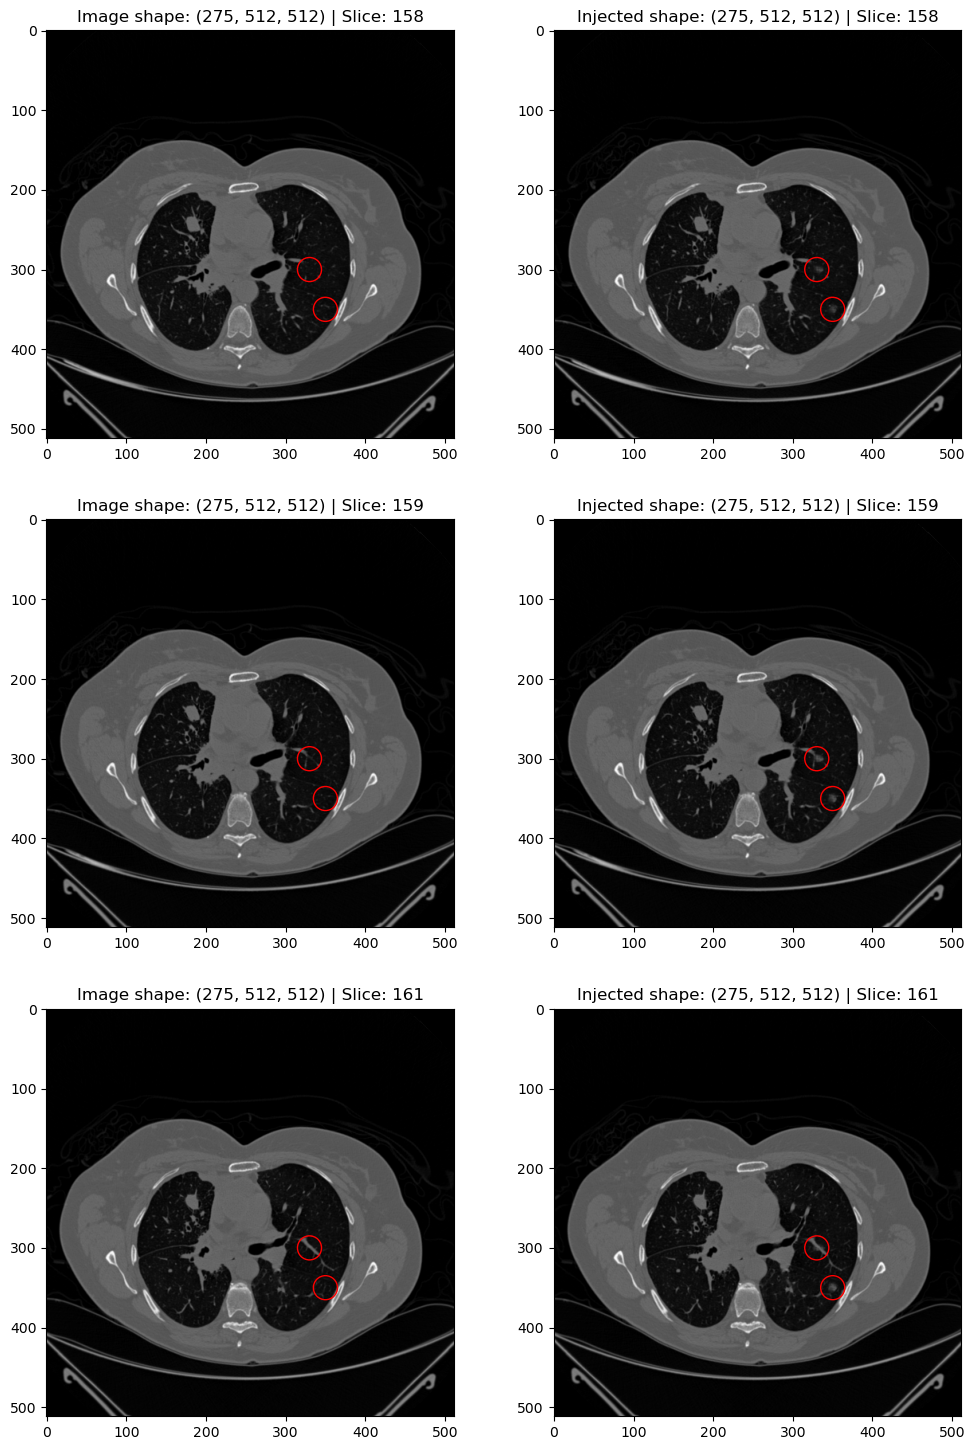

In [8]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img_path = '../data/1546.nii.gz'
injected_path = '../data/inference/0.nii.gz'

test_image_nib = nib.load(img_path)
test_injected_nib = nib.load(injected_path)
test_image = np.transpose(test_image_nib.get_fdata(), (2, 1, 0))[:, -1::-1, -1::-1]
test_injected = np.transpose(test_injected_nib.get_fdata(), (2, 1, 0))[:, -1::-1, -1::-1]

locations = [
    [158, 159, 161],
    [330,350],
    [300,350],
]
fig, axs = plt.subplots(3, 2, figsize=(12, 18))
for i, z in enumerate(locations[0]):
    axs[i, 0].imshow(test_image[z], cmap='gray')
    axs[i, 0].scatter(locations[1], locations[2], s=300, facecolors='none', edgecolors='r')
    axs[i, 0].set_title(f'Image shape: {test_image.shape} | Slice: {z}')
    axs[i, 1].imshow(test_injected[z], cmap='gray')
    axs[i, 1].scatter(locations[1], locations[2], s=300, facecolors='none', edgecolors='r')
    axs[i, 1].set_title(f'Injected shape: {test_injected.shape} | Slice: {z}')
plt.show()